**Data Processing:**

In [1]:
# The following sources are links to the documentation helpful for creating the code for this project:
# Python Documentation: https://docs.python.org/3/
# NumPy Documentation: https://numpy.org/doc/stable/
# pandas Documentation: https://pandas.pydata.org/docs/
# Matplotlib Documentation: https://matplotlib.org/
# Scikit-learn Documentation: https://scikit-learn.org/stable/

# This code was created for the research paper "Features that Impact the Rate of World Records in Video Game Speedrunning",
# and further details on the approach and implementation for the code can be found there.

# Running the following code requires the libraries imported below and should work for their most
# recent releases. The cells in the Data Processing section should be executed sequentially first, but
# beyond that the prediction models should be mostly independent to their own cell or cells and
# can be run in any order to fully create and test a prediction model at a time.

# Imports needed libraries for analysis.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as pltdates
from sklearn import linear_model
from sklearn import ensemble
from sklearn.inspection import permutation_importance
import sklearn.metrics as metrics

# Initializes constants.
NUM_GAMES = 99
NUM_COLUMNS = 18
NUM_FEATURES = 14
WR_HISTORY_INDEX = 9

# Sets epoch for plotting. The date for the epoch was found in Cell 10, but the epoch must be set earlier
# in the program in order to run properly.
pltdates.set_epoch(np.datetime64("1999-03-19T00:00:00.000000"))
print(pltdates.get_epoch())

1999-03-19T00:00:00.000000


In [2]:
# Parses all features from iw_speedrunning_data.csv file into a Pandas dataframe.
all_data = pd.read_csv("iw_speedrunning_data.csv")

# For each game, parses the data from the corresponding file in the 'World Record History' feature as a Pandas dataframe and adds it to the data.
for index in range(NUM_GAMES):
    csv_file_name = all_data["World Record History CSV File Name"][index]
    history = pd.read_csv(csv_file_name)
    all_data["World Record History"][index] = history

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2128467476.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  all_data["World Record History"][index] = history
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_8059

In [3]:
# Replaces any "Unknown" values for the Date Added on Speedrun.com to the year of data collection (2024) minus the year of the oldest speedrun world record.
# This may not be a perfect estimate, since the oldest record available might not be reflective of the actual first record posted on Speedrun.com,
# but it is a sensible estimate.
for index in range(NUM_GAMES):
    if all_data['"Date Added" on Speedrun.com (Years Ago)'][index] == "Unknown":
        history = all_data["World Record History"][index]
        oldest_record_date = history["Date"][0]
        oldest_record_year = int(oldest_record_date[:4])
        all_data['"Date Added" on Speedrun.com (Years Ago)'][index] = 2024 - oldest_record_year

# Calculates an estimated Rate of Speedruns Submitted based on the number of years of Speedrun.com and total number of runs submitted.
for index in range(NUM_GAMES):
    total_speedruns = int(all_data["Total Number of Speedruns Submitted"][index])
    date_added = int(all_data['"Date Added" on Speedrun.com (Years Ago)'][index])
    if (date_added != 0):
        all_data["Rate of Speedruns Submitted (Runs/Day)"][index] = total_speedruns / (date_added * 365.25)
    # The only exception to this data is Nintendo World Championships: NES Edition, which has not been out for a full year yet.
    # Thus, its value will be set to zero by default as the time frame seems too small to give an accurate estimate.
    else:
        all_data["Rate of Speedruns Submitted (Runs/Day)"][index] = 0


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/1486391557.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  all_data['"Date Added" on Speedrun.com (Years Ago)'][index] = 2024 - oldest_record_year
/var/folders/z_/41vs82dn1

**Training and Validation and Test Data Split:**

In [4]:
# Splits the data found in the World Record History into training data and test data for each game.
training_data = all_data.copy()
test_data = all_data.copy()
for index in range(NUM_GAMES):
    history = all_data["World Record History"][index]
    number_of_records = history.shape[0]
    split = int(0.8 * number_of_records)
    training_data["World Record History"][index] = history[:split][:]
    test_data["World Record History"][index] = history[split:][:]

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2734322934.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  training_data["World Record History"][index] = history[:split][:]
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/

**Initial Data Analysis:**

In [5]:
# Finds the total number of world records across the 100 games in the training data, as well as the minimum and maximum amounts of world records for each game.
min_records = 1000000
min_records_titles = []
max_records = 0
max_records_titles = []
TOTAL_TRAINING_RECORDS = 0
for index in range(NUM_GAMES):
    history = training_data["World Record History"][index]
    number_of_records = history.shape[0]
    TOTAL_TRAINING_RECORDS += number_of_records

    if number_of_records < min_records:
        min_records = number_of_records
        
    if number_of_records > max_records:
        max_records = number_of_records

for index in range(NUM_GAMES):
    history = training_data["World Record History"][index]
    number_of_records = history.shape[0]
    if number_of_records == min_records:
        min_records_titles.append(training_data["Game Title"][index])
    if number_of_records == max_records:
        max_records_titles.append(training_data["Game Title"][index])

print("The total number of records in this training data set is: " + str(TOTAL_TRAINING_RECORDS))
print("The minimum number of world records a single game has had in this training data set is " + str(min_records) + ", which the following games had:")
for title in min_records_titles:
    print("\t" + title)
print("The maximum number of world records a single game has had in this training data set is " + str(max_records) + ", which the following games had:")
for title in max_records_titles:
    print("\t" + title)

The total number of records in this training data set is: 2982
The minimum number of world records a single game has had in this training data set is 8, which the following games had:
	Mario Kart: Double Dash!!
	Burnout Paradise Remastered
	Resident Evil 3
The maximum number of world records a single game has had in this training data set is 150, which the following games had:
	SpongeBob SquarePants: Battle for Bikini Bottom


In [6]:
# Finds the total number of world records across the 100 games in the test data set.
TOTAL_TEST_RECORDS = 0
for index in range(NUM_GAMES):
    history = test_data["World Record History"][index]
    TOTAL_TEST_RECORDS += history.shape[0]

print("The total number of records in this test data set is: " + str(TOTAL_TEST_RECORDS))
# The games corresponding to the minimum and maximum number of world records should be identical for the trianing and testing data.

The total number of records in this test data set is: 795


In [8]:
# Outputs the additional feature data to the all_data_out.txt file for easier visual analysis.
all_data_out = open("all_data_out.txt", "w")
all_data_out.write(all_data.to_string(columns=[
    "Game Title",
    "Game Release Year",
    "Years Since Release (2024 - Release Year)",
    '"Date Added" on Speedrun.com (Years Ago)',
    "Game 'Metascore'",
    "Game 'User Score'",
    "Released On: PC?",
    "Released On: Nintendo System?",
    "Released On: Playstation System?",
    "Released On: Xbox System?",
    "Total Number of Speedruns Submitted",
    "Rate of Speedruns Submitted (Runs/Day)",
    "Number of People Following the Game",
    "Number of Active Speedrunners",
    "Total Number of Speedrunners",
    "Date of Data Collection"
]))
all_data_out.close()

In [10]:
# Creates a pandas dataframe with only the numerical data to perform correlation analysis.
numbers_only = training_data.copy()
numbers_only = numbers_only.drop("Game Title", axis=1)
numbers_only = numbers_only.drop("World Record History CSV File Name", axis=1)
numbers_only = numbers_only.drop("World Record History", axis=1)
numbers_only = numbers_only.drop("Date of Data Collection", axis=1)

# Creates the correlation map of the data.
correlations = numbers_only.corr()

# Outputs the data to the data_out.txt file for visual analysis.
correlations_out = open("correlations.txt", "w")
correlations_out.write(correlations.to_string())
correlations_out.close()

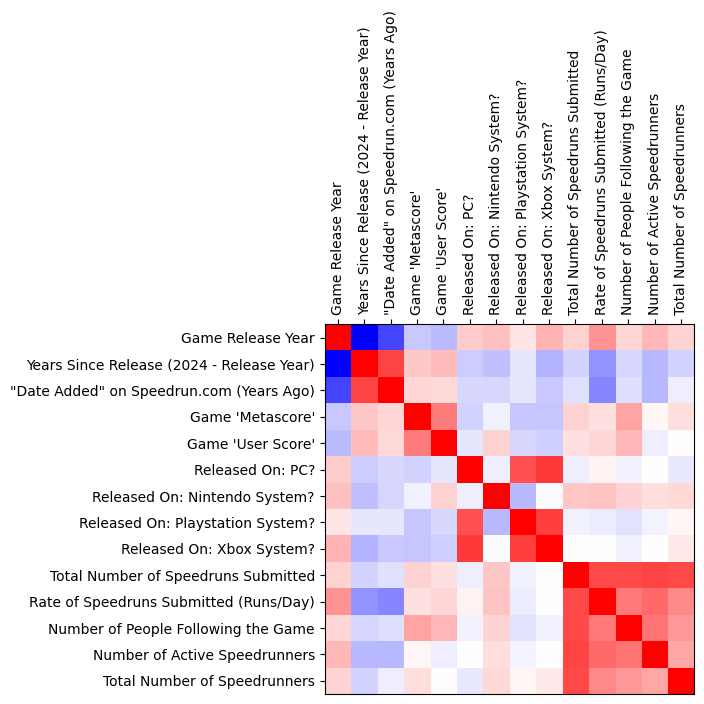

In [12]:
# Plots correlation map.
def format_labels(value, index):
    if int(value) < len(corerlation_labels) and int(value) >= 0:
        return corerlation_labels[int(value)]
    return ""
corerlation_map, corerlation_axes = plt.subplots()
corerlation_labels = correlations.axes[0].to_numpy()
corerlation_axes.xaxis.set_tick_params(labeltop=True, labelbottom=False, top=True, bottom=False)
corerlation_axes.xaxis.set_tick_params(rotation=90)
corerlation_axes.xaxis.set_major_formatter(format_labels)
corerlation_axes.xaxis.set_major_locator(ticker.MaxNLocator(len(corerlation_labels)))
corerlation_axes.yaxis.set_major_formatter(format_labels)
corerlation_axes.yaxis.set_major_locator(ticker.MaxNLocator(len(corerlation_labels)))
corerlation_axes.imshow(correlations, cmap="bwr")

In [13]:
# Converts the training and testing data into only the desired numerical features.
for index in range(NUM_GAMES):
    training_history = training_data["World Record History"][index].copy()
    training_history = training_history.drop("Id", axis=1)
    training_history = training_history.drop("Players", axis=1)
    training_history = training_history.drop("Time", axis=1)
    training_history = training_history.drop("Link", axis=1)
    training_history["Date"] = pd.to_datetime(training_history["Date"])
    training_data["World Record History"][index] = training_history.to_numpy(copy=True)

    test_history = test_data["World Record History"][index].copy()
    test_history = test_history.drop("Id", axis=1)
    test_history = test_history.drop("Players", axis=1)
    test_history = test_history.drop("Time", axis=1)
    test_history = test_history.drop("Link", axis=1)
    test_history["Date"] = pd.to_datetime(test_history["Date"])
    test_data["World Record History"][index] = test_history.to_numpy(copy=True)

numerical_training_data = training_data.copy()
numerical_training_data = numerical_training_data.drop("Game Title", axis=1)
numerical_training_data = numerical_training_data.drop("World Record History CSV File Name", axis=1)
numerical_training_data = numerical_training_data.drop("Date of Data Collection", axis=1)
for index in range(NUM_GAMES):
    for label in [
                    "Game Release Year",
                    "Years Since Release (2024 - Release Year)",
                    '"Date Added" on Speedrun.com (Years Ago)',
                    "Game 'Metascore'",
                    "Game 'User Score'",
                    "Released On: PC?",
                    "Released On: Nintendo System?",
                    "Released On: Playstation System?",
                    "Released On: Xbox System?",
                    "Total Number of Speedruns Submitted",
                    "Rate of Speedruns Submitted (Runs/Day)",
                    "Number of People Following the Game",
                    "Number of Active Speedrunners",
                    "Total Number of Speedrunners"
                ]:
        if type(numerical_training_data[label][index]) == type("string"):
            numerical_training_data[label][index] = float(numerical_training_data[label][index])

numerical_training_data = numerical_training_data.to_numpy(copy=True)

numerical_test_data = test_data.copy()
numerical_test_data = numerical_test_data.drop("Game Title", axis=1)
numerical_test_data = numerical_test_data.drop("World Record History CSV File Name", axis=1)
numerical_test_data = numerical_test_data.drop("Date of Data Collection", axis=1)
for index in range(NUM_GAMES):
    for label in [
                    "Game Release Year",
                    "Years Since Release (2024 - Release Year)",
                    '"Date Added" on Speedrun.com (Years Ago)',
                    "Game 'Metascore'",
                    "Game 'User Score'",
                    "Released On: PC?",
                    "Released On: Nintendo System?",
                    "Released On: Playstation System?",
                    "Released On: Xbox System?",
                    "Total Number of Speedruns Submitted",
                    "Rate of Speedruns Submitted (Runs/Day)",
                    "Number of People Following the Game",
                    "Number of Active Speedrunners",
                    "Total Number of Speedrunners"
                ]:
        if type(numerical_test_data[label][index]) == type("string"):
            numerical_test_data[label][index] = float(numerical_test_data[label][index])

numerical_test_data = numerical_test_data.to_numpy(copy=True)

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3271843332.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  training_data["World Record History"][index] = training_history.to_numpy(copy=True)
/var/folders/z_/41vs82dn1j788

In [14]:
# Finds the date of the oldest world record in the data set in order to set the epoch to that date.
training_wr_array = numerical_training_data[:, WR_HISTORY_INDEX]
test_wr_array = numerical_test_data[:, WR_HISTORY_INDEX]

# The commented code was used to find the oldest date of the data to set the epoch which all time data would
# be relative to, but the epoch must be set at the beginning of the program, so it was instead printed and used
# as a constant in Cell 1.

# # Arbitrarily initializes the oldest date as the date of writing this code, since this occurred long after the
# # data was collected and therefore must be the newest date of the possible world records.
# oldest_date = np.datetime64("2024-10-17")
# for i in range(NUM_GAMES):
#     current_history = training_wr_array[i]
#     dates = current_history[:,0]
#     for date in dates:
#         if (np.datetime64(date) < oldest_date):
#             oldest_date = np.datetime64(date)
# print(oldest_date)

# Converts the dates of all world records to the number of days since the set epoch for a consistent scale.
for i in range(NUM_GAMES):
    current_history = training_wr_array[i]
    dates = current_history[:,0]
    for j in range(len(dates)):
        dates[j] = pltdates.date2num(np.datetime64(dates[j]))

for i in range(NUM_GAMES):
    current_history = test_wr_array[i]
    dates = current_history[:,0]
    for j in range(len(dates)):
        dates[j] = pltdates.date2num(np.datetime64(dates[j]))

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/1313417327.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  all_wr_plot.show()


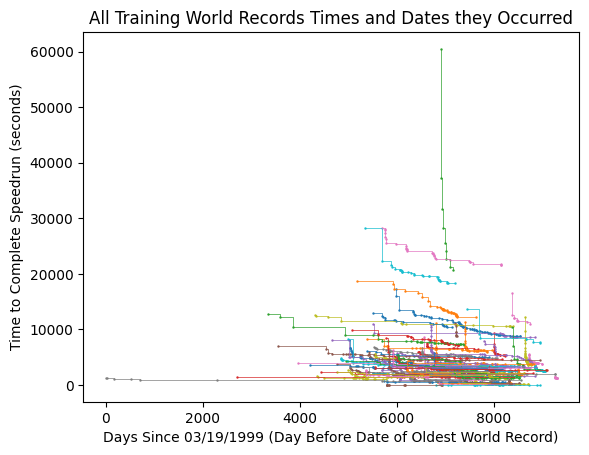

In [15]:
# Plots the trainnig world record data.
all_wr_plot, all_wr_axes = plt.subplots()
all_wr_axes.set_xlabel("Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
all_wr_axes.set_ylabel("Time to Complete Speedrun (seconds)")
all_wr_axes.set_title("All Training World Records Times and Dates they Occurred")

for i in range(NUM_GAMES):
    current_history = numerical_training_data[i][WR_HISTORY_INDEX]
    dates = current_history[:,0]
    times = current_history[:,1]
    all_wr_axes.step(dates, times, where="post", linewidth=0.5)
    all_wr_axes.scatter(dates, times, s=0.5)

all_wr_plot.show()

Outliers in Age:  Super Mario Sunshine
Games Under a Minute:  Crossy Road
Outliers in World Record Time:  Monster Hunter World (Console)
Outliers in Age:  New Super Mario Bros.
Outliers in Age:  Mario Kart Wii
Outliers in Age:  Banjo-Kazooie
Outliers in Age:  Quake
Games Under a Minute:  Counter-Strike: Global Offensive


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/1624257479.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  condensed_wr_plot.show()


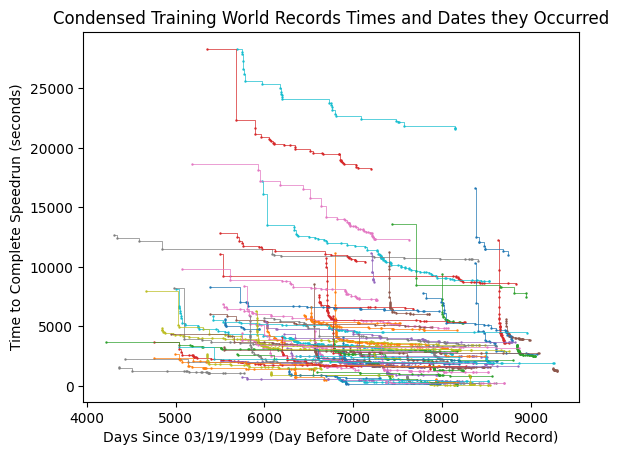

In [17]:
# Plots the world record data with a more condensed view.
condensed_wr_plot, condensed_wr_axes = plt.subplots()
condensed_wr_axes.set_xlabel("Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
condensed_wr_axes.set_ylabel("Time to Complete Speedrun (seconds)")
condensed_wr_axes.set_title("Condensed Training World Records Times and Dates they Occurred")

for i in range(NUM_GAMES):
    current_history = numerical_training_data[i][WR_HISTORY_INDEX]
    dates = current_history[:,0]
    times = current_history[:,1]
    if (dates[0] < 4000):
        print("Outliers in Age:  " + training_data["Game Title"][i])
        continue
    if (times[0] > 30000):
        print("Outliers in World Record Time:  " + training_data["Game Title"][i])
        continue
    if (times[-1] < 60):
        print("Games Under a Minute:  " + training_data["Game Title"][i])
        continue
    
    condensed_wr_axes.step(dates, times, where="post", linewidth=0.5)
    condensed_wr_axes.scatter(dates, times, s=0.5)


condensed_wr_plot.show()

**Creating Individual World Record Prediction Models for Each Game**

The root mean squared error is:		39.67546929321451
The mean absolute error is:		30.96406805297012
The mean relative error is:		1.1329159920165093%


(array([72., 13.,  5.,  4.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([4.17500000e-02, 2.49465806e+01, 4.98514111e+01, 7.47562417e+01,
        9.96610722e+01, 1.24565903e+02, 1.49470733e+02, 1.74375564e+02,
        1.99280394e+02, 2.24185225e+02, 2.49090056e+02, 2.73994886e+02,
        2.98899717e+02, 3.23804547e+02, 3.48709378e+02, 3.73614208e+02,
        3.98519039e+02, 4.23423869e+02, 4.48328700e+02, 4.73233531e+02,
        4.98138361e+02, 5.23043192e+02, 5.47948022e+02, 5.72852853e+02,
        5.97757683e+02, 6.22662514e+02, 6.47567344e+02, 6.72472175e+02,
        6.97377006e+02, 7.22281836e+02, 7.47186667e+02]),
 <BarContainer object of 30 artists>)

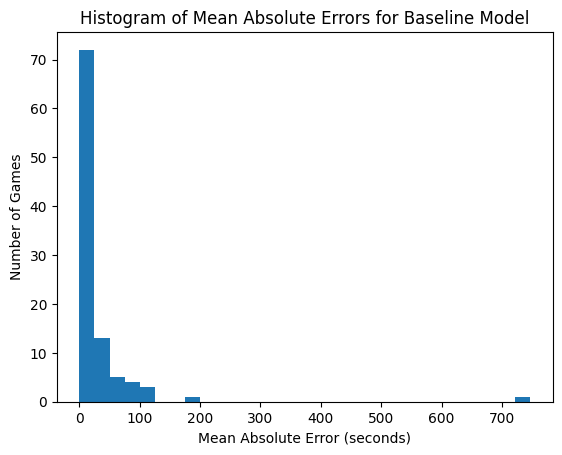

In [19]:
# Creates the baseline model found in Sevilla and Erdil's papers where the model
# predicts that the next world record is equal to the previous one.
# (Rather, this produces the error of the baseline model by accessing the data using the method of
# the baseline model.)

actual_outputs = []
predicted_outputs = []
rmse_list = []
mae_list = []
mre_list = []

for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]

    training_x = training_history[:,0].copy().astype(np.float64)
    training_y = training_history[:,1].copy().astype(float)
    test_x = test_history[:,0].copy().astype(np.float64)
    actual_y = test_history[:,1].copy().astype(np.float64)

    predicted_y = []
    for j in range(len(actual_y)):
        if j == 0:
            predicted_y.append(training_y[-1])
        else:
            predicted_y.append(actual_y[j - 1])

    rmse_list.append(metrics.root_mean_squared_error(actual_y, predicted_y))
    mae_list.append(metrics.mean_absolute_error(actual_y, predicted_y))
    error_sum = 0
    for j in range(len(actual_y)):
        actual_outputs.append(actual_y[j])
        predicted_outputs.append(predicted_y[j])
        error_sum += abs(actual_y[j] - predicted_y[j]) / actual_y[j]
    mre_list.append(error_sum / len(actual_y))

# Reports various errors.
print("The root mean squared error is:\t\t" + str(np.mean(rmse_list)))
print("The mean absolute error is:\t\t" + str(np.mean(mae_list)))
print("The mean relative error is:\t\t" + str(np.mean(mre_list) * 100) + "%")

# Creates a histogram to visualize the mean absolute errors.
error_histogram, error_axes = plt.subplots()
error_axes.set_xlabel("Mean Absolute Error (seconds)")
error_axes.set_ylabel("Number of Games")
error_axes.set_title("Histogram of Mean Absolute Errors for Baseline Model")
error_axes.hist(mae_list, bins=30)

The root mean squared error is:		1468.9741481912527
The mean absolute error is:		1296.8626013659587
The mean relative error is:		69.93082187008443%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3602242381.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3602242381.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3602242381.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()


(array([67., 14.,  9.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([6.54908574e-02, 6.81938094e+02, 1.36381070e+03, 2.04568330e+03,
        2.72755590e+03, 3.40942851e+03, 4.09130111e+03, 4.77317371e+03,
        5.45504632e+03, 6.13691892e+03, 6.81879152e+03, 7.50066413e+03,
        8.18253673e+03, 8.86440933e+03, 9.54628194e+03, 1.02281545e+04,
        1.09100271e+04, 1.15918997e+04, 1.22737724e+04, 1.29556450e+04,
        1.36375176e+04, 1.43193902e+04, 1.50012628e+04, 1.56831354e+04,
        1.63650080e+04, 1.70468806e+04, 1.77287532e+04, 1.84106258e+04,
        1.90924984e+04, 1.97743710e+04, 2.04562436e+04, 2.11381162e+04,
        2.18199888e+04, 2.25018614e+04, 2.31837340e+04, 2.38656066e+04,
        2.45474792e+04, 2.52293518e+04, 2.59112244e+04, 2.65930970e+

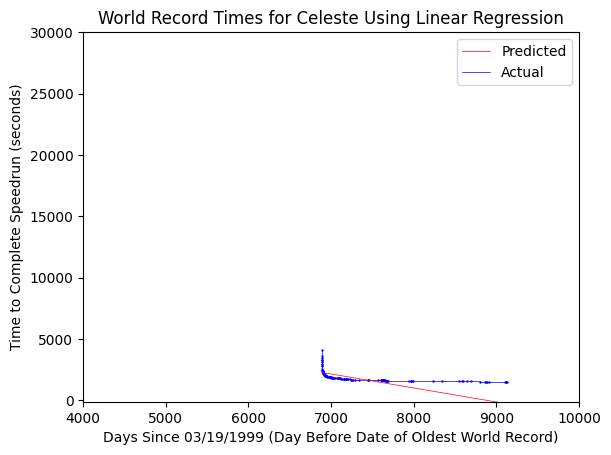

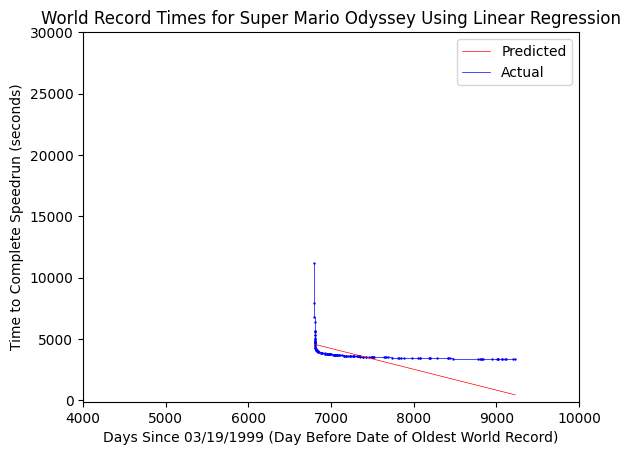

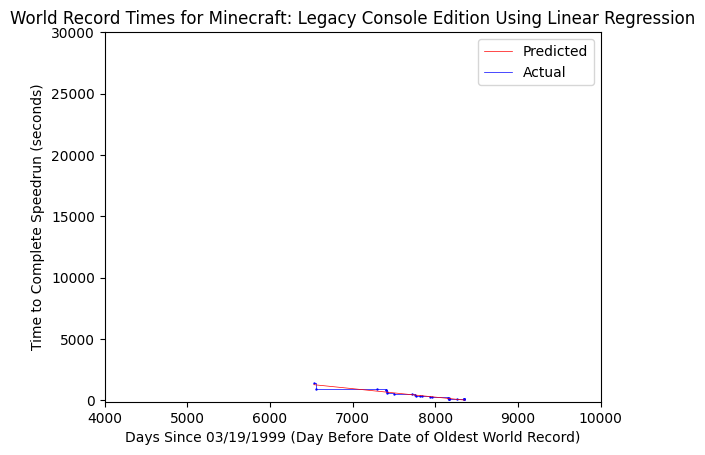

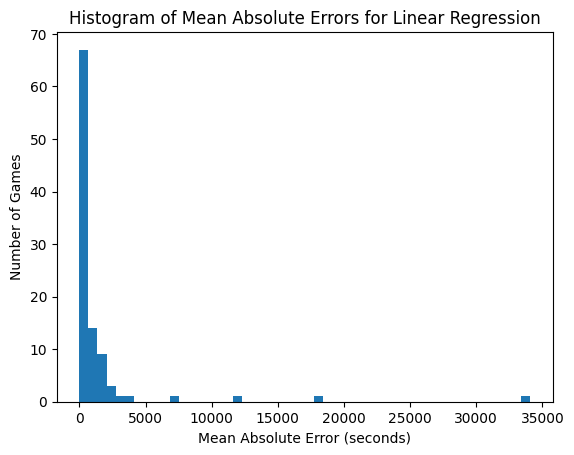

In [21]:
# Performs Linear Regression on just the world record data for each individual game.
# This is meant to reproduce a model used in Sevilla's paper.
linear_regression_model = linear_model.LinearRegression()

wr_only_linear_models = []
actual_outputs = []
predicted_outputs = []
rmse_list = []
mae_list = []
mre_list = []
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]

    # Trains the model.
    training_x = training_history[:,0].copy().astype(np.float64)
    training_x = training_x.reshape(-1, 1)
    training_y = training_history[:,1].copy().astype(float)
    training_y = (training_y.reshape(-1, 1))
    model = linear_regression_model.fit(training_x, training_y)
    wr_only_linear_models.append(model)

    # Tests the model.
    test_x = test_history[:,0].copy().astype(np.float64)
    test_x = test_x.reshape(-1, 1)
    actual_y = test_history[:,1].copy().astype(np.float64)
    actual_y = actual_y.reshape(-1, 1)
    predicted_y = model.predict(test_x)
    rmse_list.append(metrics.root_mean_squared_error(actual_y, predicted_y))
    mae_list.append(metrics.mean_absolute_error(actual_y, predicted_y))
    error_sum = 0
    for j in range(len(actual_y)):
        actual_outputs.append(actual_y[j])
        predicted_outputs.append(predicted_y[j])
        error_sum += abs(actual_y[j] - predicted_y[j]) / actual_y[j]
    mre_list.append(error_sum / len(actual_y))

    # Plots a few of the results for the prediction models.
    if i < 3:
        predicted_actual_plot, predicted_actual_axes = plt.subplots()
        predicted_actual_axes.set_xlabel("Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
        predicted_actual_axes.set_ylabel("Time to Complete Speedrun (seconds)")
        predicted_actual_axes.set_title("World Record Times for " + test_data["Game Title"][i] + " Using Linear Regression")
        predicted_actual_axes.set_xlim(4000, 10000)
        predicted_actual_axes.set_ylim(-100, 30000)

        all_x = np.concatenate((training_x, test_x))
        all_actual_y = np.concatenate((training_y, actual_y))
        all_predicted_y = model.predict(all_x)

        actual, = predicted_actual_axes.step(all_x, all_actual_y, where="post", color="blue", linewidth=0.5)
        predicted_actual_axes.scatter(all_x, all_actual_y, color="blue", s=0.5)
        predicted, = predicted_actual_axes.plot(all_x, all_predicted_y, color="red", linewidth=0.5)
        predicted_actual_axes.legend([predicted, actual], ["Predicted", "Actual"])

        predicted_actual_plot.show()

# Reports various errors.
print("The root mean squared error is:\t\t" + str(np.mean(rmse_list)))
print("The mean absolute error is:\t\t" + str(np.mean(mae_list)))
print("The mean relative error is:\t\t" + str(np.mean(mre_list) * 100) + "%")

# Creates a histogram to visualize the mean absolute errors.
error_histogram, error_axes = plt.subplots()
error_axes.set_xlabel("Mean Absolute Error (seconds)")
error_axes.set_ylabel("Number of Games")
error_axes.set_title("Histogram of Mean Absolute Errors for Linear Regression")
error_axes.hist(mae_list, bins=50)

The root mean squared error is:		511.27856083944533
The mean absolute error is:		477.8261143206032
The mean relative error is:		16.34567732562138%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/679638028.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/679638028.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/679638028.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()


(array([53., 21., 12.,  2.,  2.,  4.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.]),
 array([7.43085233e-02, 2.39690739e+02, 4.79307169e+02, 7.18923599e+02,
        9.58540029e+02, 1.19815646e+03, 1.43777289e+03, 1.67738932e+03,
        1.91700575e+03, 2.15662218e+03, 2.39623861e+03, 2.63585504e+03,
        2.87547147e+03, 3.11508790e+03, 3.35470433e+03, 3.59432076e+03,
        3.83393719e+03, 4.07355362e+03, 4.31317005e+03, 4.55278648e+03,
        4.79240291e+03, 5.03201934e+03, 5.27163577e+03, 5.51125220e+03,
        5.75086863e+03, 5.99048506e+03, 6.23010149e+03, 6.46971792e+03,
        6.70933435e+03, 6.94895078e+03, 7.18856721e+03]),
 <BarContainer object of 30 artists>)

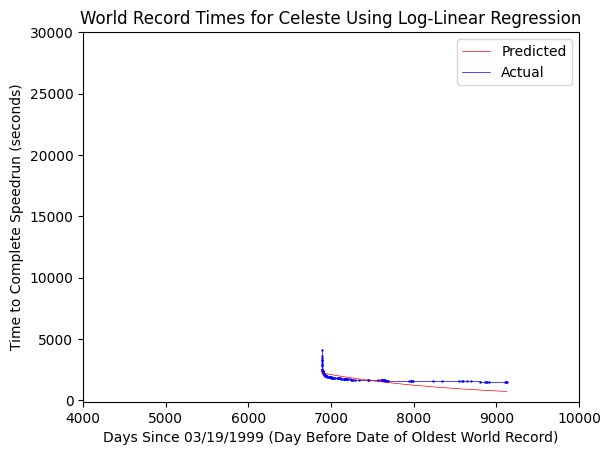

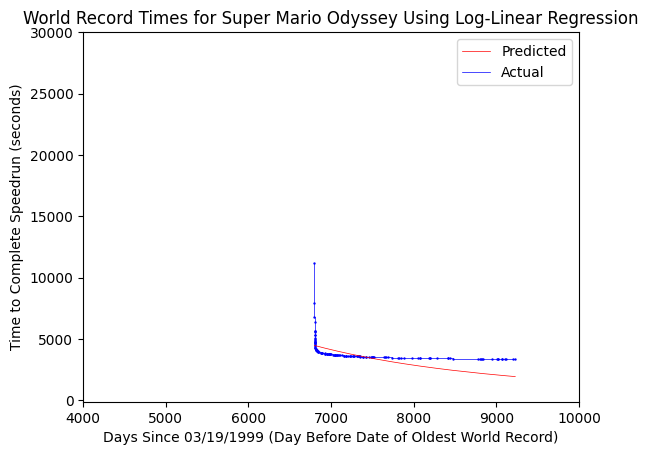

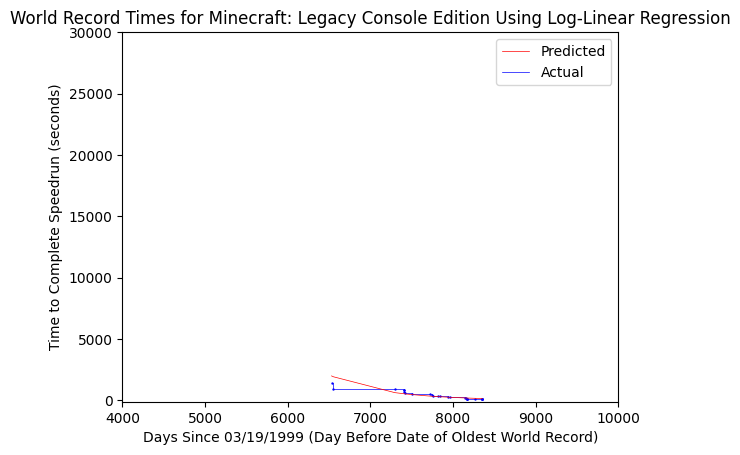

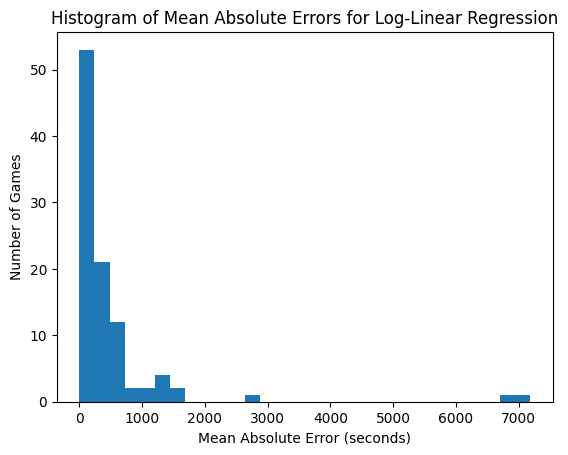

In [23]:
# Performs Log-Linear Regression on just the world record data for each individual game.
# This is meant to reproduce a model used in Sevilla's paper.
wr_only_log_linear_models = []
actual_outputs = []
predicted_outputs = []
rmse_list = []
mae_list = []
mre_list = []
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]

    # Trains the model.
    training_x = training_history[:,0].copy().astype(np.float64)
    training_x = training_x.reshape(-1, 1)
    training_y = training_history[:,1].copy().astype(float)
    training_y = (training_y.reshape(-1, 1))
    model = linear_regression_model.fit(np.log(training_x), np.log(training_y))
    wr_only_log_linear_models.append(model)

    # Tests the model.
    test_x = test_history[:,0].copy().astype(np.float64)
    test_x = test_x.reshape(-1, 1)
    actual_y = test_history[:,1].copy().astype(np.float64)
    actual_y = actual_y.reshape(-1, 1)
    predicted_y = np.exp(model.predict(np.log(test_x)))
    rmse_list.append(metrics.root_mean_squared_error(actual_y, predicted_y))
    mae_list.append(metrics.mean_absolute_error(actual_y, predicted_y))
    error_sum = 0
    for j in range(len(actual_y)):
        actual_outputs.append(actual_y[j])
        predicted_outputs.append(predicted_y[j])
        error_sum += abs(actual_y[j] - predicted_y[j]) / actual_y[j]
    mre_list.append(error_sum / len(actual_y))

    # Plots a few of the results for the prediction models.
    if i < 3:
        predicted_actual_plot, predicted_actual_axes = plt.subplots()
        predicted_actual_axes.set_xlabel("Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
        predicted_actual_axes.set_ylabel("Time to Complete Speedrun (seconds)")
        predicted_actual_axes.set_title("World Record Times for " + test_data["Game Title"][i] + " Using Log-Linear Regression")
        predicted_actual_axes.set_xlim(4000, 10000)
        predicted_actual_axes.set_ylim(-100, 30000)

        all_x = np.concatenate((training_x, test_x))
        all_actual_y = np.concatenate((training_y, actual_y))
        all_predicted_y = np.exp(model.predict(np.log(all_x)))

        actual, = predicted_actual_axes.step(all_x, all_actual_y, where="post", color="blue", linewidth=0.5)
        predicted_actual_axes.scatter(all_x, all_actual_y, color="blue", s=0.5)
        predicted, = predicted_actual_axes.plot(all_x, all_predicted_y, color="red", linewidth=0.5)
        predicted_actual_axes.legend([predicted, actual], ["Predicted", "Actual"])

        predicted_actual_plot.show()

# Reports various errors.
print("The root mean squared error is:\t\t" + str(np.mean(rmse_list)))
print("The mean absolute error is:\t\t" + str(np.mean(mae_list)))
print("The mean relative error is:\t\t" + str(np.mean(mre_list) * 100) + "%")

# Creates a histogram to visualize the mean absolute errors.
error_histogram, error_axes = plt.subplots()
error_axes.set_xlabel("Mean Absolute Error (seconds)")
error_axes.set_ylabel("Number of Games")
error_axes.set_title("Histogram of Mean Absolute Errors for Log-Linear Regression")
error_axes.hist(mae_list, bins=30)

The root mean squared error is:		253.34209696977052
The mean absolute error is:		227.16226473795513
The mean relative error is:		6.664852470900487%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/233846776.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/233846776.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/233846776.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()


(array([82., 10.,  3.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([6.24045475e-02, 2.26164237e+02, 4.52266069e+02, 6.78367901e+02,
        9.04469734e+02, 1.13057157e+03, 1.35667340e+03, 1.58277523e+03,
        1.80887706e+03, 2.03497889e+03, 2.26108073e+03, 2.48718256e+03,
        2.71328439e+03, 2.93938622e+03, 3.16548806e+03, 3.39158989e+03,
        3.61769172e+03, 3.84379355e+03, 4.06989539e+03, 4.29599722e+03,
        4.52209905e+03, 4.74820088e+03, 4.97430271e+03, 5.20040455e+03,
        5.42650638e+03, 5.65260821e+03, 5.87871004e+03, 6.10481188e+03,
        6.33091371e+03, 6.55701554e+03, 6.78311737e+03]),
 <BarContainer object of 30 artists>)

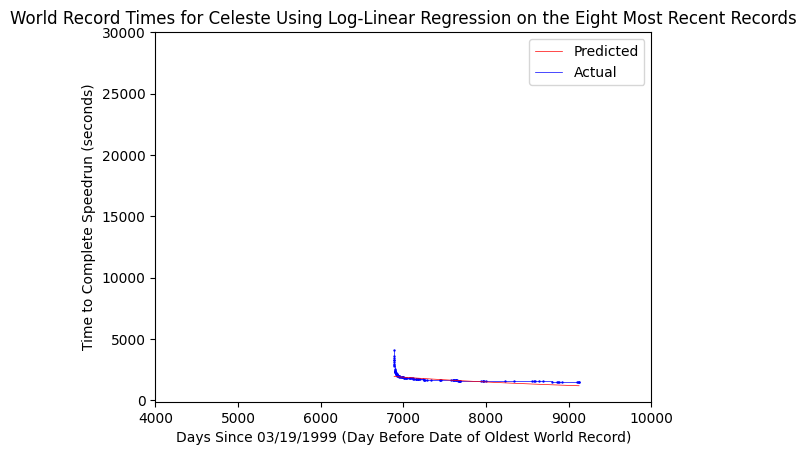

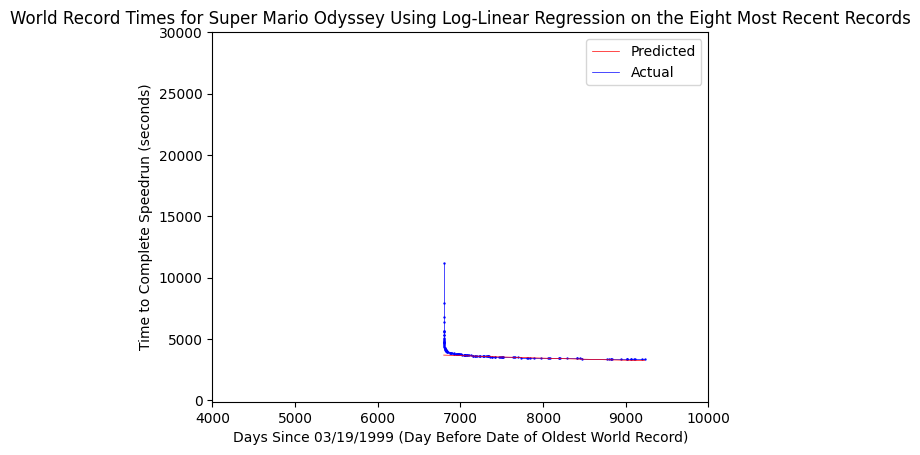

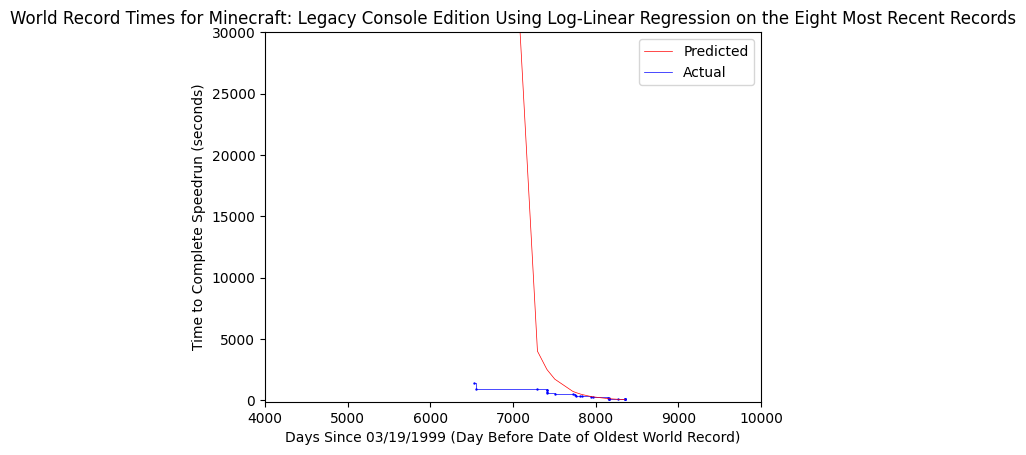

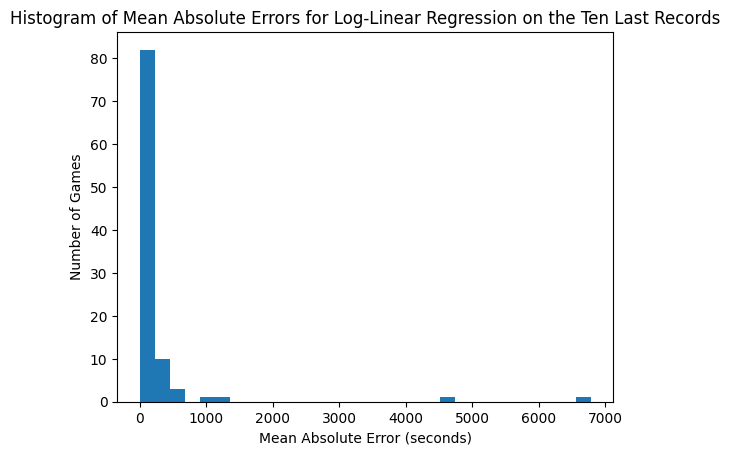

In [25]:
# Performs Log-Linear Regression on just the 8 most recent world records for each individual game.
# This is meant to reproduce a model similar to ones in Sevilla's first paper.
wr_only_log_linear_recent_models = []
actual_outputs = []
predicted_outputs = []
rmse_list = []
mae_list = []
mre_list = []
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]

    # Trains the model.
    training_x = training_history[-8:,0].copy().astype(np.float64)
    training_x = training_x.reshape(-1, 1)
    training_y = training_history[-8:,1].copy().astype(float)
    training_y = (training_y.reshape(-1, 1))
    model = linear_regression_model.fit(np.log(training_x), np.log(training_y))
    wr_only_log_linear_recent_models.append(model)

    # Tests the model.
    test_x = test_history[:,0].copy().astype(np.float64)
    test_x = test_x.reshape(-1, 1)
    actual_y = test_history[:,1].copy().astype(np.float64)
    actual_y = actual_y.reshape(-1, 1)
    predicted_y = np.exp(model.predict(np.log(test_x)))
    rmse_list.append(metrics.root_mean_squared_error(actual_y, predicted_y))
    mae_list.append(metrics.mean_absolute_error(actual_y, predicted_y))
    error_sum = 0
    for j in range(len(actual_y)):
        actual_outputs.append(actual_y[j])
        predicted_outputs.append(predicted_y[j])
        error_sum += abs(actual_y[j] - predicted_y[j]) / actual_y[j]
    mre_list.append(error_sum / len(actual_y))

    # Plots a few of the results for the prediction models.
    if i < 3:
        predicted_actual_plot, predicted_actual_axes = plt.subplots()
        predicted_actual_axes.set_xlabel("Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
        predicted_actual_axes.set_ylabel("Time to Complete Speedrun (seconds)")
        predicted_actual_axes.set_title("World Record Times for " + test_data["Game Title"][i] + " Using Log-Linear Regression on the Eight Most Recent Records")
        predicted_actual_axes.set_xlim(4000, 10000)
        predicted_actual_axes.set_ylim(-100, 30000)

        all_x = np.concatenate((training_history[:,0].copy().astype(np.float64).reshape(-1, 1), test_x))
        all_actual_y = np.concatenate((training_history[:,1].copy().astype(np.float64).reshape(-1, 1), actual_y))
        all_predicted_y = np.exp(model.predict(np.log(all_x)))

        actual, = predicted_actual_axes.step(all_x, all_actual_y, where="post", color="blue", linewidth=0.5)
        predicted_actual_axes.scatter(all_x, all_actual_y, color="blue", s=0.5)
        predicted, = predicted_actual_axes.plot(all_x, all_predicted_y, color="red", linewidth=0.5)
        predicted_actual_axes.legend([predicted, actual], ["Predicted", "Actual"])

        predicted_actual_plot.show()

# Reports various errors.
print("The root mean squared error is:\t\t" + str(np.mean(rmse_list)))
print("The mean absolute error is:\t\t" + str(np.mean(mae_list)))
print("The mean relative error is:\t\t" + str(np.mean(mre_list) * 100) + "%")

# Creates a histogram to visualize the mean absolute errors.
error_histogram, error_axes = plt.subplots()
error_axes.set_xlabel("Mean Absolute Error (seconds)")
error_axes.set_ylabel("Number of Games")
error_axes.set_title("Histogram of Mean Absolute Errors for Log-Linear Regression on the Ten Last Records")
error_axes.hist(mae_list, bins=30)

The root mean squared error is:		430.6720809832591
The mean absolute error is:		419.95884519349335
The mean relative error is:		18.8282806379872%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2963146648.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2963146648.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2963146648.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  predicted_actual_plot.show()


(array([59., 16.,  9.,  3.,  4.,  2.,  4.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.07736107e-01, 2.18971972e+02, 4.37736208e+02, 6.56500443e+02,
        8.75264679e+02, 1.09402891e+03, 1.31279315e+03, 1.53155739e+03,
        1.75032162e+03, 1.96908586e+03, 2.18785009e+03, 2.40661433e+03,
        2.62537856e+03, 2.84414280e+03, 3.06290704e+03, 3.28167127e+03,
        3.50043551e+03, 3.71919974e+03, 3.93796398e+03, 4.15672822e+03,
        4.37549245e+03, 4.59425669e+03, 4.81302092e+03, 5.03178516e+03,
        5.25054939e+03, 5.46931363e+03, 5.68807787e+03, 5.90684210e+03,
        6.12560634e+03, 6.34437057e+03, 6.56313481e+03, 6.78189904e+03,
        7.00066328e+03, 7.21942752e+03, 7.43819175e+03, 7.65695599e+03,
        7.87572022e+03, 8.09448446e+03, 8.31324869e+03, 8.53201293e+

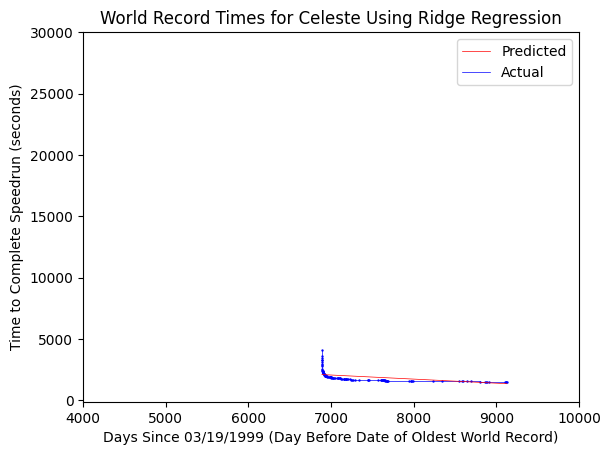

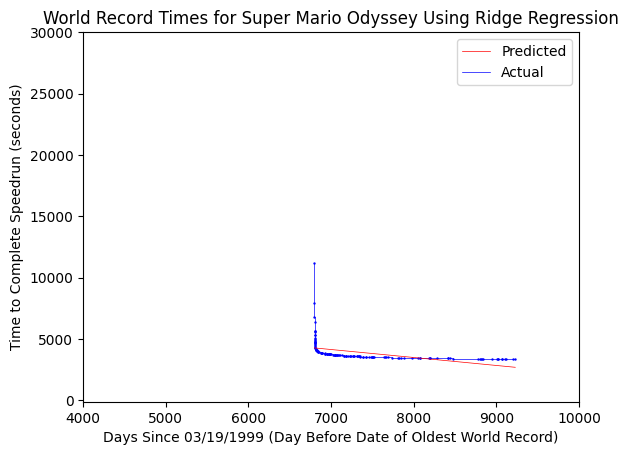

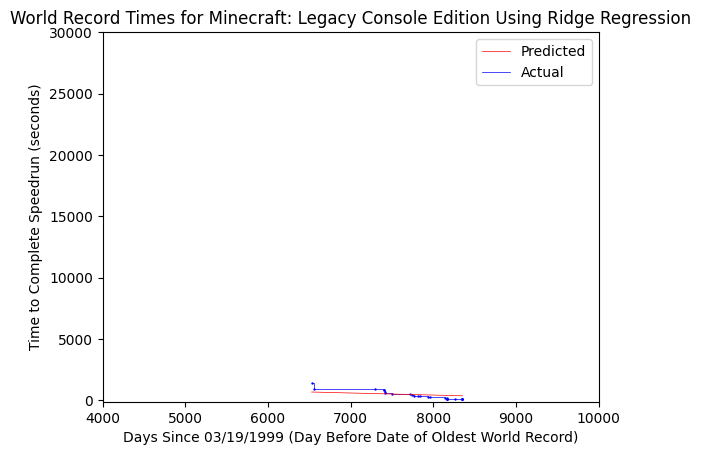

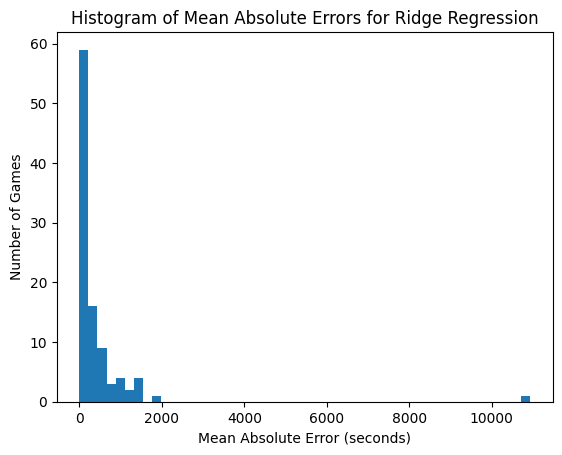

In [27]:
# Performs Ridge Regression on just the world record data for each individual game.
# There is no similar model used by Sevilla or Erdil, so the results of this model were
# not reported due to the purpose of these models primarily being to determine differences
# in the dataset by using similar models.

# This value of alpha was determined by using different values of alpha manually until
# finding one that seemed to be around the best.
ridge_regression_model = linear_model.Ridge(alpha=14300000)

wr_only_ridge_models = []
actual_outputs = []
predicted_outputs = []
rmse_list = []
mae_list = []
mre_list = []
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]

    # Trains the model.
    training_x = training_history[:,0].copy().astype(np.float64)
    training_x = training_x.reshape(-1, 1)
    training_y = training_history[:,1].copy().astype(np.float64)
    training_y = training_y.reshape(-1, 1)
    model = ridge_regression_model.fit(training_x, training_y)
    wr_only_ridge_models.append(model)

    # Tests the model.
    test_x = test_history[:,0].copy().astype(np.float64)
    test_x = test_x.reshape(-1, 1)
    actual_y = test_history[:,1].copy().astype(np.float64)
    actual_y = actual_y.reshape(-1, 1)
    predicted_y = model.predict(test_x)
    rmse_list.append(metrics.root_mean_squared_error(actual_y, predicted_y))
    mae_list.append(metrics.mean_absolute_error(actual_y, predicted_y))
    error_sum = 0
    for j in range(len(actual_y)):
        actual_outputs.append(actual_y[j])
        predicted_outputs.append(predicted_y[j])
        error_sum += abs(actual_y[j] - predicted_y[j]) / actual_y[j]
    mre_list.append(error_sum / len(actual_y))

    # Plots a few of the results for the prediction models.
    if i < 3:
        predicted_actual_plot, predicted_actual_axes = plt.subplots()
        predicted_actual_axes.set_xlabel("Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
        predicted_actual_axes.set_ylabel("Time to Complete Speedrun (seconds)")
        predicted_actual_axes.set_title("World Record Times for " + test_data["Game Title"][i] + " Using Ridge Regression")
        predicted_actual_axes.set_xlim(4000, 10000)
        predicted_actual_axes.set_ylim(-100, 30000)

        all_x = np.concatenate((training_x, test_x))
        all_actual_y = np.concatenate((training_y, actual_y))
        all_predicted_y = model.predict(all_x)

        actual, = predicted_actual_axes.step(all_x, all_actual_y, where="post", color="blue", linewidth=0.5)
        predicted_actual_axes.scatter(all_x, all_actual_y, color="blue", s=0.5)
        predicted, = predicted_actual_axes.plot(all_x, all_predicted_y, color="red", linewidth=0.5)
        predicted_actual_axes.legend([predicted, actual], ["Predicted", "Actual"])

        predicted_actual_plot.show()

# Reports various errors.
print("The root mean squared error is:\t\t" + str(np.mean(rmse_list)))
print("The mean absolute error is:\t\t" + str(np.mean(mae_list)))
print("The mean relative error is:\t\t" + str(np.mean(mre_list) * 100) + "%")

# Creates a histogram to visualize the mean absolute errors.
error_histogram, error_axes = plt.subplots()
error_axes.set_xlabel("Mean Absolute Error (seconds)")
error_axes.set_ylabel("Number of Games")
error_axes.set_title("Histogram of Mean Absolute Errors for Ridge Regression")
error_axes.hist(mae_list, bins=50)

**Creating General World Record Prediction Models for Any Game Input Data**

The comment at the top of the cell lists which model is being created and tested in that cell. (For some models, the training and testing is split across multiple cells, in which case any cells which only contain tests are for testing the most recently created model.) For example, the comment "Last Seven Linear Model without Additional Features" refers to a model which uses the training input of the last seven records only, linear regression, and does not include the additional features. The models are created and tested in the following order of regression technique, then training input, and then additional feature use:
- ```Regression Techniques Used:```  Linear, Lasso, Random Forest
- ```Training Inputs Used:```  Last Seven Records Only, Step Through
- ```Additional Feature Use:```  Without Additional Features, With Additional Features

This is the same order as the rows of the tables where the errors are reported in corresponding research paper for this code: "Features that Impact the Rate of World Records in Video Game Speedrunning".

*(Note: Some models are created with varying numbers of features. These are included for potential future work but are not reported on because they were only experimented with very briefly and could not be analyzed thoroughly within the time frame.)*

In [36]:
# Last Seven Linear Model without Additional Features

# Creates the training input and output.
training_x = np.zeros((NUM_GAMES, 14))
training_y = np.zeros((NUM_GAMES, 2))
for i in range(NUM_GAMES):
    # Adds the world record data to the training input.
    training_history = training_wr_array[i]
    for j in range(7):
        training_x[i][j] = training_history[-j - 2, 0]
        training_x[i][j + 7] = training_history[-j - 2, 1]

    # Adds the world record data to the training output.
    training_y[i][0] = training_history[-1, 0]
    training_y[i][1] = training_history[-1, 1]

# Trains the model.
general_linear_last_7_wr_only = linear_regression_model.fit(training_x, training_y)

In [37]:
# Creates the test input and actual output for just the first test record of each game.
test_x = np.zeros((NUM_GAMES, 14))
actual_y = np.zeros((NUM_GAMES, 2))
for i in range(NUM_GAMES):
    # Adds the world record data to the test input.
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    for j in range(7):
        test_x[i][j] = training_history[-j - 1, 0]
        test_x[i][j + 7] = training_history[-j - 1, 1]

    # Adds the world record data to the actual output.
    actual_y[i][0] = test_history[0, 0]
    actual_y[i][1] = test_history[0, 1]

# Tests the model on just the first test world records.
predicted_y = general_linear_last_7_wr_only.predict(test_x)
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(NUM_GAMES):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]
date_mre = date_error_sum / NUM_GAMES
time_mre = time_error_sum / NUM_GAMES

# Reports various errors.
# print("The root mean squared error is:\t\t" + str(metrics.root_mean_squared_error(actual_outputs, predicted_outputs)))
# print("The mean absolute error is:\t\t" + str(metrics.mean_absolute_error(actual_outputs, predicted_outputs)))
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")

The date root mean squared error is:	183.82079226386574
The time root mean squared error is:	128.0591340703361
The date mean absolute error is:	115.5394743203241
The time mean absolute error is:	37.255238421448475
The date mean relative error is:	1.4308562811933674%
The time mean relative error is:	2.278711908902234%


The date root mean squared error is:	211.98241435049954
The time root mean squared error is:	59.989635085422655
The date mean absolute error is:	115.16626768271057
The time mean absolute error is:	21.04368416501998
The date mean relative error is:	1.349330832856992%
The time mean relative error is:	1.8218147787425205%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2250093297.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2250093297.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


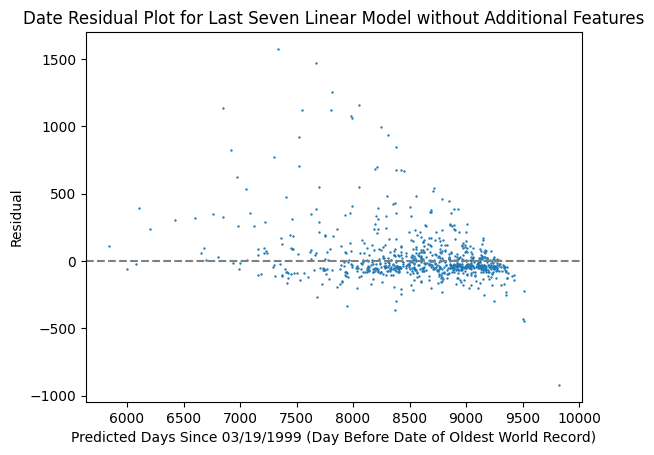

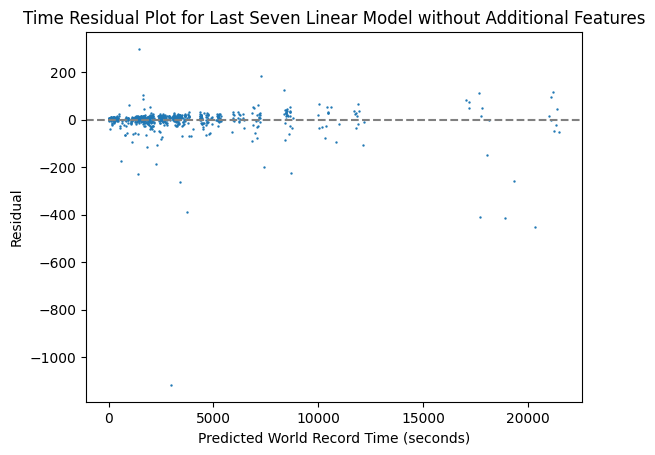

In [38]:
# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 14))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Checks the test input.
# test_input = open("test_input.txt", "w")
# for line in test_x:
#     test_input.write(str(line) + "\n")
# test_input.close()

# Tests the model on all of the test world records.
predicted_y = general_linear_last_7_wr_only.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]

date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Last Seven Linear Model without Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Last Seven Linear Model without Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

In [39]:
# Trains a step through linear model without additional features.

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 14))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# Checks training input.
# training_input = open("training_input.txt", "w")
# for line in training_x:
#     training_input.write(str(line) + "\n")
# training_input.close()

# Trains the model.
general_linear_step_wr_only = linear_regression_model.fit(training_x, training_y)

The date root mean squared error is:	206.2328212312898
The time root mean squared error is:	56.03638522979547
The date mean absolute error is:	98.50763187387012
The time mean absolute error is:	17.699059531818914
The date mean relative error is:	1.1543179017277534%
The time mean relative error is:	1.3188177036820852%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/4164435407.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/4164435407.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


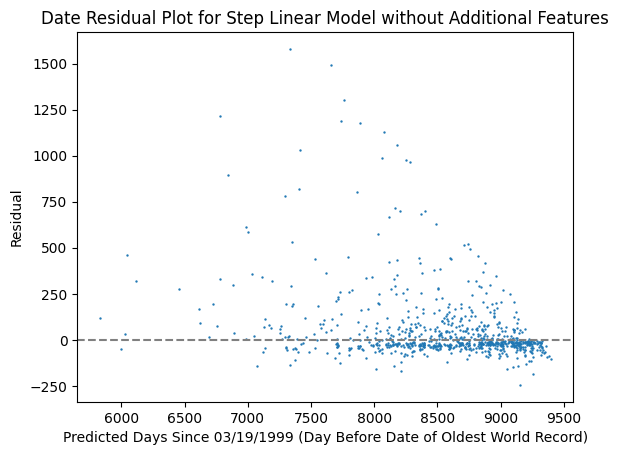

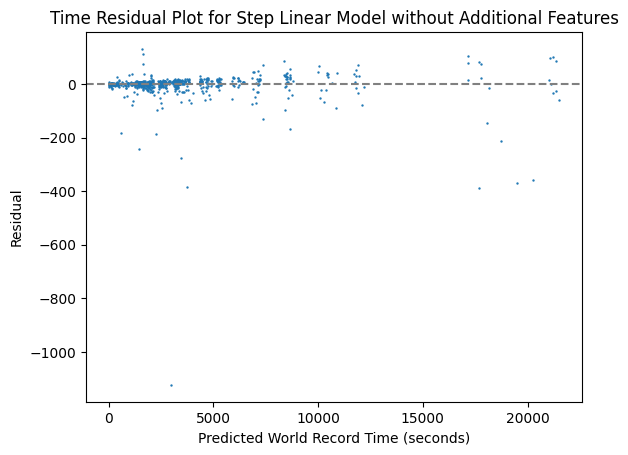

In [41]:
# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 14))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = general_linear_step_wr_only.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Step Linear Model without Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Step Linear Model without Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

                             Date Coefficients  Time Coefficients
Last Record Date                      1.307197          -0.006005
2nd Last Record Date                 -0.615095           0.061958
3rd Last Record Date                  0.355449          -0.042390
4th Last Record Date                 -0.155369          -0.022998
5th Last Record Date                  0.249842          -0.001354
6th Last Record Date                 -0.275932           0.026479
7th Last Record Date                  0.131883          -0.016553
Last Record Time                     -0.945195           1.112465
2nd Last Record Time                  1.067343          -0.037812
3rd Last Record Time                  0.116738           0.172939
4th Last Record Time                  0.201361          -0.335707
5th Last Record Time                 -0.415711          -0.014129
6th Last Record Time                 -0.049065           0.167842
7th Last Record Time                  0.032784          -0.069269
Release Ye

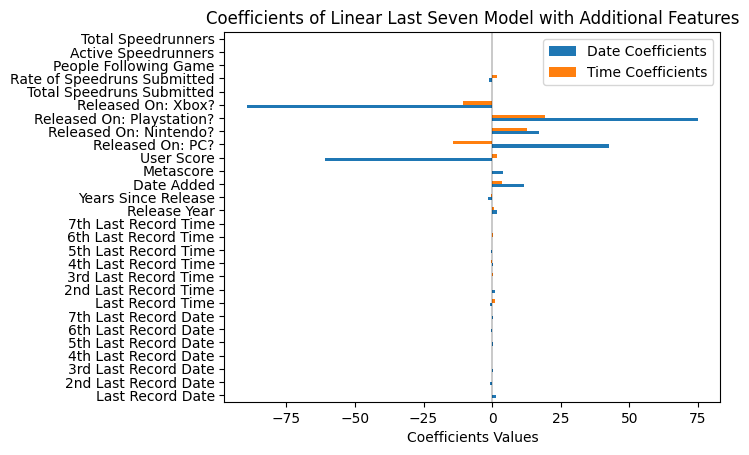

In [42]:
# Last Seven Linear Model with Additional Features

# Creates the training input and output.
training_x = np.zeros((NUM_GAMES, 28))
training_y = np.zeros((NUM_GAMES, 2))
for i in range(NUM_GAMES):
    # Adds the world record data to the training input.
    training_history = training_wr_array[i]
    for j in range(7):
        training_x[i][j] = training_history[-j - 2, 0]
        training_x[i][j + 7] = training_history[-j - 2, 1]

    # Adds the additional features to the training input.
    training_x[i][14] = numerical_training_data[i, 0]
    training_x[i][15] = numerical_training_data[i, 1]
    training_x[i][16] = numerical_training_data[i, 2]
    training_x[i][17] = numerical_training_data[i, 3]
    training_x[i][18] = numerical_training_data[i, 4]
    training_x[i][19] = numerical_training_data[i, 5]
    training_x[i][20] = numerical_training_data[i, 6]
    training_x[i][21] = numerical_training_data[i, 7]
    training_x[i][22] = numerical_training_data[i, 8]
    training_x[i][23] = numerical_training_data[i, 10]
    training_x[i][24] = numerical_training_data[i, 11]
    training_x[i][25] = numerical_training_data[i, 12]
    training_x[i][26] = numerical_training_data[i, 13]
    training_x[i][27] = numerical_training_data[i, 14]

    # Adds the world record data to the training output.
    training_y[i][0] = training_history[-1, 0]
    training_y[i][1] = training_history[-1, 1]

# Trains the model.
general_linear_last_7 = linear_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Years Since Release", "Date Added", "Metascore", "User Score", "Released On: PC?", "Released On: Nintendo?", "Released On: Playstation?", "Released On: Xbox?", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
general_linear_last_7_coefficients = pd.DataFrame((np.transpose(general_linear_last_7.coef_)), columns=output_coefficient_labels, index=feature_labels)
print(general_linear_last_7_coefficients)

# Maps the coefficients of the features.
general_linear_last_7_coefficients.plot.barh()
plt.title("Coefficients of Linear Last Seven Model with Additional Features")
plt.xlabel("Coefficients Values")
plt.axvline(x=0, color="black", linewidth="0.3")

In [43]:
# Creates the test input and actual output for just the first test record of each game.
test_x = np.zeros((NUM_GAMES, 28))
actual_y = np.zeros((NUM_GAMES, 2))
for i in range(NUM_GAMES):
    # Adds the world record data to the test input.
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    for j in range(7):
        test_x[i][j] = training_history[-j - 1, 0]
        test_x[i][j + 7] = training_history[-j - 1, 1]

    # Adds the additional features to the test input.
    test_x[i][14] = numerical_test_data[i, 0]
    test_x[i][15] = numerical_test_data[i, 1]
    test_x[i][16] = numerical_test_data[i, 2]
    test_x[i][17] = numerical_test_data[i, 3]
    test_x[i][18] = numerical_test_data[i, 4]
    test_x[i][19] = numerical_test_data[i, 5]
    test_x[i][20] = numerical_test_data[i, 6]
    test_x[i][21] = numerical_test_data[i, 7]
    test_x[i][22] = numerical_test_data[i, 8]
    test_x[i][23] = numerical_test_data[i, 10]
    test_x[i][24] = numerical_test_data[i, 11]
    test_x[i][25] = numerical_test_data[i, 12]
    test_x[i][26] = numerical_test_data[i, 13]
    test_x[i][27] = numerical_test_data[i, 14]

    # Adds the world record data to the actual output.
    actual_y[i][0] = test_history[0, 0]
    actual_y[i][1] = test_history[0, 1]

# Tests the model on just the first test world records.
predicted_y = general_linear_last_7.predict(test_x)
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(NUM_GAMES):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]
date_mre = date_error_sum / NUM_GAMES
time_mre = time_error_sum / NUM_GAMES

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")

The date root mean squared error is:	206.1412661363329
The time root mean squared error is:	128.70381611148264
The date mean absolute error is:	133.33186957231345
The time mean absolute error is:	39.62595952442075
The date mean relative error is:	1.646985647778666%
The time mean relative error is:	5.057839631972447%


The date root mean squared error is:	222.61277032718533
The time root mean squared error is:	60.13184059977701
The date mean absolute error is:	128.7285761023547
The time mean absolute error is:	22.403615160671237
The date mean relative error is:	1.508592473952164%
The time mean relative error is:	4.291544182496146%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/1775583983.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/1775583983.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


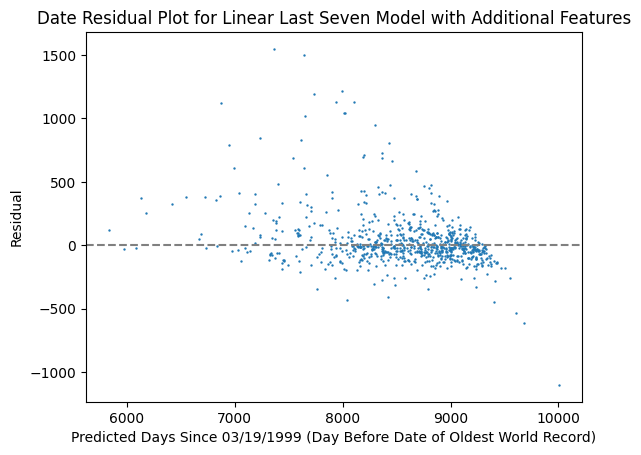

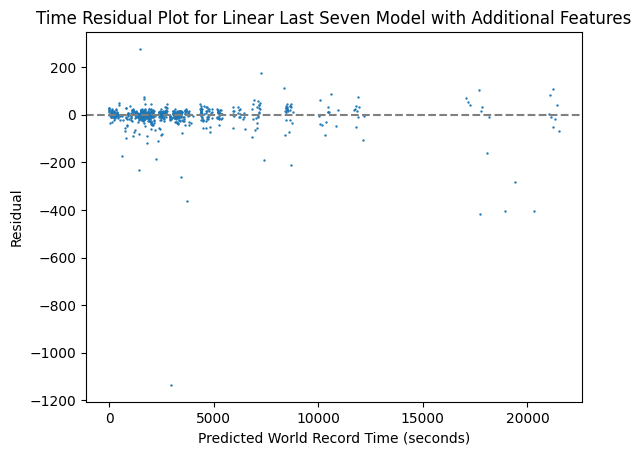

In [44]:
# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 28))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional features to the test input.
        test_x[index][14] = numerical_test_data[i, 0]
        test_x[index][15] = numerical_test_data[i, 1]
        test_x[index][16] = numerical_test_data[i, 2]
        test_x[index][17] = numerical_test_data[i, 3]
        test_x[index][18] = numerical_test_data[i, 4]
        test_x[index][19] = numerical_test_data[i, 5]
        test_x[index][20] = numerical_test_data[i, 6]
        test_x[index][21] = numerical_test_data[i, 7]
        test_x[index][22] = numerical_test_data[i, 8]
        test_x[index][23] = numerical_test_data[i, 10]
        test_x[index][24] = numerical_test_data[i, 11]
        test_x[index][25] = numerical_test_data[i, 12]
        test_x[index][26] = numerical_test_data[i, 13]
        test_x[index][27] = numerical_test_data[i, 14]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Checks the test input.
# test_input = open("test_input.txt", "w")
# for line in test_x:
#     test_input.write(str(line) + "\n")
# test_input.close()

# Tests the model on just the test world records.
predicted_y = general_linear_last_7.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Linear Last Seven Model with Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Linear Last Seven Model with Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

                      Date Coefficients  Time Coefficients
Last Record Date               1.270726          -0.008367
2nd Last Record Date          -0.479509           0.049500
3rd Last Record Date           0.227860          -0.041611
4th Last Record Date          -0.073765          -0.007554
5th Last Record Date           0.172463           0.007576
6th Last Record Date          -0.238294           0.016279
7th Last Record Date           0.106149          -0.018789
Last Record Time              -0.760320           1.153626
2nd Last Record Time           0.705821          -0.123204
3rd Last Record Time           0.328158           0.223677
4th Last Record Time           0.118842          -0.336842
5th Last Record Time          -0.412752          -0.027566
6th Last Record Time           0.021257           0.182224
7th Last Record Time           0.004197          -0.075019
Total Speedrunners            -0.006294           0.000697


The date root mean squared error is:	212.0261665868911

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/4119204286.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/4119204286.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


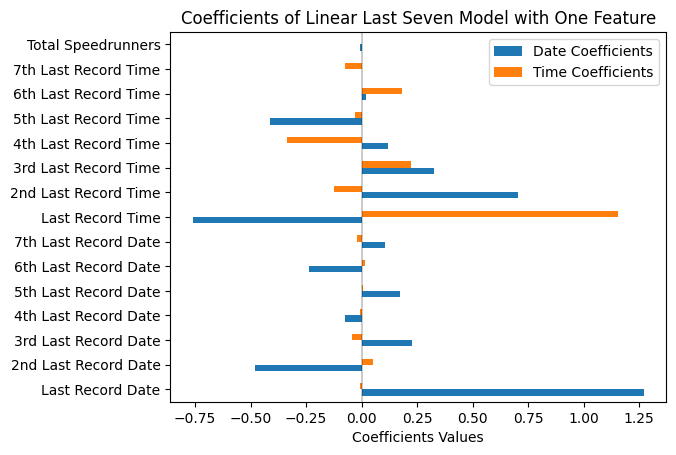

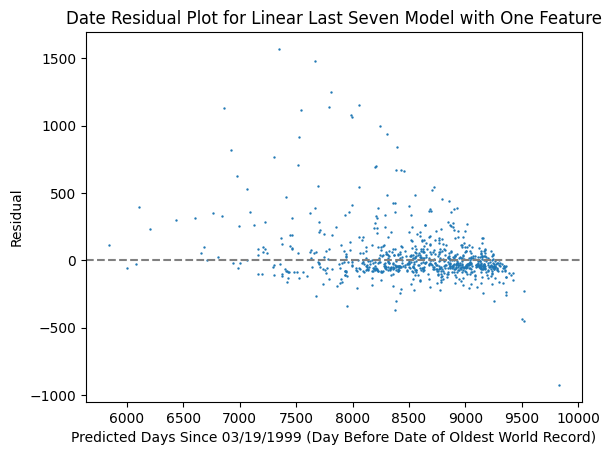

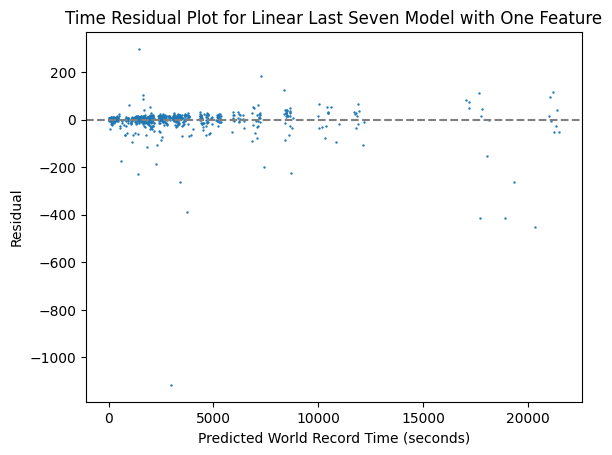

In [45]:
# Trains the linear last seven model only using one additional feature to determine which
# coefficients are the most impactful.

FEATURE_INDEX = 14

# Creates the training input and output.
training_x = np.zeros((NUM_GAMES, 15))
training_y = np.zeros((NUM_GAMES, 2))
for i in range(NUM_GAMES):
    # Adds the world record data to the training input.
    training_history = training_wr_array[i]
    for j in range(7):
        training_x[i][j] = training_history[-j - 2, 0]
        training_x[i][j + 7] = training_history[-j - 2, 1]

    # Adds the additional features to the training input.
    training_x[i][14] = numerical_training_data[i, FEATURE_INDEX]

    # Adds the world record data to the training output.
    training_y[i][0] = training_history[-1, 0]
    training_y[i][1] = training_history[-1, 1]

# Trains the model.
one_feature_general_linear_last_7 = linear_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Years Since Release", "Date Added", "Metascore", "User Score", "Released On: PC?", "Released On: Nintendo?", "Released On: Playstation?", "Released On: Xbox?", "World Record History", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
used_feature_labels = feature_labels[:15].copy()
used_feature_labels[14] = feature_labels[14 + FEATURE_INDEX]
one_feature_general_linear_last_7_coefficients = pd.DataFrame((np.transpose(one_feature_general_linear_last_7.coef_)), columns=output_coefficient_labels, index=used_feature_labels)
print(one_feature_general_linear_last_7_coefficients)

# Maps the coefficients of the features.
one_feature_general_linear_last_7_coefficients.plot.barh()
plt.title("Coefficients of Linear Last Seven Model with One Feature")
plt.xlabel("Coefficients Values")
plt.axvline(x=0, color="black", linewidth="0.3")


print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 15))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional features to the test input.
        test_x[index][14] = numerical_test_data[i, FEATURE_INDEX]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Checks the test input.
# test_input = open("test_input.txt", "w")
# for line in test_x:
#     test_input.write(str(line) + "\n")
# test_input.close()

# Tests the model on just the test world records.
predicted_y =  one_feature_general_linear_last_7.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Linear Last Seven Model with One Feature")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Linear Last Seven Model with One Feature")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

                           Date Coefficients  Time Coefficients
Last Record Date                    1.280096          -0.008152
2nd Last Record Date               -0.498402           0.050028
3rd Last Record Date                0.240727          -0.040047
4th Last Record Date               -0.080491          -0.009824
5th Last Record Date                0.165079           0.009816
6th Last Record Date               -0.230487           0.013416
7th Last Record Date                0.107567          -0.018527
Last Record Time                   -0.865831           1.163559
2nd Last Record Time                0.802289          -0.132210
3rd Last Record Time                0.369381           0.225580
4th Last Record Time                0.143099          -0.346758
5th Last Record Time               -0.470378          -0.020407
6th Last Record Time                0.018557           0.183343
7th Last Record Time                0.008077          -0.076069
Release Year                        0.06

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/1340910402.py:120: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/1340910402.py:128: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


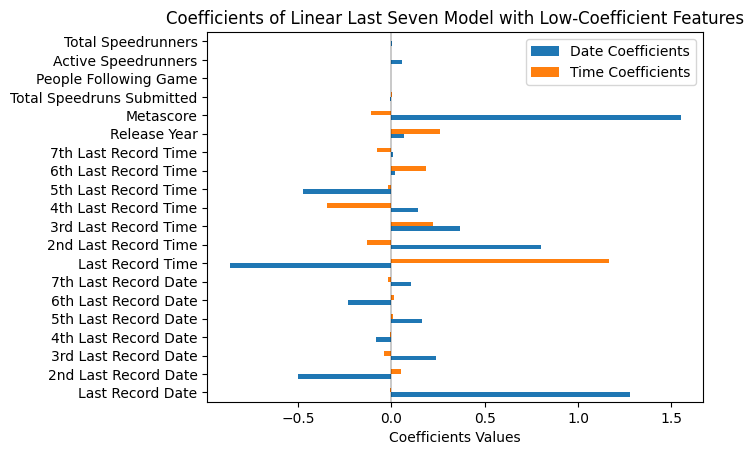

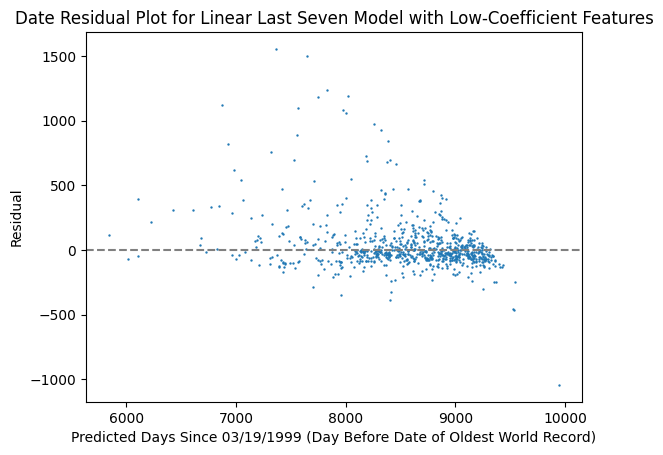

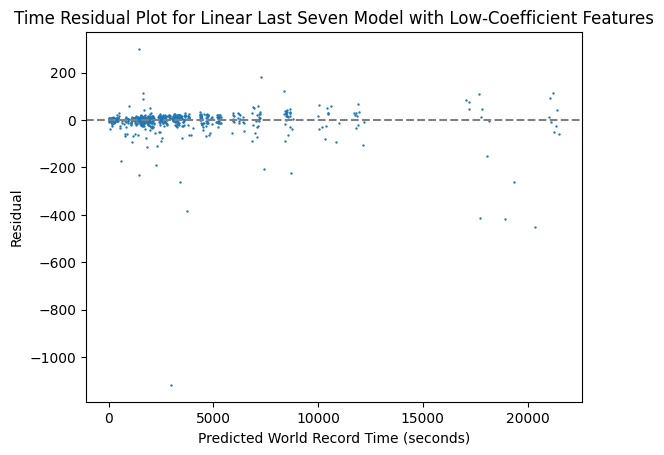

In [46]:
# Trains a last seven model with only low-value features to see if it performs better
# without outliars.

# Creates the training input and output.
training_x = np.zeros((NUM_GAMES, 20))
training_y = np.zeros((NUM_GAMES, 2))
for i in range(NUM_GAMES):
    # Adds the world record data to the training input.
    training_history = training_wr_array[i]
    for j in range(7):
        training_x[i][j] = training_history[-j - 2, 0]
        training_x[i][j + 7] = training_history[-j - 2, 1]

    # Adds the additional features to the training input.
    training_x[i][14] = numerical_training_data[i, 0]
    training_x[i][15] = numerical_training_data[i, 3]
    training_x[i][16] = numerical_training_data[i, 10]
    training_x[i][17] = numerical_training_data[i, 12]
    training_x[i][18] = numerical_training_data[i, 13]
    training_x[i][19] = numerical_training_data[i, 14]

    # Adds the world record data to the training output.
    training_y[i][0] = training_history[-1, 0]
    training_y[i][1] = training_history[-1, 1]

# Trains the model.
general_linear_last_7 = linear_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Metascore", "Total Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
general_linear_last_7_coefficients = pd.DataFrame((np.transpose(general_linear_last_7.coef_)), columns=output_coefficient_labels, index=feature_labels)
print(general_linear_last_7_coefficients)

# Maps the coefficients of the features.
general_linear_last_7_coefficients.plot.barh()
plt.title("Coefficients of Linear Last Seven Model with Low-Coefficient Features")
plt.xlabel("Coefficients Values")
plt.axvline(x=0, color="black", linewidth="0.3")


print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 20))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional features to the test input.
        test_x[index][14] = numerical_test_data[i, 0]
        test_x[index][15] = numerical_test_data[i, 3]
        test_x[index][16] = numerical_test_data[i, 10]
        test_x[index][17] = numerical_test_data[i, 12]
        test_x[index][18] = numerical_test_data[i, 13]
        test_x[index][19] = numerical_test_data[i, 14]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Checks the test input.
# test_input = open("test_input.txt", "w")
# for line in test_x:
#     test_input.write(str(line) + "\n")
# test_input.close()

# Tests the model on just the test world records.
predicted_y =  one_feature_general_linear_last_7.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Linear Last Seven Model with Low-Coefficient Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Linear Last Seven Model with Low-Coefficient Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

                             Date Coefficients  Time Coefficients
Last Record Date                      1.067929           0.007879
2nd Last Record Date                 -0.091719          -0.000507
3rd Last Record Date                  0.132226          -0.002023
4th Last Record Date                 -0.111927          -0.008067
5th Last Record Date                  0.030367           0.019331
6th Last Record Date                 -0.020870          -0.017635
7th Last Record Date                 -0.009897           0.005072
Last Record Time                     -0.169220           1.156363
2nd Last Record Time                  0.206069          -0.048057
3rd Last Record Time                 -0.073813          -0.061482
4th Last Record Time                  0.087479          -0.050675
5th Last Record Time                 -0.040660           0.007010
6th Last Record Time                 -0.011068           0.019226
7th Last Record Time                  0.000539          -0.025978
Release Ye

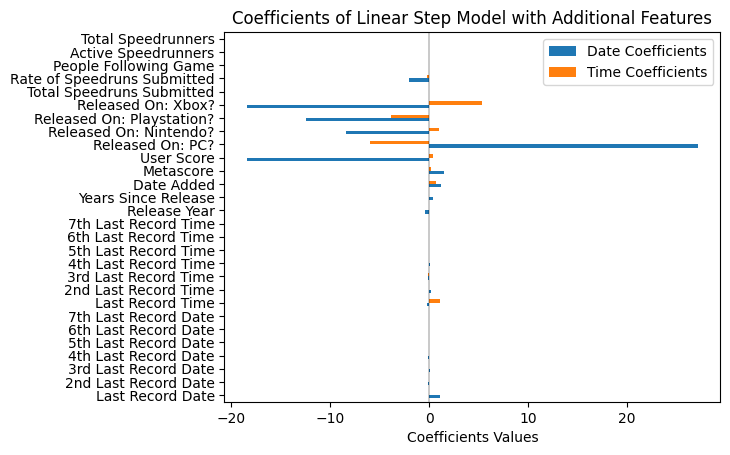

In [48]:
# Trains a step through linear model with additional features.

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 28))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the additional features to the training input.
        training_x[index][14] = numerical_training_data[i, 0]
        training_x[index][15] = numerical_training_data[i, 1]
        training_x[index][16] = numerical_training_data[i, 2]
        training_x[index][17] = numerical_training_data[i, 3]
        training_x[index][18] = numerical_training_data[i, 4]
        training_x[index][19] = numerical_training_data[i, 5]
        training_x[index][20] = numerical_training_data[i, 6]
        training_x[index][21] = numerical_training_data[i, 7]
        training_x[index][22] = numerical_training_data[i, 8]
        training_x[index][23] = numerical_training_data[i, 10]
        training_x[index][24] = numerical_training_data[i, 11]
        training_x[index][25] = numerical_training_data[i, 12]
        training_x[index][26] = numerical_training_data[i, 13]
        training_x[index][27] = numerical_training_data[i, 14]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# Checks the training input.
# training_input = open("training_input.txt", "w")
# for line in training_x:
#     training_input.write(str(line) + "\n")
# training_input.close()

# Trains the model.
general_linear_step = linear_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Years Since Release", "Date Added", "Metascore", "User Score", "Released On: PC?", "Released On: Nintendo?", "Released On: Playstation?", "Released On: Xbox?", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
general_linear_step_coefficients = pd.DataFrame((np.transpose(general_linear_step.coef_)), columns=output_coefficient_labels, index=feature_labels)
print(general_linear_step_coefficients)

# Maps the coefficients of the features.
general_linear_step_coefficients.plot.barh()
plt.title("Coefficients of Linear Step Model with Additional Features")
plt.xlabel("Coefficients Values")
plt.axvline(x=0, color="black", linewidth="0.3")

The date root mean squared error is:	205.0655800704536
The time root mean squared error is:	56.17280509733137
The date mean absolute error is:	99.74767868854121
The time mean absolute error is:	17.48040912951715
The date mean relative error is:	1.1676220037725602%
The time mean relative error is:	1.5079482063569059%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/865591089.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/865591089.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


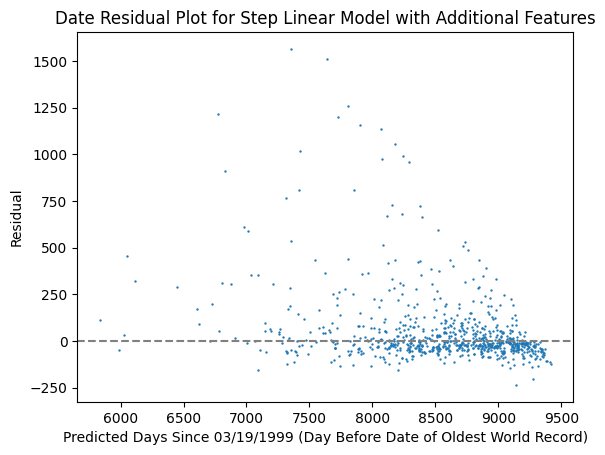

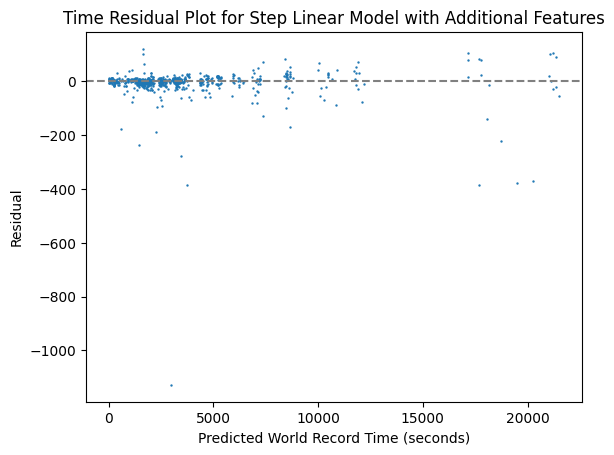

In [49]:
# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 28))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional features to the test input.
        test_x[index][14] = numerical_test_data[i, 0]
        test_x[index][15] = numerical_test_data[i, 1]
        test_x[index][16] = numerical_test_data[i, 2]
        test_x[index][17] = numerical_test_data[i, 3]
        test_x[index][18] = numerical_test_data[i, 4]
        test_x[index][19] = numerical_test_data[i, 5]
        test_x[index][20] = numerical_test_data[i, 6]
        test_x[index][21] = numerical_test_data[i, 7]
        test_x[index][22] = numerical_test_data[i, 8]
        test_x[index][23] = numerical_test_data[i, 10]
        test_x[index][24] = numerical_test_data[i, 11]
        test_x[index][25] = numerical_test_data[i, 12]
        test_x[index][26] = numerical_test_data[i, 13]
        test_x[index][27] = numerical_test_data[i, 14]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = general_linear_step.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Step Linear Model with Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Step Linear Model with Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

                      Date Coefficients  Time Coefficients
Last Record Date               1.083356           0.007955
2nd Last Record Date          -0.093223          -0.001182
3rd Last Record Date           0.131188          -0.001432
4th Last Record Date          -0.113489          -0.008042
5th Last Record Date           0.030123           0.020088
6th Last Record Date          -0.024141          -0.018268
7th Last Record Date          -0.023349           0.002613
Last Record Time              -0.174841           1.161729
2nd Last Record Time           0.214135          -0.048262
3rd Last Record Time          -0.075291          -0.063116
4th Last Record Time           0.089328          -0.053554
5th Last Record Time          -0.038458           0.007002
6th Last Record Time          -0.017146           0.018274
7th Last Record Time           0.001369          -0.025329
Total Speedrunners            -0.003756           0.000298


The date root mean squared error is:	206.0431972681193

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2382997300.py:126: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2382997300.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


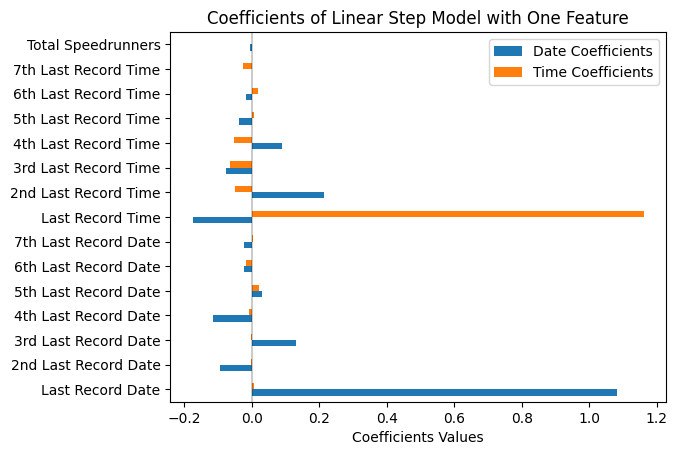

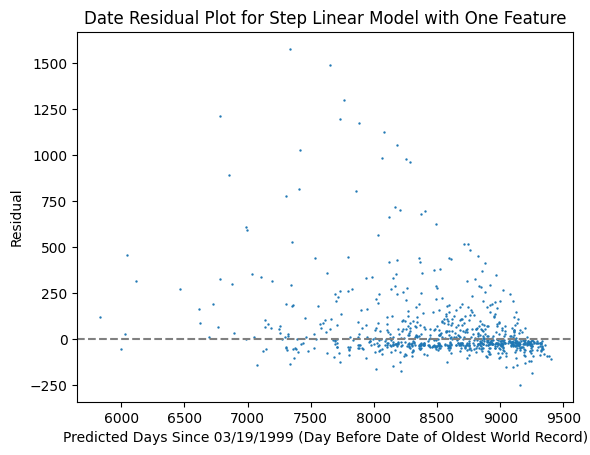

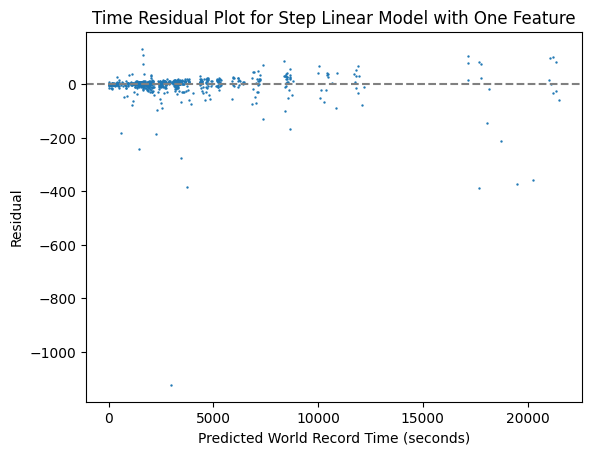

In [51]:
# Checks the importance of various features for the linear step through model by trying
# each feature one-by-one and seeing which accuracy is the best at the end

FEATURE_INDEX = 14

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 15))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the additional feature to the training input.
        training_x[index][14] = numerical_training_data[i, FEATURE_INDEX]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# Checks the training input.
# training_input = open("training_input.txt", "w")
# for line in training_x:
#     training_input.write(str(line) + "\n")
# training_input.close()

# Trains the model.
one_feature_general_linear_step = linear_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Years Since Release", "Date Added", "Metascore", "User Score", "Released On: PC?", "Released On: Nintendo?", "Released On: Playstation?", "Released On: Xbox?", "World Record History", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
used_feature_labels = feature_labels[:15].copy()
used_feature_labels[14] = feature_labels[14 + FEATURE_INDEX]
one_feature_general_linear_step_coefficients = pd.DataFrame((np.transpose(one_feature_general_linear_step.coef_)), columns=output_coefficient_labels, index=used_feature_labels)
print(one_feature_general_linear_step_coefficients)

# Maps the coefficients of the features.
one_feature_general_linear_step_coefficients.plot.barh()
plt.title("Coefficients of Linear Step Model with One Feature")
plt.xlabel("Coefficients Values")
plt.axvline(x=0, color="black", linewidth="0.3")


print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 15))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional feature to the test input.
        test_x[index][14] = numerical_test_data[i, FEATURE_INDEX]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = one_feature_general_linear_step.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
# print("The root mean squared error is:\t\t" + str(metrics.root_mean_squared_error(actual_outputs, predicted_outputs)))
# print("The mean absolute error is:\t\t" + str(metrics.mean_absolute_error(actual_outputs, predicted_outputs)))
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Step Linear Model with One Feature")
# date_residual_axes.set_xlim(4000, 10000)
# date_residual_axes.set_ylim(-100, 30000)
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Step Linear Model with One Feature")
# time_residual_axes.set_xlim(4000, 10000)
# time_residual_axes.set_ylim(-100, 30000)
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()


                       Date Coefficients  Time Coefficients
Last Record Date                1.075815           0.008028
2nd Last Record Date           -0.092060          -0.001127
3rd Last Record Date            0.130695          -0.001510
4th Last Record Date           -0.112975          -0.008038
5th Last Record Date            0.026988           0.020124
6th Last Record Date           -0.022643          -0.018288
7th Last Record Date           -0.016465           0.002601
Last Record Time               -0.173940           1.160550
2nd Last Record Time            0.215755          -0.047975
3rd Last Record Time           -0.074353          -0.062710
4th Last Record Time            0.087580          -0.053119
5th Last Record Time           -0.040305           0.006956
6th Last Record Time           -0.018006           0.018489
7th Last Record Time            0.002076          -0.025484
Metascore                       1.240408           0.167853
People Following Game          -0.004164

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3695469707.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3695469707.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


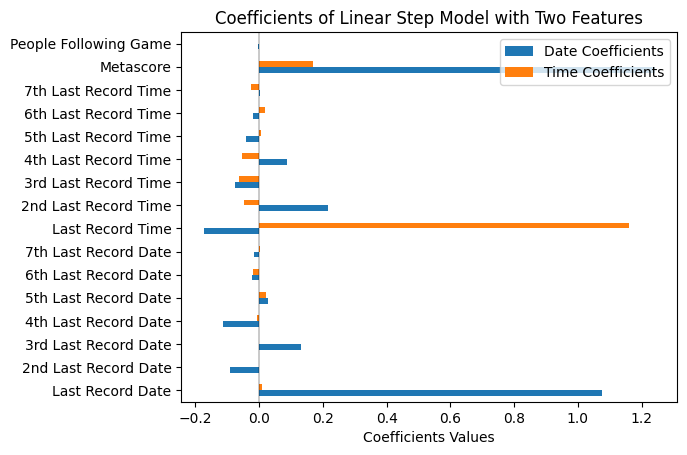

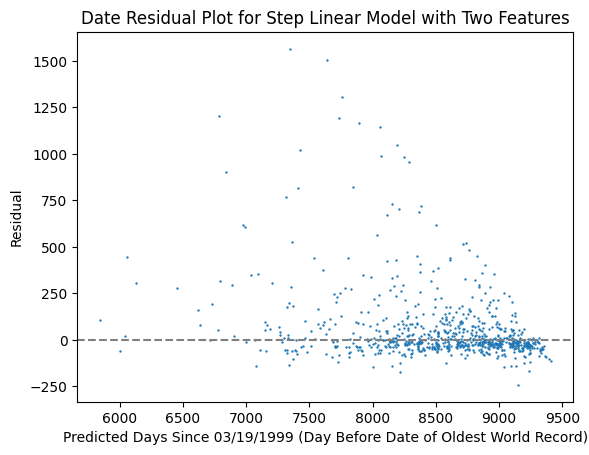

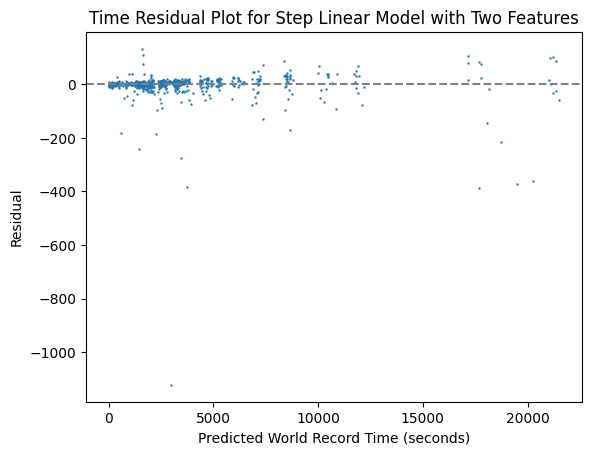

In [52]:
# Attempts to combine features in varying levels of importance in the step through
# linear model.

FEATURE_INDEX_ONE = 3
FEATURE_INDEX_TWO = 12

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 16))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the additional feature to the training input.
        training_x[index][14] = numerical_training_data[i, FEATURE_INDEX_ONE]
        training_x[index][15] = numerical_training_data[i, FEATURE_INDEX_TWO]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# training_input = open("training_input.txt", "w")
# for line in training_x:
#     training_input.write(str(line) + "\n")
# training_input.close()

# Trains the model.
one_feature_general_linear_step = linear_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Years Since Release", "Date Added", "Metascore", "User Score", "Released On: PC?", "Released On: Nintendo?", "Released On: Playstation?", "Released On: Xbox?", "World Record History", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
used_feature_labels = feature_labels[:16].copy()
used_feature_labels[14] = feature_labels[14 + FEATURE_INDEX_ONE]
used_feature_labels[15] = feature_labels[14 + FEATURE_INDEX_TWO]
one_feature_general_linear_step_coefficients = pd.DataFrame((np.transpose(one_feature_general_linear_step.coef_)), columns=output_coefficient_labels, index=used_feature_labels)
print(one_feature_general_linear_step_coefficients)

# Maps the coefficients of the features.
one_feature_general_linear_step_coefficients.plot.barh()
plt.title("Coefficients of Linear Step Model with Two Features")
plt.xlabel("Coefficients Values")
plt.axvline(x=0, color="black", linewidth="0.3")


print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 16))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional feature to the test input.
        test_x[index][14] = numerical_test_data[i, FEATURE_INDEX_ONE]
        test_x[index][15] = numerical_test_data[i, FEATURE_INDEX_TWO]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = one_feature_general_linear_step.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
# print("The root mean squared error is:\t\t" + str(metrics.root_mean_squared_error(actual_outputs, predicted_outputs)))
# print("The mean absolute error is:\t\t" + str(metrics.mean_absolute_error(actual_outputs, predicted_outputs)))
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Step Linear Model with Two Features")
# date_residual_axes.set_xlim(4000, 10000)
# date_residual_axes.set_ylim(-100, 30000)
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Step Linear Model with Two Features")
# time_residual_axes.set_xlim(4000, 10000)
# time_residual_axes.set_ylim(-100, 30000)
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

                             Date Coefficients  Time Coefficients
Last Record Date                      1.073866           0.007713
2nd Last Record Date                 -0.091351          -0.000605
3rd Last Record Date                  0.130171          -0.001731
4th Last Record Date                 -0.112515          -0.007865
5th Last Record Date                  0.025899           0.020092
6th Last Record Date                 -0.021016          -0.017823
7th Last Record Date                 -0.010856           0.004099
Last Record Time                     -0.175016           1.158112
2nd Last Record Time                  0.212425          -0.048766
3rd Last Record Time                 -0.074579          -0.062232
4th Last Record Time                  0.087826          -0.051747
5th Last Record Time                 -0.040140           0.007184
6th Last Record Time                 -0.013145           0.020000
7th Last Record Time                  0.001104          -0.026054
Release Ye

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/778051723.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/778051723.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


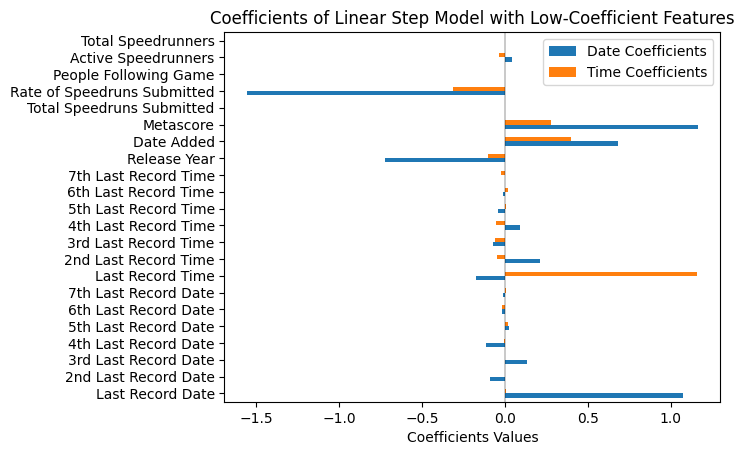

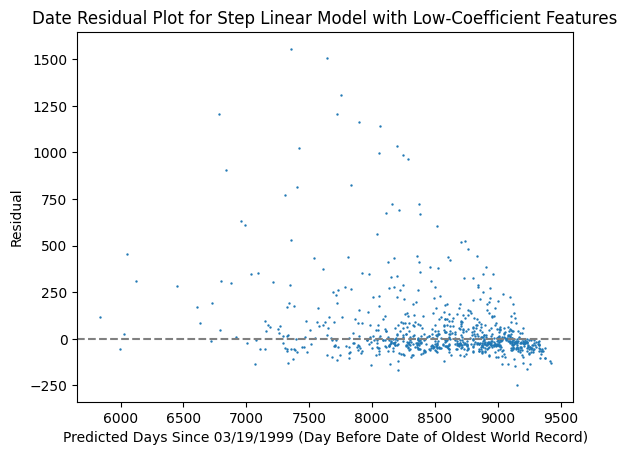

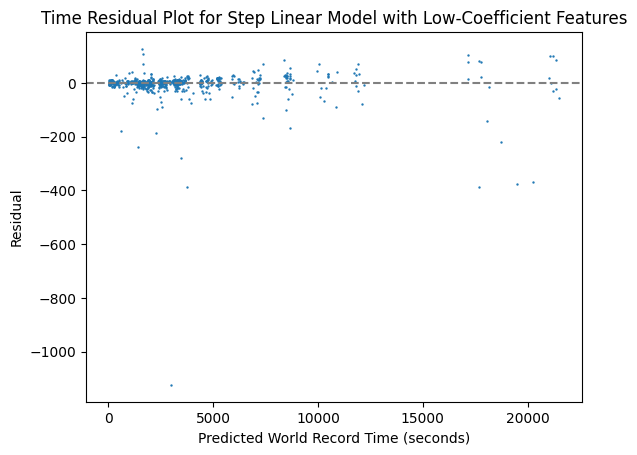

In [53]:
# Trains a linear step model using additional features without strong coefficients which
# could be outliars.

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 22))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the additional features to the training input.
        training_x[index][14] = numerical_training_data[i, 0]
        training_x[index][15] = numerical_training_data[i, 2]
        training_x[index][16] = numerical_training_data[i, 3]
        training_x[index][17] = numerical_training_data[i, 10]
        training_x[index][18] = numerical_training_data[i, 11]
        training_x[index][19] = numerical_training_data[i, 12]
        training_x[index][20] = numerical_training_data[i, 13]
        training_x[index][21] = numerical_training_data[i, 14]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# Checks training input.
# training_input = open("training_input.txt", "w")
# for line in training_x:
#     training_input.write(str(line) + "\n")
# training_input.close()

# Trains the model.
general_linear_step = linear_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Date Added", "Metascore", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
general_linear_step_coefficients = pd.DataFrame((np.transpose(general_linear_step.coef_)), columns=output_coefficient_labels, index=feature_labels)
print(general_linear_step_coefficients)

# Maps the coefficients of the features.
general_linear_step_coefficients.plot.barh()
plt.title("Coefficients of Linear Step Model with Low-Coefficient Features")
plt.xlabel("Coefficients Values")
plt.axvline(x=0, color="black", linewidth="0.3")


print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 22))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional features to the test input.
        test_x[index][14] = numerical_test_data[i, 0]
        test_x[index][15] = numerical_test_data[i, 2]
        test_x[index][16] = numerical_test_data[i, 3]
        test_x[index][17] = numerical_test_data[i, 10]
        test_x[index][18] = numerical_test_data[i, 11]
        test_x[index][19] = numerical_test_data[i, 12]
        test_x[index][20] = numerical_test_data[i, 13]
        test_x[index][21] = numerical_test_data[i, 14]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = general_linear_step.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
# print("The root mean squared error is:\t\t" + str(metrics.root_mean_squared_error(actual_outputs, predicted_outputs)))
# print("The mean absolute error is:\t\t" + str(metrics.mean_absolute_error(actual_outputs, predicted_outputs)))
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Step Linear Model with Low-Coefficient Features")
# date_residual_axes.set_xlim(4000, 10000)
# date_residual_axes.set_ylim(-100, 30000)
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Step Linear Model with Low-Coefficient Features")
# time_residual_axes.set_xlim(4000, 10000)
# time_residual_axes.set_ylim(-100, 30000)
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

In [54]:
# Performs the last seven lasso model without additional features
# repeatedly with different values of alpha to find the optimal one for both the
# time mean absolute error and the date mean absolute error.
# (The values iterated through have been changed to make running the code faster,
# but the best performing values are listed at the bottom of the cell,)

best_date_alpha = -1
best_time_alpha = -1
best_date_mae = -1
best_time_mae = -1

for a in range(10):
    # Creates the training input and output.
    training_x = np.zeros((NUM_GAMES, 14))
    training_y = np.zeros((NUM_GAMES, 2))
    for i in range(NUM_GAMES):
        # Adds the world record data to the training input.
        training_history = training_wr_array[i]
        for j in range(7):
            training_x[i][j] = training_history[-j - 2, 0]
            training_x[i][j + 7] = training_history[-j - 2, 1]

        # Adds the world record data to the training output.
        training_y[i][0] = training_history[-1, 0]
        training_y[i][1] = training_history[-1, 1]

    # Trains the model.
    ALPHA_VALUE = a
    lasso_regression_model = linear_model.Lasso(alpha=ALPHA_VALUE)
    wr_only_general_lasso_last_7 = lasso_regression_model.fit(training_x, training_y)

    # Creates the test input and actual output for all test records.
    test_x = np.zeros((795, 14))
    actual_y = np.zeros((795, 2))
    index = 0
    for i in range(NUM_GAMES):
        training_history = training_wr_array[i]
        test_history = test_wr_array[i]
        num_test_records = len(test_history)
        for j in range(num_test_records):
            # Adds the world record data to the test input.
            for k in range(7):
                away_from_end = num_test_records - j + 1 + k
                if (away_from_end) <= num_test_records:
                    test_x[index][k] = test_history[-away_from_end, 0]
                    test_x[index][k + 7] = test_history[-away_from_end, 1]
                else:
                    test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                    test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

            # Adds the world record data to the actual output.
            actual_y[index][0] = test_history[j, 0]
            actual_y[index][1] = test_history[j, 1]

            index += 1

    # Tests the model on just the test world records.
    predicted_y = wr_only_general_lasso_last_7.predict(test_x)
    date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
    time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])

    # Sets the alpha values if the errors are better for a given value of alpha.
    if (a == 0):
        best_date_alpha = a
        best_time_alpha = a
        best_date_mae = date_mae
        best_time_mae = time_mae

    if (best_date_mae > date_mae):
        best_date_alpha = a
        best_date_mae = date_mae

    if (best_time_mae > time_mae):
        best_time_alpha = a
        best_time_mae = time_mae

print("The best value of alpha for the date is [ " + str(best_date_alpha) + " ] with an MAE of [ " + str(best_date_mae) + " ] .")
print("The best value of alpha for the time is [ " + str(best_time_alpha) + " ] with an MAE of [ " + str(best_time_mae) + " ] .")
# The best date alpha was determined to be 29852.
# The best time alpha was determined to be 2495.

The best value of alpha for the date is [ 9 ] with an MAE of [ 113.13249504111609 ] .
The best value of alpha for the time is [ 9 ] with an MAE of [ 20.25393571494686 ] .


/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 

The date root mean squared error is:	201.44160505949978
The time root mean squared error is:	58.399018885533344
The date mean absolute error is:	105.63063259642654
The time mean absolute error is:	18.767762728847377
The date mean relative error is:	1.2358778065711709%
The time mean relative error is:	1.0079857008622775%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2112689764.py:92: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2112689764.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


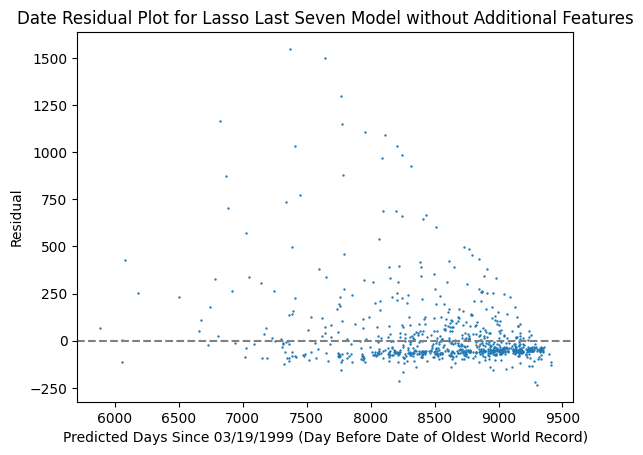

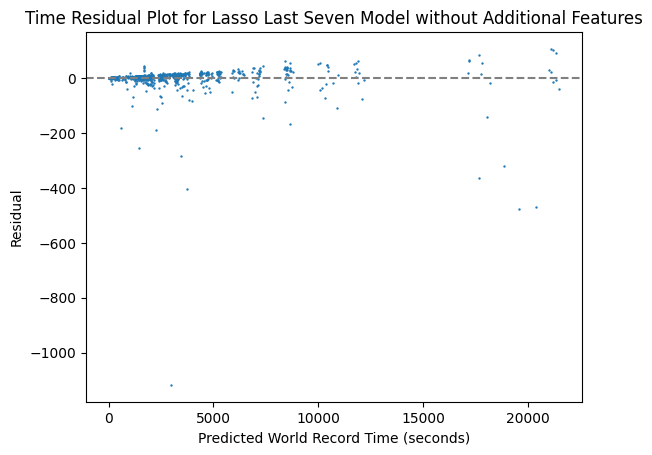

In [55]:
# Trains a last seven model with lasso regression without additional features on
# the determined best alpha for the time error.

# Creates the training input and output.
training_x = np.zeros((NUM_GAMES, 28))
training_y = np.zeros((NUM_GAMES, 2))
for i in range(NUM_GAMES):
    # Adds the world record data to the training input.
    training_history = training_wr_array[i]
    for j in range(7):
        training_x[i][j] = training_history[-j - 2, 0]
        training_x[i][j + 7] = training_history[-j - 2, 1]

    # Adds the world record data to the training output.
    training_y[i][0] = training_history[-1, 0]
    training_y[i][1] = training_history[-1, 1]

# Trains the model.
ALPHA_VALUE = 2495
lasso_regression_model = linear_model.Lasso(alpha=ALPHA_VALUE)
wr_only_general_lasso_last_7 = lasso_regression_model.fit(training_x, training_y)


# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 28))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Checks the test input.
# test_input = open("test_input.txt", "w")
# for line in test_x:
#     test_input.write(str(line) + "\n")
# test_input.close()

# Tests the model on just the test world records.
predicted_y =  wr_only_general_lasso_last_7.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Lasso Last Seven Model without Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Lasso Last Seven Model without Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

In [56]:
# Performs the step model with lasso regression repeatedly without additional features
# with different values of alpha to find the optimal one for both the time mean absolute
# error and the date mean absolute error.

best_date_alpha = -1
best_time_alpha = -1
best_date_mae = -1
best_time_mae = -1

for a in range(10):
    # 2982 is the total number of training records, but 7 is subtracted from the total
    # number of samples for each game because there must be at least 7 games for the
    # first training input point.
    training_x = np.zeros((2982 - (7 * NUM_GAMES), 14))
    training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
    index = 0
    for i in range(NUM_GAMES):
        training_history = training_wr_array[i]
        num_training_records = len(training_history)
        for j in range(7, num_training_records):
            # Adds the world record data to the training input.
            for k in range(7):
                away_from_end = num_training_records - j + 1 + k
                training_x[index][k] = training_history[-away_from_end, 0]
                training_x[index][k + 7] = training_history[-away_from_end, 1]

            # Adds the world record data to the actual output.
            training_y[index][0] = training_history[j, 0]
            training_y[index][1] = training_history[j, 1]

            index += 1

    # Checks the training input.
    # training_input = open("training_input.txt", "w")
    # for line in training_x:
    #     training_input.write(str(line) + "\n")
    # training_input.close()

    # Trains the model.
    ALPHA_VALUE = a
    lasso_regression_model = linear_model.Lasso(alpha=ALPHA_VALUE)
    wr_only_general_lasso_step = lasso_regression_model.fit(training_x, training_y)

    # Creates the test input and actual output for all test records.
    test_x = np.zeros((795, 14))
    actual_y = np.zeros((795, 2))
    index = 0
    for i in range(NUM_GAMES):
        training_history = training_wr_array[i]
        test_history = test_wr_array[i]
        num_test_records = len(test_history)
        for j in range(num_test_records):
            # Adds the world record data to the test input.
            for k in range(7):
                away_from_end = num_test_records - j + 1 + k
                if (away_from_end) <= num_test_records:
                    test_x[index][k] = test_history[-away_from_end, 0]
                    test_x[index][k + 7] = test_history[-away_from_end, 1]
                else:
                    test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                    test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

            # Adds the world record data to the actual output.
            actual_y[index][0] = test_history[j, 0]
            actual_y[index][1] = test_history[j, 1]

            index += 1

    # Tests the model on just the test world records.
    predicted_y = wr_only_general_lasso_step.predict(test_x)
    date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
    time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])

    # Sets the alpha values if the errors are better for a given value of alpha.
    if (a == 0):
        best_date_alpha = a
        best_time_alpha = a
        best_date_mae = date_mae
        best_time_mae = time_mae

    if (best_date_mae > date_mae):
        best_date_alpha = a
        best_date_mae = date_mae

    if (best_time_mae > time_mae):
        best_time_alpha = a
        best_time_mae = time_mae

print()
print()
print("The best value of alpha for the date is [ " + str(best_date_alpha) + " ] with an MAE of [ " + str(best_date_mae) + " ] .")
print("The best value of alpha for the time is [ " + str(best_time_alpha) + " ] with an MAE of [ " + str(best_time_mae) + " ] .")
# The best date alpha was determined to be 8064.
# The best time alpha was determined to be 68.

/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 



The best value of alpha for the date is [ 9 ] with an MAE of [ 98.72011794507765 ] .
The best value of alpha for the time is [ 0 ] with an MAE of [ 17.773318809902992 ] .


/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e+07, tolerance: 1.705e+05
  model = cd_fast.enet_coordinate_descent(


The date root mean squared error is:	206.86311989368795
The time root mean squared error is:	56.262392983678644
The date mean absolute error is:	98.41631887481239
The time mean absolute error is:	17.591764207593872
The date mean relative error is:	1.1531545386661144%
The time mean relative error is:	1.205363286755733%


/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.100e+07, tolerance: 1.705e+05
  model = cd_fast.enet_coordinate_descent(
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2238236406.py:99: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2238236406.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


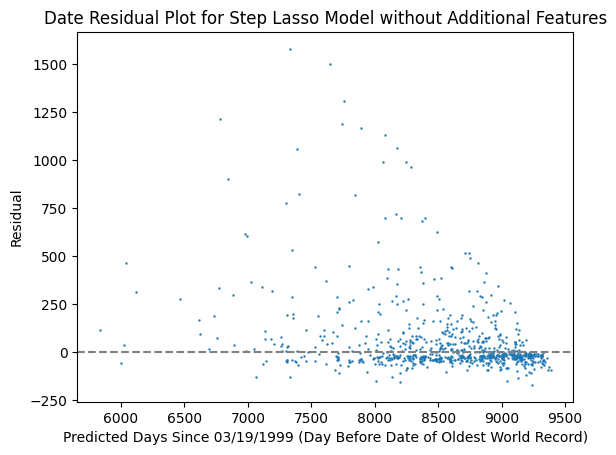

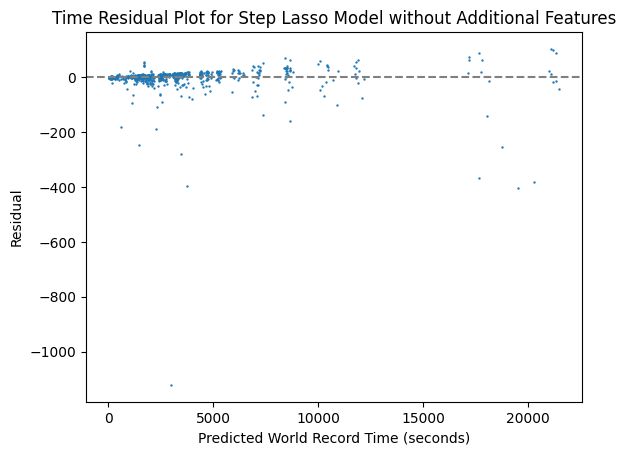

In [57]:
# Performs the step model with lasso regression without additional features using
# the optimal values for alpha determined in the previous cell.

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 14))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# Checks the training input.
# training_input = open("training_input.txt", "w")
# for line in training_x:
#     training_input.write(str(line) + "\n")
# training_input.close()

# Trains the model.
ALPHA_VALUE = 68
lasso_regression_model = linear_model.Lasso(alpha=ALPHA_VALUE)
wr_only_general_lasso_step = lasso_regression_model.fit(training_x, training_y)


# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 14))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = wr_only_general_lasso_step.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")

# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Step Lasso Model without Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Step Lasso Model without Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

In [58]:
# Performs the last seven model with lasso regression with additional features
# repeatedly with different values of alpha to find the optimal one for both the
# time mean absolute error and the date mean absolute error.

best_date_alpha = -1
best_time_alpha = -1
best_date_mae = -1
best_time_mae = -1

for a in range(10):
    # Creates the training input and output.
    training_x = np.zeros((NUM_GAMES, 28))
    training_y = np.zeros((NUM_GAMES, 2))
    for i in range(NUM_GAMES):
        # Adds the world record data to the training input.
        training_history = training_wr_array[i]
        for j in range(7):
            training_x[i][j] = training_history[-j - 2, 0]
            training_x[i][j + 7] = training_history[-j - 2, 1]

        # Adds the additional features to the training input.
        training_x[i][14] = numerical_training_data[i, 0]
        training_x[i][15] = numerical_training_data[i, 1]
        training_x[i][16] = numerical_training_data[i, 2]
        training_x[i][17] = numerical_training_data[i, 3]
        training_x[i][18] = numerical_training_data[i, 4]
        training_x[i][19] = numerical_training_data[i, 5]
        training_x[i][20] = numerical_training_data[i, 6]
        training_x[i][21] = numerical_training_data[i, 7]
        training_x[i][22] = numerical_training_data[i, 8]
        training_x[i][23] = numerical_training_data[i, 10]
        training_x[i][24] = numerical_training_data[i, 11]
        training_x[i][25] = numerical_training_data[i, 12]
        training_x[i][26] = numerical_training_data[i, 13]
        training_x[i][27] = numerical_training_data[i, 14]

        # Adds the world record data to the training output.
        training_y[i][0] = training_history[-1, 0]
        training_y[i][1] = training_history[-1, 1]

    # Trains the model.
    ALPHA_VALUE = a
    lasso_regression_model = linear_model.Lasso(alpha=ALPHA_VALUE)
    general_lasso_last_7 = lasso_regression_model.fit(training_x, training_y)

    # Creates the test input and actual output for all test records.
    test_x = np.zeros((795, 28))
    actual_y = np.zeros((795, 2))
    index = 0
    for i in range(NUM_GAMES):
        training_history = training_wr_array[i]
        test_history = test_wr_array[i]
        num_test_records = len(test_history)
        for j in range(num_test_records):
            # Adds the world record data to the test input.
            for k in range(7):
                away_from_end = num_test_records - j + 1 + k
                if (away_from_end) <= num_test_records:
                    test_x[index][k] = test_history[-away_from_end, 0]
                    test_x[index][k + 7] = test_history[-away_from_end, 1]
                else:
                    test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                    test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

            # Adds the additional features to the test input.
            test_x[index][14] = numerical_test_data[i, 0]
            test_x[index][15] = numerical_test_data[i, 1]
            test_x[index][16] = numerical_test_data[i, 2]
            test_x[index][17] = numerical_test_data[i, 3]
            test_x[index][18] = numerical_test_data[i, 4]
            test_x[index][19] = numerical_test_data[i, 5]
            test_x[index][20] = numerical_test_data[i, 6]
            test_x[index][21] = numerical_test_data[i, 7]
            test_x[index][22] = numerical_test_data[i, 8]
            test_x[index][23] = numerical_test_data[i, 10]
            test_x[index][24] = numerical_test_data[i, 11]
            test_x[index][25] = numerical_test_data[i, 12]
            test_x[index][26] = numerical_test_data[i, 13]
            test_x[index][27] = numerical_test_data[i, 14]

            # Adds the world record data to the actual output.
            actual_y[index][0] = test_history[j, 0]
            actual_y[index][1] = test_history[j, 1]

            index += 1

    # Tests the model on just the test world records.
    predicted_y = general_lasso_last_7.predict(test_x)
    date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
    time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])

    # Sets the alpha values if the errors are better for a given value of alpha.
    if (a == 0):
        best_date_alpha = a
        best_time_alpha = a
        best_date_mae = date_mae
        best_time_mae = time_mae

    if (best_date_mae > date_mae):
        best_date_alpha = a
        best_date_mae = date_mae

    if (best_time_mae > time_mae):
        best_time_alpha = a
        best_time_mae = time_mae

print("The best value of alpha for the date is [ " + str(best_date_alpha) + " ] with an MAE of [ " + str(best_date_mae) + " ] .")
print("The best value of alpha for the time is [ " + str(best_time_alpha) + " ] with an MAE of [ " + str(best_time_mae) + " ] .")
# The best date alpha was determined to be 29821.
# The best time alpha was determined to be 2567.

The best value of alpha for the date is [ 9 ] with an MAE of [ 119.21796808155904 ] .
The best value of alpha for the time is [ 6 ] with an MAE of [ 19.83845424088395 ] .


/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 

                             Date Coefficients  Time Coefficients
Last Record Date                      1.113079          -0.000000
2nd Last Record Date                 -0.119555          -0.000000
3rd Last Record Date                  0.000000          -0.000000
4th Last Record Date                  0.000000          -0.000000
5th Last Record Date                  0.000000          -0.000000
6th Last Record Date                 -0.010249          -0.000000
7th Last Record Date                  0.000000          -0.000000
Last Record Time                      0.007377           1.020994
2nd Last Record Time                  0.000640           0.001318
3rd Last Record Time                  0.000000           0.000000
4th Last Record Time                  0.000000           0.000210
5th Last Record Time                  0.000000           0.001100
6th Last Record Time                  0.000000           0.000091
7th Last Record Time                 -0.006034          -0.028119
Release Ye

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/811999353.py:138: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/811999353.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


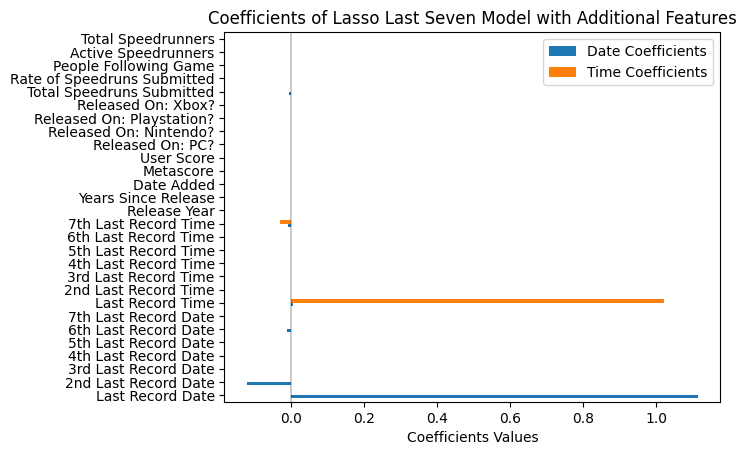

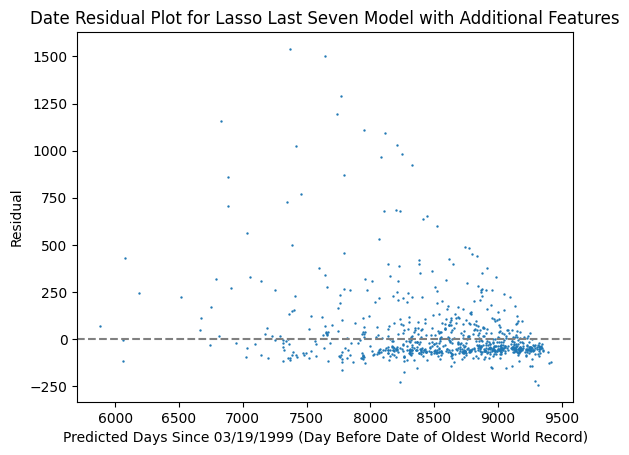

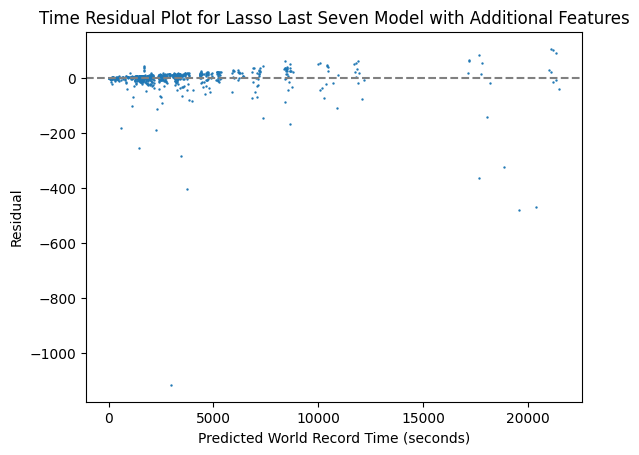

In [59]:
# Trains a last seven model with lasso regression with additional features
# on the determined best alpha for the time error.

# Creates the training input and output.
training_x = np.zeros((NUM_GAMES, 28))
training_y = np.zeros((NUM_GAMES, 2))
for i in range(NUM_GAMES):
    # Adds the world record data to the training input.
    training_history = training_wr_array[i]
    for j in range(7):
        training_x[i][j] = training_history[-j - 2, 0]
        training_x[i][j + 7] = training_history[-j - 2, 1]

    # Adds the additional features to the training input.
    training_x[i][14] = numerical_training_data[i, 0]
    training_x[i][15] = numerical_training_data[i, 1]
    training_x[i][16] = numerical_training_data[i, 2]
    training_x[i][17] = numerical_training_data[i, 3]
    training_x[i][18] = numerical_training_data[i, 4]
    training_x[i][19] = numerical_training_data[i, 5]
    training_x[i][20] = numerical_training_data[i, 6]
    training_x[i][21] = numerical_training_data[i, 7]
    training_x[i][22] = numerical_training_data[i, 8]
    training_x[i][23] = numerical_training_data[i, 10]
    training_x[i][24] = numerical_training_data[i, 11]
    training_x[i][25] = numerical_training_data[i, 12]
    training_x[i][26] = numerical_training_data[i, 13]
    training_x[i][27] = numerical_training_data[i, 14]

    # Adds the world record data to the training output.
    training_y[i][0] = training_history[-1, 0]
    training_y[i][1] = training_history[-1, 1]

# Trains the model.
ALPHA_VALUE = 2567
lasso_regression_model = linear_model.Lasso(alpha=ALPHA_VALUE)
general_lasso_last_7 = lasso_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Years Since Release", "Date Added", "Metascore", "User Score", "Released On: PC?", "Released On: Nintendo?", "Released On: Playstation?", "Released On: Xbox?", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
general_lasso_last_7_coefficients = pd.DataFrame((np.transpose(general_lasso_last_7.coef_)), columns=output_coefficient_labels, index=feature_labels)
print(general_lasso_last_7_coefficients)

# Maps the coefficients of the features.
general_lasso_last_7_coefficients.plot.barh()
plt.title("Coefficients of Lasso Last Seven Model with Additional Features")
plt.xlabel("Coefficients Values")
plt.axvline(x=0, color="black", linewidth="0.3")


print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 28))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional features to the test input.
        test_x[index][14] = numerical_test_data[i, 0]
        test_x[index][15] = numerical_test_data[i, 1]
        test_x[index][16] = numerical_test_data[i, 2]
        test_x[index][17] = numerical_test_data[i, 3]
        test_x[index][18] = numerical_test_data[i, 4]
        test_x[index][19] = numerical_test_data[i, 5]
        test_x[index][20] = numerical_test_data[i, 6]
        test_x[index][21] = numerical_test_data[i, 7]
        test_x[index][22] = numerical_test_data[i, 8]
        test_x[index][23] = numerical_test_data[i, 10]
        test_x[index][24] = numerical_test_data[i, 11]
        test_x[index][25] = numerical_test_data[i, 12]
        test_x[index][26] = numerical_test_data[i, 13]
        test_x[index][27] = numerical_test_data[i, 14]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Checks the test input.
# test_input = open("test_input.txt", "w")
# for line in test_x:
#     test_input.write(str(line) + "\n")
# test_input.close()

# Tests the model on just the test world records.
predicted_y =  general_lasso_last_7.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Lasso Last Seven Model with Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Lasso Last Seven Model with Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

In [61]:
# Performs the step model with lasso regression with additional features repeatedly
# with different values of alpha to find the optimal one for both the time mean
# absolute error and the date mean absolute error.

best_date_alpha = -1
best_time_alpha = -1
best_date_mae = -1
best_time_mae = -1

for a in range(10):
    # 2982 is the total number of training records, but 7 is subtracted from the total
    # number of samples for each game because there must be at least 7 games for the
    # first training input point.
    training_x = np.zeros((2982 - (7 * NUM_GAMES), 28))
    training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
    index = 0
    for i in range(NUM_GAMES):
        training_history = training_wr_array[i]
        num_training_records = len(training_history)
        for j in range(7, num_training_records):
            # Adds the world record data to the training input.
            for k in range(7):
                away_from_end = num_training_records - j + 1 + k
                training_x[index][k] = training_history[-away_from_end, 0]
                training_x[index][k + 7] = training_history[-away_from_end, 1]

            # Adds the additional features to the training input.
            training_x[index][14] = numerical_training_data[i, 0]
            training_x[index][15] = numerical_training_data[i, 1]
            training_x[index][16] = numerical_training_data[i, 2]
            training_x[index][17] = numerical_training_data[i, 3]
            training_x[index][18] = numerical_training_data[i, 4]
            training_x[index][19] = numerical_training_data[i, 5]
            training_x[index][20] = numerical_training_data[i, 6]
            training_x[index][21] = numerical_training_data[i, 7]
            training_x[index][22] = numerical_training_data[i, 8]
            training_x[index][23] = numerical_training_data[i, 10]
            training_x[index][24] = numerical_training_data[i, 11]
            training_x[index][25] = numerical_training_data[i, 12]
            training_x[index][26] = numerical_training_data[i, 13]
            training_x[index][27] = numerical_training_data[i, 14]

            # Adds the world record data to the actual output.
            training_y[index][0] = training_history[j, 0]
            training_y[index][1] = training_history[j, 1]

            index += 1

    # Checks the training input.
    # training_input = open("training_input.txt", "w")
    # for line in training_x:
    #     training_input.write(str(line) + "\n")
    # training_input.close()

    # Trains the model.
    ALPHA_VALUE = a
    lasso_regression_model = linear_model.Lasso(alpha=ALPHA_VALUE)
    general_lasso_step = lasso_regression_model.fit(training_x, training_y)

    # Creates the test input and actual output for all test records.
    test_x = np.zeros((795, 28))
    actual_y = np.zeros((795, 2))
    index = 0
    for i in range(NUM_GAMES):
        training_history = training_wr_array[i]
        test_history = test_wr_array[i]
        num_test_records = len(test_history)
        for j in range(num_test_records):
            # Adds the world record data to the test input.
            for k in range(7):
                away_from_end = num_test_records - j + 1 + k
                if (away_from_end) <= num_test_records:
                    test_x[index][k] = test_history[-away_from_end, 0]
                    test_x[index][k + 7] = test_history[-away_from_end, 1]
                else:
                    test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                    test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

            # Adds the additional features to the test input.
            test_x[index][14] = numerical_test_data[i, 0]
            test_x[index][15] = numerical_test_data[i, 1]
            test_x[index][16] = numerical_test_data[i, 2]
            test_x[index][17] = numerical_test_data[i, 3]
            test_x[index][18] = numerical_test_data[i, 4]
            test_x[index][19] = numerical_test_data[i, 5]
            test_x[index][20] = numerical_test_data[i, 6]
            test_x[index][21] = numerical_test_data[i, 7]
            test_x[index][22] = numerical_test_data[i, 8]
            test_x[index][23] = numerical_test_data[i, 10]
            test_x[index][24] = numerical_test_data[i, 11]
            test_x[index][25] = numerical_test_data[i, 12]
            test_x[index][26] = numerical_test_data[i, 13]
            test_x[index][27] = numerical_test_data[i, 14]

            # Adds the world record data to the actual output.
            actual_y[index][0] = test_history[j, 0]
            actual_y[index][1] = test_history[j, 1]

            index += 1

    # Tests the model on just the test world records.
    predicted_y = general_lasso_step.predict(test_x)
    date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
    time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])

    # Sets the alpha values if the errors are better for a given value of alpha.
    if (a == 0):
        best_date_alpha = a
        best_time_alpha = a
        best_date_mae = date_mae
        best_time_mae = time_mae

    if (best_date_mae > date_mae):
        best_date_alpha = a
        best_date_mae = date_mae

    if (best_time_mae > time_mae):
        best_time_alpha = a
        best_time_mae = time_mae

print()
print()
print("The best value of alpha for the date is [ " + str(best_date_alpha) + " ] with an MAE of [ " + str(best_date_mae) + " ] .")
print("The best value of alpha for the time is [ " + str(best_time_alpha) + " ] with an MAE of [ " + str(best_time_mae) + " ] .")
# The best date alpha was determined to be 2944.
# The best time alpha was determined to be 6.

/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 



The best value of alpha for the date is [ 9 ] with an MAE of [ 98.71134337387589 ] .
The best value of alpha for the time is [ 6 ] with an MAE of [ 17.32060023634331 ] .


/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.496e+07, tolerance: 1.705e+05
  model = cd_fast.enet_coordinate_descent(
/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e+07, tolerance: 1.705e+05
  model = cd_fast.enet_coordinate_descent(


/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+07, tolerance: 1.705e+05
  model = cd_fast.enet_coordinate_descent(


                             Date Coefficients  Time Coefficients
Last Record Date                  1.072082e+00       8.272071e-03
2nd Last Record Date             -8.726198e-02       3.740156e-03
3rd Last Record Date              1.242643e-01      -3.338522e-03
4th Last Record Date             -1.107882e-01      -6.450290e-03
5th Last Record Date              2.783843e-02       1.291449e-02
6th Last Record Date             -2.323407e-02      -1.246550e-02
7th Last Record Date             -1.152480e-02       8.605507e-04
Last Record Time                 -3.149915e-02       1.053649e+00
2nd Last Record Time              3.218767e-02      -7.089626e-03
3rd Last Record Time             -1.637111e-03      -6.517225e-03
4th Last Record Time              1.410689e-02      -6.303293e-03
5th Last Record Time             -9.838628e-03      -5.397013e-03
6th Last Record Time             -7.767242e-03      -7.700036e-03
7th Last Record Time              3.512430e-03      -2.474604e-02
Release Ye

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3499905198.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  training_importance_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3499905198.py:95: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  training_additional_importance_plot.show()


                             Test Mean Importance
Last Record Date                         1.180122
2nd Last Record Date                     0.019421
3rd Last Record Date                     0.006145
4th Last Record Date                     0.030217
5th Last Record Date                    -0.002114
6th Last Record Date                     0.003999
7th Last Record Date                     0.001931
Last Record Time                         1.159724
2nd Last Record Time                     0.039258
3rd Last Record Time                     0.000132
4th Last Record Time                     0.007996
5th Last Record Time                     0.003754
6th Last Record Time                     0.002436
7th Last Record Time                     0.001358
Release Year                             0.000217
Years Since Release                      0.000000
Date Added                               0.000000
Metascore                                0.000048
User Score                               0.000000


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3499905198.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  test_importance_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3499905198.py:166: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  test_additional_importance_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3499905198.py:203: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3499905198.py:211: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


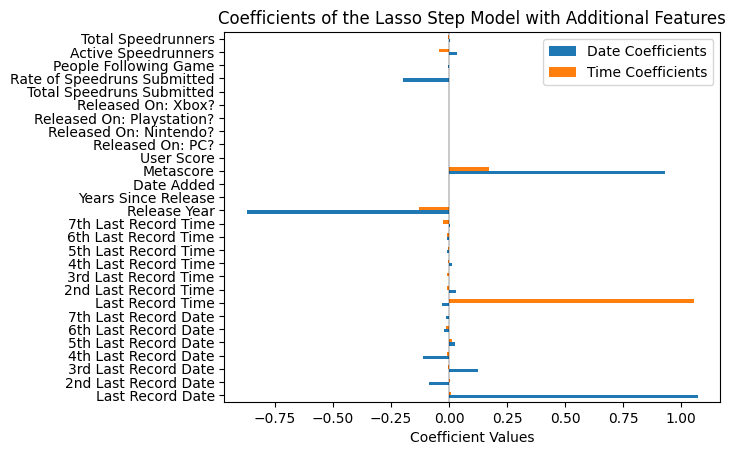

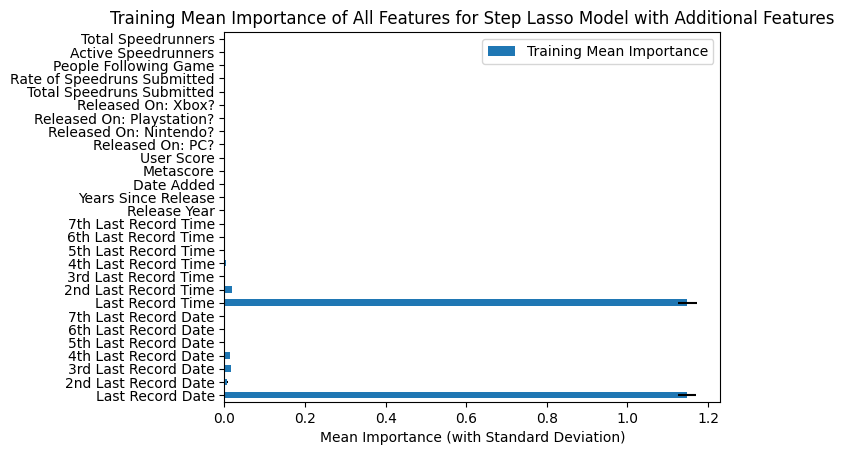

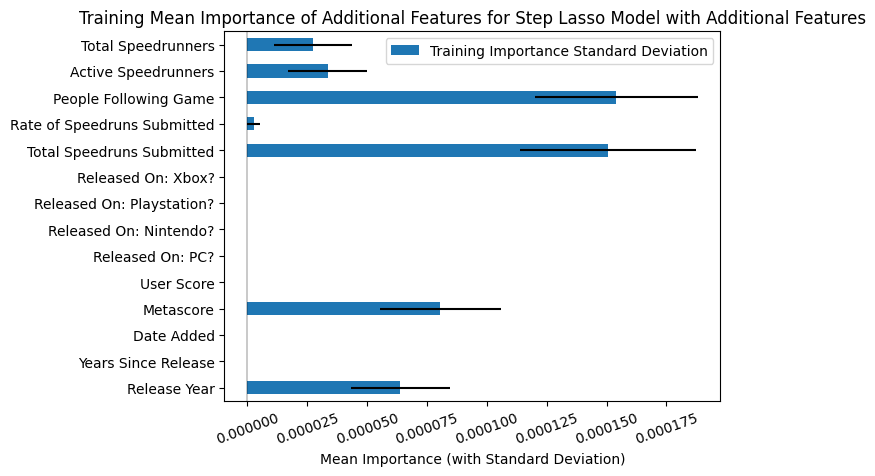

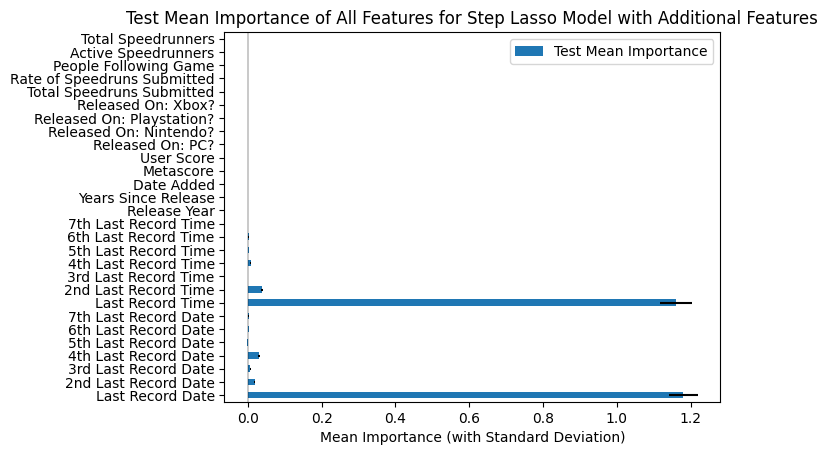

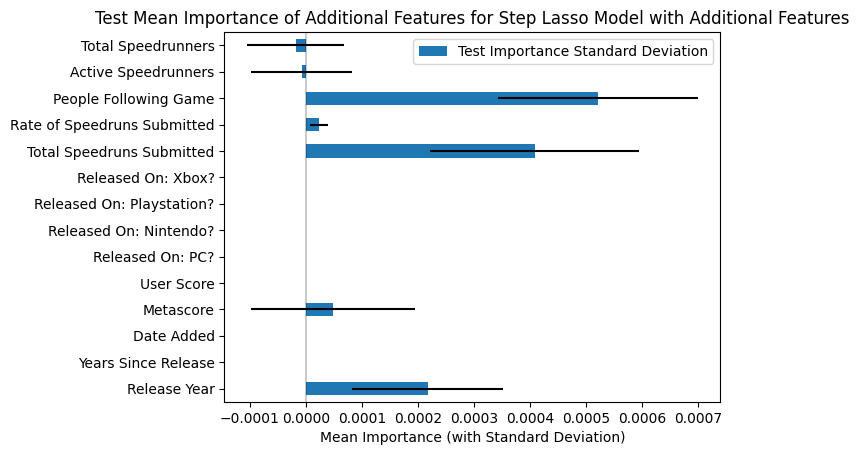

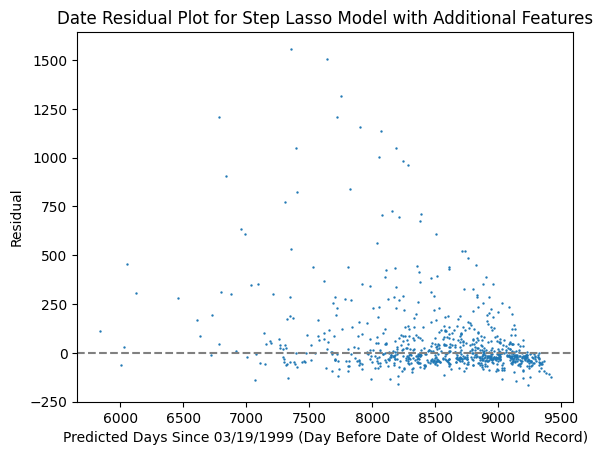

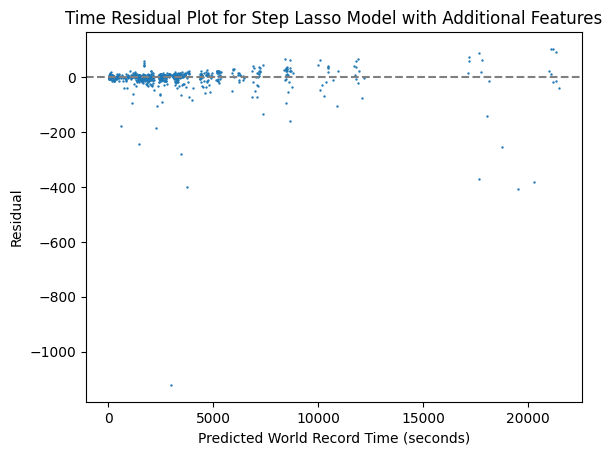

In [64]:
# Performs the step model with lasso regression with additional features using the
# values of the best performing alpha value found in the previous cell.

# Note: This model was selected as the one which would have further feature analysis
# performed, and thus permutation importance is also included in this cell.

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 28))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the additional features to the training input.
        training_x[index][14] = numerical_training_data[i, 0]
        training_x[index][15] = numerical_training_data[i, 1]
        training_x[index][16] = numerical_training_data[i, 2]
        training_x[index][17] = numerical_training_data[i, 3]
        training_x[index][18] = numerical_training_data[i, 4]
        training_x[index][19] = numerical_training_data[i, 5]
        training_x[index][20] = numerical_training_data[i, 6]
        training_x[index][21] = numerical_training_data[i, 7]
        training_x[index][22] = numerical_training_data[i, 8]
        training_x[index][23] = numerical_training_data[i, 10]
        training_x[index][24] = numerical_training_data[i, 11]
        training_x[index][25] = numerical_training_data[i, 12]
        training_x[index][26] = numerical_training_data[i, 13]
        training_x[index][27] = numerical_training_data[i, 14]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# Checks the training input.
# training_input = open("training_input.txt", "w")
# for line in training_x:
#     training_input.write(str(line) + "\n")
# training_input.close()

# Trains the model.
ALPHA_VALUE = 6
lasso_regression_model = linear_model.Lasso(alpha=ALPHA_VALUE)
general_lasso_step = lasso_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Years Since Release", "Date Added", "Metascore", "User Score", "Released On: PC?", "Released On: Nintendo?", "Released On: Playstation?", "Released On: Xbox?", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
general_lasso_step_coefficients = pd.DataFrame((np.transpose(general_lasso_step.coef_)), columns=output_coefficient_labels, index=feature_labels)
print(general_lasso_step_coefficients)

# Maps the coefficients of the features.
general_lasso_step_coefficients.plot.barh()
plt.title("Coefficients of the Lasso Step Model with Additional Features")
plt.xlabel("Coefficient Values")
plt.axvline(x=0, color="black", linewidth="0.3")

print()

# Determines the feature importances for the training data.
output_coefficient_labels = ["Training Mean Importance"]
training_feature_importances = permutation_importance(general_lasso_step, training_x, training_y, n_repeats=100, random_state=0)
training_feature_importances_table = pd.DataFrame(np.transpose((training_feature_importances.importances_mean)), columns=output_coefficient_labels, index=feature_labels)
print(training_feature_importances_table)
output_coefficient_labels = ["Training Importance Standard Deviation"]
training_feature_importances_deviation_table = pd.DataFrame(np.transpose((training_feature_importances.importances_std)), columns=output_coefficient_labels, index=feature_labels)
print(training_feature_importances_deviation_table)

# Plots the training feature importances in a bar plot.
training_importance_plot, training_importance_axes = plt.subplots()
training_importance_axes = training_feature_importances_table.plot.barh(xerr=training_feature_importances.importances_std, ax=training_importance_axes)
training_importance_axes.set_xlabel("Mean Importance (with Standard Deviation)")
training_importance_axes.set_title("Training Mean Importance of All Features for Step Lasso Model with Additional Features")
training_importance_axes.axvline(x=0, color="black", linewidth="0.3")
training_importance_plot.show()

training_additional_feature_importances_table = pd.DataFrame(np.transpose((training_feature_importances.importances_mean[14:])), columns=output_coefficient_labels, index=feature_labels[14:])
training_additional_importance_plot, training_additional_importance_axes = plt.subplots()
training_additional_importance_axes = training_additional_feature_importances_table.plot.barh(xerr=training_feature_importances.importances_std[14:], ax=training_additional_importance_axes)
training_additional_importance_axes.set_xlabel("Mean Importance (with Standard Deviation)")
for label in training_additional_importance_axes.get_xticklabels(which='major'):
    label.set(rotation=20)
training_additional_importance_axes.set_title("Training Mean Importance of Additional Features for Step Lasso Model with Additional Features")
training_additional_importance_axes.axvline(x=0, color="black", linewidth="0.3")
training_additional_importance_plot.show()

print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 28))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional features to the test input.
        test_x[index][14] = numerical_test_data[i, 0]
        test_x[index][15] = numerical_test_data[i, 1]
        test_x[index][16] = numerical_test_data[i, 2]
        test_x[index][17] = numerical_test_data[i, 3]
        test_x[index][18] = numerical_test_data[i, 4]
        test_x[index][19] = numerical_test_data[i, 5]
        test_x[index][20] = numerical_test_data[i, 6]
        test_x[index][21] = numerical_test_data[i, 7]
        test_x[index][22] = numerical_test_data[i, 8]
        test_x[index][23] = numerical_test_data[i, 10]
        test_x[index][24] = numerical_test_data[i, 11]
        test_x[index][25] = numerical_test_data[i, 12]
        test_x[index][26] = numerical_test_data[i, 13]
        test_x[index][27] = numerical_test_data[i, 14]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Determines the feature importances for the test data.
output_coefficient_labels = ["Test Mean Importance"]
test_feature_importances = permutation_importance(general_lasso_step, test_x, actual_y, n_repeats=100, random_state=0)
test_feature_importances_table = pd.DataFrame(np.transpose((test_feature_importances.importances_mean)), columns=output_coefficient_labels, index=feature_labels)
print(test_feature_importances_table)
output_coefficient_labels = ["Test Importance Standard Deviation"]
test_feature_importances_deviation_table = pd.DataFrame(np.transpose((test_feature_importances.importances_std)), columns=output_coefficient_labels, index=feature_labels)
print(test_feature_importances_deviation_table)

# Plots the test feature importances in a bar plot.
test_importance_plot, test_importance_axes = plt.subplots()
test_importance_axes = test_feature_importances_table.plot.barh(xerr=test_feature_importances.importances_std, ax=test_importance_axes)
test_importance_axes.set_xlabel("Mean Importance (with Standard Deviation)")
test_importance_axes.set_title("Test Mean Importance of All Features for Step Lasso Model with Additional Features")
test_importance_axes.axvline(x=0, color="black", linewidth="0.3")
test_importance_plot.show()

test_additional_feature_importances_table = pd.DataFrame(np.transpose((test_feature_importances.importances_mean[14:])), columns=output_coefficient_labels, index=feature_labels[14:])
test_additional_importance_plot, test_additional_importance_axes = plt.subplots()
test_additional_importance_axes = test_additional_feature_importances_table.plot.barh(xerr=test_feature_importances.importances_std[14:], ax=test_additional_importance_axes)
test_additional_importance_axes.set_xlabel("Mean Importance (with Standard Deviation)")
test_additional_importance_axes.set_title("Test Mean Importance of Additional Features for Step Lasso Model with Additional Features")
test_additional_importance_axes.axvline(x=0, color="black", linewidth="0.3")
test_additional_importance_plot.show()

print()

# Tests the model on just the test world records.
predicted_y = general_lasso_step.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")

# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Step Lasso Model with Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Step Lasso Model with Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

/Users/aidanward/Documents/Princeton Courses/3A - Junior Fall/COS 397/Data and Programming/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+07, tolerance: 1.705e+05
  model = cd_fast.enet_coordinate_descent(
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/166758075.py:131: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/166758075.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


                             Date Coefficients  Time Coefficients
Last Record Date                      1.072082           0.008082
2nd Last Record Date                 -0.087262           0.003877
3rd Last Record Date                  0.124264          -0.003132
4th Last Record Date                 -0.110788          -0.006509
5th Last Record Date                  0.027838           0.012813
6th Last Record Date                 -0.023234          -0.012520
7th Last Record Date                 -0.011525           0.000924
Last Record Time                     -0.031499           1.053566
2nd Last Record Time                  0.032188          -0.007101
3rd Last Record Time                 -0.001636          -0.006486
4th Last Record Time                  0.014106          -0.006295
5th Last Record Time                 -0.009839          -0.005379
6th Last Record Time                 -0.007767          -0.007637
7th Last Record Time                  0.003513          -0.024776
Release Ye

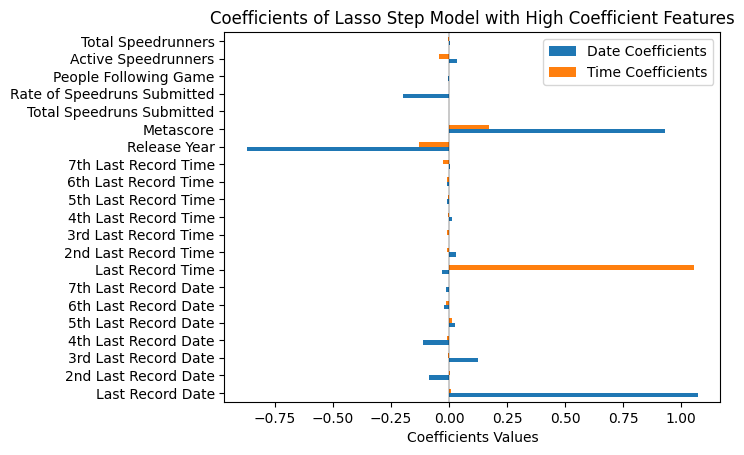

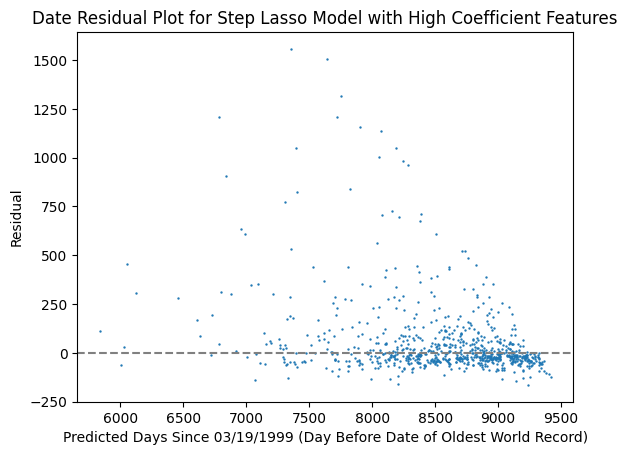

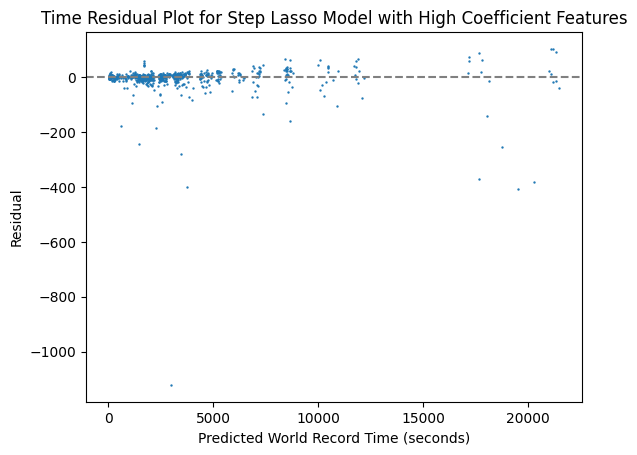

In [65]:
# Performs the step model with lasso regression only using the features which
# were shown to be significantly nonzero.

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 21))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the additional features to the training input.
        training_x[index][14] = numerical_training_data[i, 0]
        training_x[index][15] = numerical_training_data[i, 3]
        training_x[index][16] = numerical_training_data[i, 10]
        training_x[index][17] = numerical_training_data[i, 11]
        training_x[index][18] = numerical_training_data[i, 12]
        training_x[index][19] = numerical_training_data[i, 13]
        training_x[index][20] = numerical_training_data[i, 14]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# Checks training input.
# training_input = open("training_input.txt", "w")
# for line in training_x:
#     training_input.write(str(line) + "\n")
# training_input.close()

# Trains the model.
ALPHA_VALUE = 6
lasso_regression_model = linear_model.Lasso(alpha=ALPHA_VALUE)
general_lasso_step = lasso_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Metascore", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
general_lasso_step_coefficients = pd.DataFrame((np.transpose(general_lasso_step.coef_)), columns=output_coefficient_labels, index=feature_labels)
print(general_lasso_step_coefficients)

# Maps the coefficients of the features.
general_lasso_step_coefficients.plot.barh()
plt.title("Coefficients of Lasso Step Model with High Coefficient Features")
plt.xlabel("Coefficients Values")
plt.axvline(x=0, color="black", linewidth="0.3")


print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 21))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional features to the test input.
        test_x[index][14] = numerical_test_data[i, 0]
        test_x[index][15] = numerical_test_data[i, 3]
        test_x[index][16] = numerical_test_data[i, 10]
        test_x[index][17] = numerical_test_data[i, 11]
        test_x[index][18] = numerical_test_data[i, 12]
        test_x[index][19] = numerical_test_data[i, 13]
        test_x[index][20] = numerical_test_data[i, 14]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = general_lasso_step.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")

# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Step Lasso Model with High Coefficient Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Step Lasso Model with High Coefficient Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

                           Date Coefficients  Time Coefficients
Last Record Date                    1.004027           0.000000
2nd Last Record Date                0.000000           0.000000
3rd Last Record Date                0.000000           0.000000
4th Last Record Date               -0.000000           0.000000
5th Last Record Date               -0.000000           0.000000
6th Last Record Date               -0.000000           0.000000
7th Last Record Date               -0.018066           0.000000
Last Record Time                   -0.000350           1.022721
2nd Last Record Time               -0.000000           0.000000
3rd Last Record Time               -0.000000           0.000000
4th Last Record Time               -0.000000           0.000000
5th Last Record Time               -0.000000           0.000000
6th Last Record Time               -0.000000          -0.000000
7th Last Record Time               -0.000000          -0.027618
Total Speedruns Submitted          -0.00

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/1012885693.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/1012885693.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


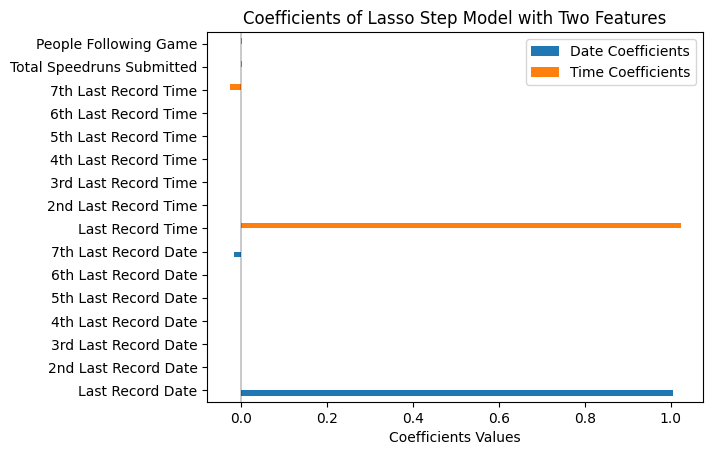

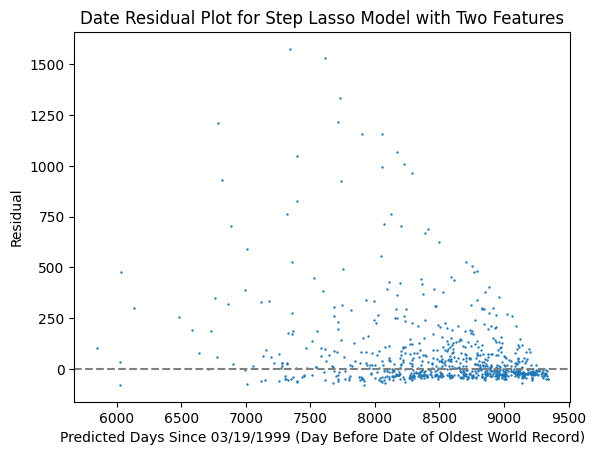

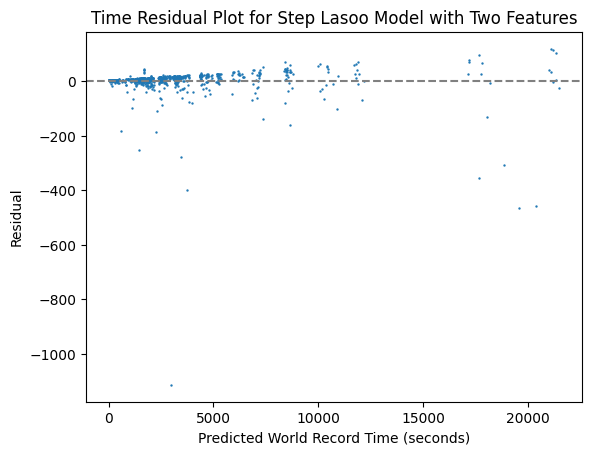

In [66]:
# Performs the step model with lasso regression with only two additional features
# to determine if any combinations improve the performance of the model.

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 16))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the additional features to the training input.
        training_x[index][14] = numerical_training_data[i, 10]
        training_x[index][15] = numerical_training_data[i, 12]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# Checks training input.
# training_input = open("training_input.txt", "w")
# for line in training_x:
#     training_input.write(str(line) + "\n")
# training_input.close()

# Trains the model.
ALPHA_VALUE = 2944
lasso_regression_model = linear_model.Lasso(alpha=ALPHA_VALUE)
general_lasso_step = lasso_regression_model.fit(training_x, training_y)

# Prints the coefficients of the model.
output_coefficient_labels = ["Date Coefficients", "Time Coefficients"]
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Total Speedruns Submitted", "People Following Game"])
general_lasso_step_coefficients = pd.DataFrame((np.transpose(general_lasso_step.coef_)), columns=output_coefficient_labels, index=feature_labels)
print(general_lasso_step_coefficients)

# Maps the coefficients of the features.
general_lasso_step_coefficients.plot.barh()
plt.title("Coefficients of Lasso Step Model with Two Features")
plt.xlabel("Coefficients Values")
plt.axvline(x=0, color="black", linewidth="0.3")


print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 16))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional features to the test input.
        test_x[index][14] = numerical_test_data[i, 10]
        test_x[index][15] = numerical_test_data[i, 12]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = general_lasso_step.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")

# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Step Lasso Model with Two Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Step Lasoo Model with Two Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

In [72]:
# Hyperparameter tuning for a random forest last seven model without additional features.

first_iteration = True
best_date_mae = 0
best_date_n_est_value = 0
best_date_depth_value = 0
best_date_split_value = 0
best_time_mae = 0
best_time_n_est_value = 0
best_time_depth_value = 0
best_time_split_value = 0

for a in range(50, 51, 10):
    print("Current n_estimators: " + str(a))
    for b in range(5, 6, 2):
        print("Current max_depth: " + str(b))
        for c in range(2, 3, 2):
            print("Current min_samples_split: " + str(c))
            random_forest_model = ensemble.RandomForestRegressor(criterion="absolute_error", n_estimators=a, max_depth=b, min_samples_split=c)

            # Creates the training input and output.
            training_x = np.zeros((NUM_GAMES, 14))
            training_y = np.zeros((NUM_GAMES, 2))
            for i in range(NUM_GAMES):
                # Adds the world record data to the training input.
                training_history = training_wr_array[i]
                for j in range(7):
                    training_x[i][j] = training_history[-j - 2, 0]
                    training_x[i][j + 7] = training_history[-j - 2, 1]

                # Adds the world record data to the training output.
                training_y[i][0] = training_history[-1, 0]
                training_y[i][1] = training_history[-1, 1]

            # Trains the model.
            tuned_wr_only_random_forest_last_7 = random_forest_model.fit(training_x, training_y)


            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


            # Creates the test input and actual output for all test records.
            test_x = np.zeros((795, 14))
            actual_y = np.zeros((795, 2))
            index = 0
            for i in range(NUM_GAMES):
                training_history = training_wr_array[i]
                test_history = test_wr_array[i]
                num_test_records = len(test_history)
                for j in range(num_test_records):
                    # Adds the world record data to the test input.
                    for k in range(7):
                        away_from_end = num_test_records - j + 1 + k
                        if (away_from_end) <= num_test_records:
                            test_x[index][k] = test_history[-away_from_end, 0]
                            test_x[index][k + 7] = test_history[-away_from_end, 1]
                        else:
                            test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                            test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

                    # Adds the world record data to the actual output.
                    actual_y[index][0] = test_history[j, 0]
                    actual_y[index][1] = test_history[j, 1]

                    index += 1

            # Tests the model on just the test world records.
            predicted_y = tuned_wr_only_random_forest_last_7.predict(test_x)
            date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
            time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])

            # Reports various errors.
            # print("The date mean absolute error is:\t" + str(date_mae))
            # print("The time mean absolute error is:\t" + str(time_mae))

            # Sets the hyperparameters if the errors are better for their given values.
            if (first_iteration):
                first_iteration = False
                best_date_mae = date_mae
                best_date_n_est_value = a
                best_date_depth_value = b
                best_date_split_value = c
                best_time_mae = time_mae
                best_time_n_est_value = a
                best_time_depth_value = b
                best_time_split_value = c

            if (best_date_mae > date_mae):
                best_date_mae = date_mae
                best_date_n_est_value = a
                best_date_depth_value = b
                best_date_split_value = c

            if (best_time_mae > time_mae):
                best_time_mae = time_mae
                best_time_n_est_value = a
                best_time_depth_value = b
                best_time_split_value = c

            print()

print()
print()
print("The best hyperparameters resulting in a date MAE of [ " + str(best_date_mae) + " ] are:")
print("\tn_estimators :\t" + str(best_date_n_est_value))
print("\tmax_depth :\t" + str(best_date_depth_value))
print("\tmin_samples_split :\t" + str(best_date_split_value))
print()
print("The best hyperparameters resulting in a time MAE of [ " + str(best_time_mae) + " ] are:")
print("\tn_estimators :\t" + str(best_time_n_est_value))
print("\tmax_depth :\t" + str(best_time_depth_value))
print("\tmin_samples_split :\t" + str(best_time_split_value))
# Date Params: n_estimators=100, max_depth=23, min_samples_split=2
# Time Params: n_estimators=130, max_depth=27, min_samples_split=2

Current n_estimators: 50
Current max_depth: 5
Current min_samples_split: 2



The best hyperparameters resulting in a date MAE of [ 334.0537987421384 ] are:
	n_estimators :	50
	max_depth :	5
	min_samples_split :	2

The best hyperparameters resulting in a time MAE of [ 131.18577581132075 ] are:
	n_estimators :	50
	max_depth :	5
	min_samples_split :	2


The date root mean squared error is:	372.2570180322041
The time root mean squared error is:	259.11292155046647
The date mean absolute error is:	261.97488147073057
The time mean absolute error is:	102.73994582486685
The date mean relative error is:	3.018172716468841%
The time mean relative error is:	23.524268986310755%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2942121837.py:89: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2942121837.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


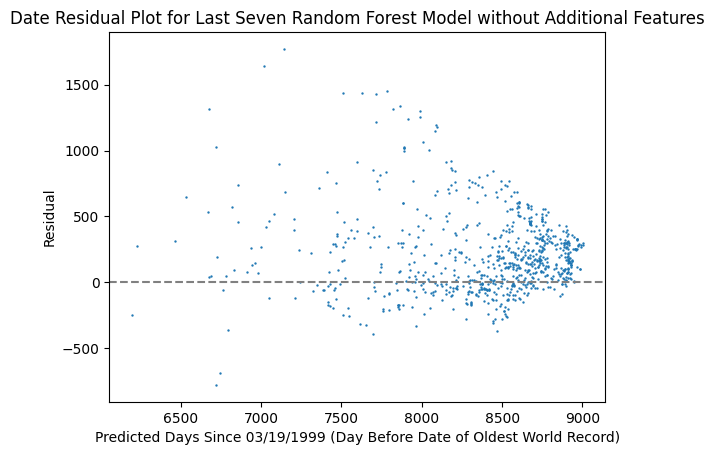

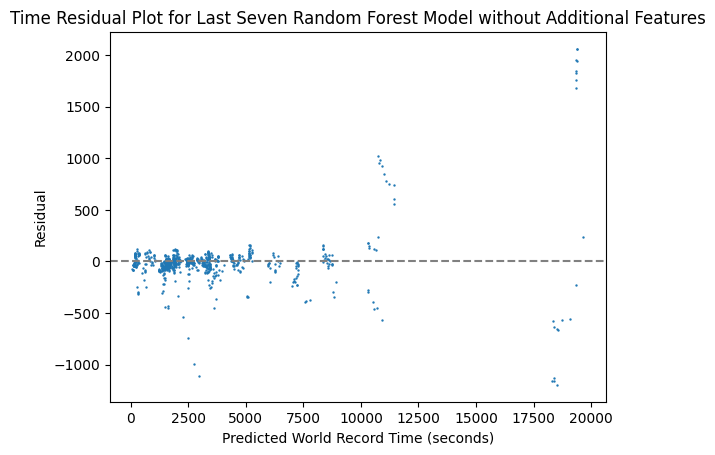

In [73]:
# Creates the last seven random forest model without additional features
# from the previously found hyperparameters.

# Note: All random forest regression models may slightly differ with error
# values due to the random nature of the model.

random_forest_model = ensemble.RandomForestRegressor(criterion="absolute_error", n_estimators=130, max_depth=27, min_samples_split=2)

# Creates the training input and output.
training_x = np.zeros((NUM_GAMES, 14))
training_y = np.zeros((NUM_GAMES, 2))
for i in range(NUM_GAMES):
    # Adds the world record data to the training input.
    training_history = training_wr_array[i]
    for j in range(7):
        training_x[i][j] = training_history[-j - 2, 0]
        training_x[i][j + 7] = training_history[-j - 2, 1]

    # Adds the world record data to the training output.
    training_y[i][0] = training_history[-1, 0]
    training_y[i][1] = training_history[-1, 1]

# Trains the model.
tuned_wr_only_random_forest_last_7 = random_forest_model.fit(training_x, training_y)


# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 14))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = tuned_wr_only_random_forest_last_7.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Last Seven Random Forest Model without Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Last Seven Random Forest Model without Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

In [74]:
# Hyperparameter tuning for a random forest step model without additional features.

first_iteration = True
best_date_mae = 0
best_date_n_est_value = 0
best_date_depth_value = 0
best_date_split_value = 0
best_time_mae = 0
best_time_n_est_value = 0
best_time_depth_value = 0
best_time_split_value = 0

for a in range(90, 91, 10):
    print("Current n_estimators: " + str(a))
    for b in range(7, 8, 2):
        print("Current max_depth: " + str(b))
        for c in range(2, 3, 2):
            print("Current min_samples_split: " + str(c))

            # 2982 is the total number of training records, but 7 is subtracted from the total
            # number of samples for each game because there must be at least 7 games for the
            # first training input point.
            training_x = np.zeros((2982 - (7 * NUM_GAMES), 14))
            training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
            index = 0
            for i in range(NUM_GAMES):
                training_history = training_wr_array[i]
                num_training_records = len(training_history)
                for j in range(7, num_training_records):
                    # Adds the world record data to the training input.
                    for k in range(7):
                        away_from_end = num_training_records - j + 1 + k
                        training_x[index][k] = training_history[-away_from_end, 0]
                        training_x[index][k + 7] = training_history[-away_from_end, 1]

                    # Adds the world record data to the actual output.
                    training_y[index][0] = training_history[j, 0]
                    training_y[index][1] = training_history[j, 1]

                    index += 1

            # Trains the model.
            random_forest_model = ensemble.RandomForestRegressor(criterion="absolute_error", n_estimators=a, max_depth=b, min_samples_split=c)
            tuned_wr_only_random_forest_step = random_forest_model.fit(training_x, training_y)


            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


            # Creates the test input and actual output for all test records.
            test_x = np.zeros((795, 14))
            actual_y = np.zeros((795, 2))
            index = 0
            for i in range(NUM_GAMES):
                training_history = training_wr_array[i]
                test_history = test_wr_array[i]
                num_test_records = len(test_history)
                for j in range(num_test_records):
                    # Adds the world record data to the test input.
                    for k in range(7):
                        away_from_end = num_test_records - j + 1 + k
                        if (away_from_end) <= num_test_records:
                            test_x[index][k] = test_history[-away_from_end, 0]
                            test_x[index][k + 7] = test_history[-away_from_end, 1]
                        else:
                            test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                            test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

                    # Adds the world record data to the actual output.
                    actual_y[index][0] = test_history[j, 0]
                    actual_y[index][1] = test_history[j, 1]

                    index += 1

            # Tests the model on just the test world records.
            predicted_y = tuned_wr_only_random_forest_step.predict(test_x)
            date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
            time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])

            # Reports various errors.
            # print("The date mean absolute error is:\t" + str(date_mae))
            # print("The time mean absolute error is:\t" + str(time_mae))

            # Sets the hyperparameters if the errors are better for their given values.
            if (first_iteration):
                first_iteration = False
                best_date_mae = date_mae
                best_date_n_est_value = a
                best_date_depth_value = b
                best_date_split_value = c
                best_time_mae = time_mae
                best_time_n_est_value = a
                best_time_depth_value = b
                best_time_split_value = c

            if (best_date_mae > date_mae):
                best_date_mae = date_mae
                best_date_n_est_value = a
                best_date_depth_value = b
                best_date_split_value = c

            if (best_time_mae > time_mae):
                best_time_mae = time_mae
                best_time_n_est_value = a
                best_time_depth_value = b
                best_time_split_value = c

            print()

print()
print()
print("The best hyperparameters resulting in a date MAE of [ " + str(best_date_mae) + " ] are:")
print("\tn_estimators :\t" + str(best_date_n_est_value))
print("\tmax_depth :\t" + str(best_date_depth_value))
print("\tmin_samples_split :\t" + str(best_date_split_value))
print()
print("The best hyperparameters resulting in a time MAE of [ " + str(best_time_mae) + " ] are:")
print("\tn_estimators :\t" + str(best_time_n_est_value))
print("\tmax_depth :\t" + str(best_time_depth_value))
print("\tmin_samples_split :\t" + str(best_time_split_value))
# Date Params: n_estimators=90, max_depth=15, min_samples_split=2
# Time Params: n_estimators=100, max_depth=15, min_samples_split=2

Current n_estimators: 90
Current max_depth: 7
Current min_samples_split: 2



The best hyperparameters resulting in a date MAE of [ 353.5320125786163 ] are:
	n_estimators :	90
	max_depth :	7
	min_samples_split :	2

The best hyperparameters resulting in a time MAE of [ 121.03845937106925 ] are:
	n_estimators :	90
	max_depth :	7
	min_samples_split :	2


The date root mean squared error is:	410.89783039222505
The time root mean squared error is:	191.95459910112132
The date mean absolute error is:	275.36897484276733
The time mean absolute error is:	101.77550175471703
The date mean relative error is:	3.157434777368566%
The time mean relative error is:	12.768538148939825%


/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2866752983.py:92: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/2866752983.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


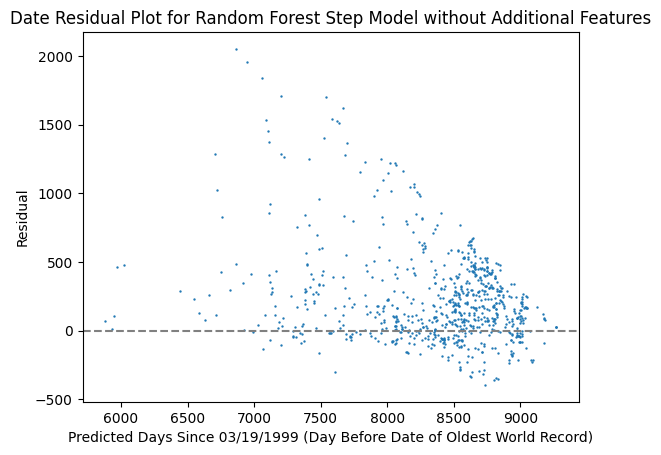

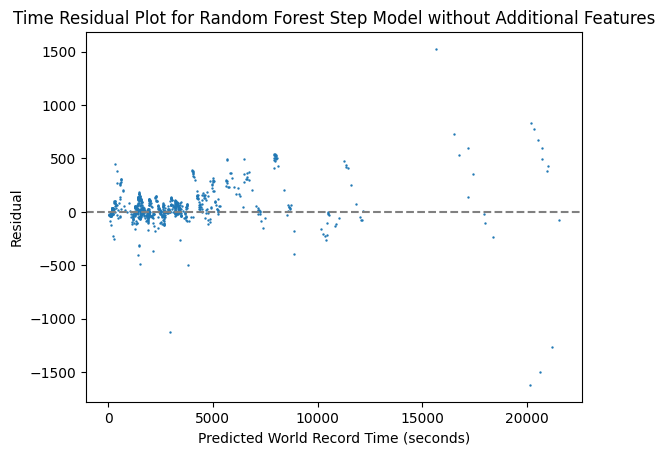

In [75]:
# Creates a random forest step model without additional features using the found tuned hyperparameters.

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 14))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# Trains the model.
random_forest_model = ensemble.RandomForestRegressor(criterion="absolute_error", n_estimators=100, max_depth=15, min_samples_split=2)
tuned_wr_only_random_forest_step = random_forest_model.fit(training_x, training_y)


# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 14))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = tuned_wr_only_random_forest_step.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Random Forest Step Model without Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Random Forest Step Model without Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

In [76]:
# Hyperparameter tuning for a random forest last seven model with additional features.

# Note: The random forest models with additional features had permutation importance
# performed due to there not being corresponding coefficients for each feature, but their
# signficiantly worse performance in comparison with the linear and lasso regression models
# indicate that the importances may not necessarily reflect actual trends.

first_iteration = True
best_date_mae = 0
best_date_n_est_value = 0
best_date_depth_value = 0
best_date_split_value = 0
best_time_mae = 0
best_time_n_est_value = 0
best_time_depth_value = 0
best_time_split_value = 0

for a in range(50, 51, 10):
    print("Current n_estimators: " + str(a))
    for b in range(5, 6, 2):
        print("Current max_depth: " + str(b))
        for c in range(2, 3, 2):
            print("Current min_samples_split: " + str(c))
            random_forest_model = ensemble.RandomForestRegressor(criterion="absolute_error", n_estimators=a, max_depth=b, min_samples_split=c)

            # Creates the training input and output.
            training_x = np.zeros((NUM_GAMES, 28))
            training_y = np.zeros((NUM_GAMES, 2))
            for i in range(NUM_GAMES):
                # Adds the world record data to the training input.
                training_history = training_wr_array[i]
                for j in range(7):
                    training_x[i][j] = training_history[-j - 2, 0]
                    training_x[i][j + 7] = training_history[-j - 2, 1]

                # Adds the additional features to the training input.
                training_x[i][14] = numerical_training_data[i, 0]
                training_x[i][15] = numerical_training_data[i, 1]
                training_x[i][16] = numerical_training_data[i, 2]
                training_x[i][17] = numerical_training_data[i, 3]
                training_x[i][18] = numerical_training_data[i, 4]
                training_x[i][19] = numerical_training_data[i, 5]
                training_x[i][20] = numerical_training_data[i, 6]
                training_x[i][21] = numerical_training_data[i, 7]
                training_x[i][22] = numerical_training_data[i, 8]
                training_x[i][23] = numerical_training_data[i, 10]
                training_x[i][24] = numerical_training_data[i, 11]
                training_x[i][25] = numerical_training_data[i, 12]
                training_x[i][26] = numerical_training_data[i, 13]
                training_x[i][27] = numerical_training_data[i, 14]

                # Adds the world record data to the training output.
                training_y[i][0] = training_history[-1, 0]
                training_y[i][1] = training_history[-1, 1]

            # Trains the model.
            tuned_random_forest_last_7 = random_forest_model.fit(training_x, training_y)


            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


            # Creates the test input and actual output for all test records.
            test_x = np.zeros((795, 28))
            actual_y = np.zeros((795, 2))
            index = 0
            for i in range(NUM_GAMES):
                training_history = training_wr_array[i]
                test_history = test_wr_array[i]
                num_test_records = len(test_history)
                for j in range(num_test_records):
                    # Adds the world record data to the test input.
                    for k in range(7):
                        away_from_end = num_test_records - j + 1 + k
                        if (away_from_end) <= num_test_records:
                            test_x[index][k] = test_history[-away_from_end, 0]
                            test_x[index][k + 7] = test_history[-away_from_end, 1]
                        else:
                            test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                            test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

                    # Adds the additional features to the test input.
                    test_x[index][14] = numerical_test_data[i, 0]
                    test_x[index][15] = numerical_test_data[i, 1]
                    test_x[index][16] = numerical_test_data[i, 2]
                    test_x[index][17] = numerical_test_data[i, 3]
                    test_x[index][18] = numerical_test_data[i, 4]
                    test_x[index][19] = numerical_test_data[i, 5]
                    test_x[index][20] = numerical_test_data[i, 6]
                    test_x[index][21] = numerical_test_data[i, 7]
                    test_x[index][22] = numerical_test_data[i, 8]
                    test_x[index][23] = numerical_test_data[i, 10]
                    test_x[index][24] = numerical_test_data[i, 11]
                    test_x[index][25] = numerical_test_data[i, 12]
                    test_x[index][26] = numerical_test_data[i, 13]
                    test_x[index][27] = numerical_test_data[i, 14]

                    # Adds the world record data to the actual output.
                    actual_y[index][0] = test_history[j, 0]
                    actual_y[index][1] = test_history[j, 1]

                    index += 1

            # Tests the model on just the test world records.
            predicted_y = tuned_random_forest_last_7.predict(test_x)
            date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
            time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])

            # Reports various errors.
            # print("The date mean absolute error is:\t" + str(date_mae))
            # print("The time mean absolute error is:\t" + str(time_mae))

            # Sets the hyperparameters if the errors are better for their given values.
            if (first_iteration):
                first_iteration = False
                best_date_mae = date_mae
                best_date_n_est_value = a
                best_date_depth_value = b
                best_date_split_value = c
                best_time_mae = time_mae
                best_time_n_est_value = a
                best_time_depth_value = b
                best_time_split_value = c

            if (best_date_mae > date_mae):
                best_date_mae = date_mae
                best_date_n_est_value = a
                best_date_depth_value = b
                best_date_split_value = c

            if (best_time_mae > time_mae):
                best_time_mae = time_mae
                best_time_n_est_value = a
                best_time_depth_value = b
                best_time_split_value = c

            print()

print()
print()
print("The best hyperparameters resulting in a date MAE of [ " + str(best_date_mae) + " ] are:")
print("\tn_estimators :\t" + str(best_date_n_est_value))
print("\tmax_depth :\t" + str(best_date_depth_value))
print("\tmin_samples_split :\t" + str(best_date_split_value))
print()
print("The best hyperparameters resulting in a time MAE of [ " + str(best_time_mae) + " ] are:")
print("\tn_estimators :\t" + str(best_time_n_est_value))
print("\tmax_depth :\t" + str(best_time_depth_value))
print("\tmin_samples_split :\t" + str(best_time_split_value))
# Date Params: n_estimators=90, max_depth=9, min_samples_split=2
# Time Params: n_estimators=190, max_depth=17, min_samples_split=2

Current n_estimators: 50
Current max_depth: 5
Current min_samples_split: 2



The best hyperparameters resulting in a date MAE of [ 330.2424025157233 ] are:
	n_estimators :	50
	max_depth :	5
	min_samples_split :	2

The best hyperparameters resulting in a time MAE of [ 165.26518265408802 ] are:
	n_estimators :	50
	max_depth :	5
	min_samples_split :	2


                             Feature Importances
Last Record Date                        0.045475
2nd Last Record Date                    0.024228
3rd Last Record Date                    0.021533
4th Last Record Date                    0.019832
5th Last Record Date                    0.013761
6th Last Record Date                    0.014968
7th Last Record Date                    0.011912
Last Record Time                        0.137420
2nd Last Record Time                    0.128459
3rd Last Record Time                    0.112165
4th Last Record Time                    0.092728
5th Last Record Time                    0.105949
6th Last Record Time                    0.096440
7th Last Record Time                    0.098639
Release Year                            0.005034
Years Since Release                     0.005945
Date Added                              0.003473
Metascore                               0.004399
User Score                              0.005409
Released On: PC?    

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3654799277.py:128: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3654799277.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


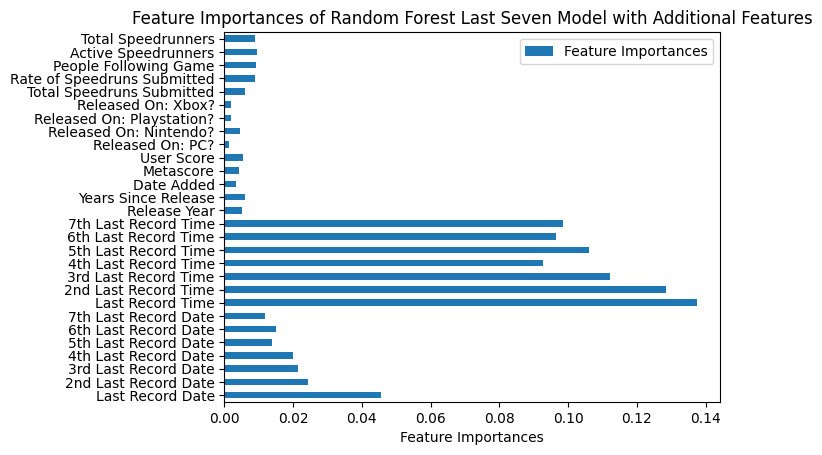

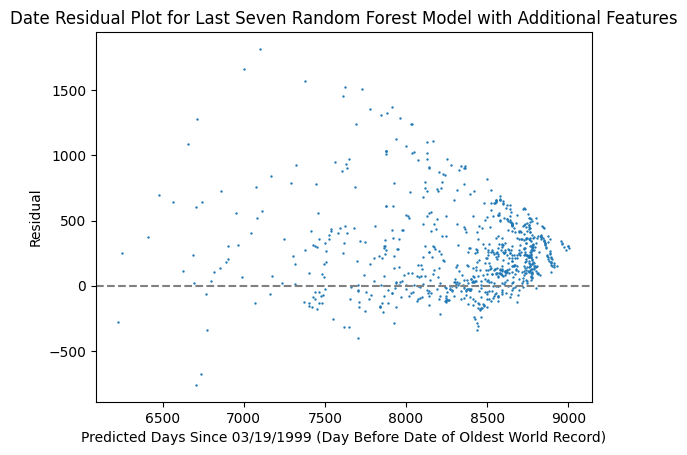

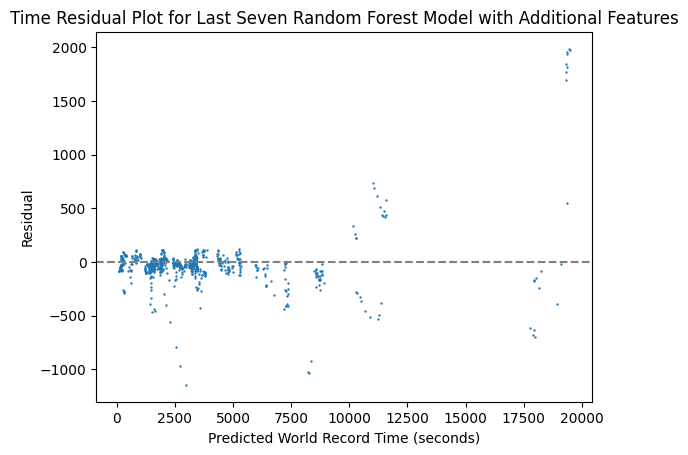

In [77]:
# Creates a random forest last seven model with additional features using the found tuned hyperparameters.

random_forest_model = ensemble.RandomForestRegressor(criterion="absolute_error", n_estimators=190, max_depth=17, min_samples_split=2)

# Creates the training input and output.
training_x = np.zeros((NUM_GAMES, 28))
training_y = np.zeros((NUM_GAMES, 2))
for i in range(NUM_GAMES):
    # Adds the world record data to the training input.
    training_history = training_wr_array[i]
    for j in range(7):
        training_x[i][j] = training_history[-j - 2, 0]
        training_x[i][j + 7] = training_history[-j - 2, 1]

    # Adds the additional features to the training input.
    training_x[i][14] = numerical_training_data[i, 0]
    training_x[i][15] = numerical_training_data[i, 1]
    training_x[i][16] = numerical_training_data[i, 2]
    training_x[i][17] = numerical_training_data[i, 3]
    training_x[i][18] = numerical_training_data[i, 4]
    training_x[i][19] = numerical_training_data[i, 5]
    training_x[i][20] = numerical_training_data[i, 6]
    training_x[i][21] = numerical_training_data[i, 7]
    training_x[i][22] = numerical_training_data[i, 8]
    training_x[i][23] = numerical_training_data[i, 10]
    training_x[i][24] = numerical_training_data[i, 11]
    training_x[i][25] = numerical_training_data[i, 12]
    training_x[i][26] = numerical_training_data[i, 13]
    training_x[i][27] = numerical_training_data[i, 14]

    # Adds the world record data to the training output.
    training_y[i][0] = training_history[-1, 0]
    training_y[i][1] = training_history[-1, 1]

# Trains the model.
tuned_random_forest_last_7 = random_forest_model.fit(training_x, training_y)
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Years Since Release", "Date Added", "Metascore", "User Score", "Released On: PC?", "Released On: Nintendo?", "Released On: Playstation?", "Released On: Xbox?", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
tuned_random_forest_last_7_coefficients = pd.DataFrame((np.transpose(tuned_random_forest_last_7.feature_importances_)), columns=["Feature Importances"], index=feature_labels)
print(tuned_random_forest_last_7_coefficients)

# Maps the coefficients of the features.
tuned_random_forest_last_7_coefficients.plot.barh()
plt.title("Feature Importances of Random Forest Last Seven Model with Additional Features")
plt.xlabel("Feature Importances")
plt.axvline(x=0, color="black", linewidth="0.3")


print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 28))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional features to the test input.
        test_x[index][14] = numerical_test_data[i, 0]
        test_x[index][15] = numerical_test_data[i, 1]
        test_x[index][16] = numerical_test_data[i, 2]
        test_x[index][17] = numerical_test_data[i, 3]
        test_x[index][18] = numerical_test_data[i, 4]
        test_x[index][19] = numerical_test_data[i, 5]
        test_x[index][20] = numerical_test_data[i, 6]
        test_x[index][21] = numerical_test_data[i, 7]
        test_x[index][22] = numerical_test_data[i, 8]
        test_x[index][23] = numerical_test_data[i, 10]
        test_x[index][24] = numerical_test_data[i, 11]
        test_x[index][25] = numerical_test_data[i, 12]
        test_x[index][26] = numerical_test_data[i, 13]
        test_x[index][27] = numerical_test_data[i, 14]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = tuned_random_forest_last_7.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Last Seven Random Forest Model with Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Last Seven Random Forest Model with Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()

In [78]:
# Hyperparameter tuning for a random forest step model with additional features.

first_iteration = True
best_date_mae = 0
best_date_n_est_value = 0
best_date_depth_value = 0
best_date_split_value = 0
best_time_mae = 0
best_time_n_est_value = 0
best_time_depth_value = 0
best_time_split_value = 0

for a in range(90, 91, 10):
    print("Current n_estimators: " + str(a))
    for b in range(7, 8, 2):
        print("Current max_depth: " + str(b))
        for c in range(2, 3, 2):
            print("Current min_samples_split: " + str(c))

            # 2982 is the total number of training records, but 7 is subtracted from the total
            # number of samples for each game because there must be at least 7 games for the
            # first training input point.
            training_x = np.zeros((2982 - (7 * NUM_GAMES), 28))
            training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
            index = 0
            for i in range(NUM_GAMES):
                training_history = training_wr_array[i]
                num_training_records = len(training_history)
                for j in range(7, num_training_records):
                    # Adds the world record data to the training input.
                    for k in range(7):
                        away_from_end = num_training_records - j + 1 + k
                        training_x[index][k] = training_history[-away_from_end, 0]
                        training_x[index][k + 7] = training_history[-away_from_end, 1]

                    # Adds the additional feature to the training input.
                    training_x[i][14] = numerical_training_data[i, 0]
                    training_x[i][15] = numerical_training_data[i, 1]
                    training_x[i][16] = numerical_training_data[i, 2]
                    training_x[i][17] = numerical_training_data[i, 3]
                    training_x[i][18] = numerical_training_data[i, 4]
                    training_x[i][19] = numerical_training_data[i, 5]
                    training_x[i][20] = numerical_training_data[i, 6]
                    training_x[i][21] = numerical_training_data[i, 7]
                    training_x[i][22] = numerical_training_data[i, 8]
                    training_x[i][23] = numerical_training_data[i, 10]
                    training_x[i][24] = numerical_training_data[i, 11]
                    training_x[i][25] = numerical_training_data[i, 12]
                    training_x[i][26] = numerical_training_data[i, 13]
                    training_x[i][27] = numerical_training_data[i, 14]

                    # Adds the world record data to the actual output.
                    training_y[index][0] = training_history[j, 0]
                    training_y[index][1] = training_history[j, 1]

                    index += 1

            # Trains the model.
            random_forest_model = ensemble.RandomForestRegressor(criterion="absolute_error", n_estimators=a, max_depth=b, min_samples_split=c)
            tuned_random_forest_step = random_forest_model.fit(training_x, training_y)


            # ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


            # Creates the test input and actual output for all test records.
            test_x = np.zeros((795, 28))
            actual_y = np.zeros((795, 2))
            index = 0
            for i in range(NUM_GAMES):
                training_history = training_wr_array[i]
                test_history = test_wr_array[i]
                num_test_records = len(test_history)
                for j in range(num_test_records):
                    # Adds the world record data to the test input.
                    for k in range(7):
                        away_from_end = num_test_records - j + 1 + k
                        if (away_from_end) <= num_test_records:
                            test_x[index][k] = test_history[-away_from_end, 0]
                            test_x[index][k + 7] = test_history[-away_from_end, 1]
                        else:
                            test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                            test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

                    # Adds the additional feature to the test input.
                    test_x[index][14] = numerical_test_data[i, 0]
                    test_x[index][15] = numerical_test_data[i, 1]
                    test_x[index][16] = numerical_test_data[i, 2]
                    test_x[index][17] = numerical_test_data[i, 3]
                    test_x[index][18] = numerical_test_data[i, 4]
                    test_x[index][19] = numerical_test_data[i, 5]
                    test_x[index][20] = numerical_test_data[i, 6]
                    test_x[index][21] = numerical_test_data[i, 7]
                    test_x[index][22] = numerical_test_data[i, 8]
                    test_x[index][23] = numerical_test_data[i, 10]
                    test_x[index][24] = numerical_test_data[i, 11]
                    test_x[index][25] = numerical_test_data[i, 12]
                    test_x[index][26] = numerical_test_data[i, 13]
                    test_x[index][27] = numerical_test_data[i, 14]

                    # Adds the world record data to the actual output.
                    actual_y[index][0] = test_history[j, 0]
                    actual_y[index][1] = test_history[j, 1]

                    index += 1

            # Tests the model on just the test world records.
            predicted_y = tuned_random_forest_step.predict(test_x)
            date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
            time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])

            # Reports various errors.
            # print("The date mean absolute error is:\t" + str(date_mae))
            # print("The time mean absolute error is:\t" + str(time_mae))

            # Sets the hyperparameters if the errors are better for their given values.
            if (first_iteration):
                first_iteration = False
                best_date_mae = date_mae
                best_date_n_est_value = a
                best_date_depth_value = b
                best_date_split_value = c
                best_time_mae = time_mae
                best_time_n_est_value = a
                best_time_depth_value = b
                best_time_split_value = c

            if (best_date_mae > date_mae):
                best_date_mae = date_mae
                best_date_n_est_value = a
                best_date_depth_value = b
                best_date_split_value = c

            if (best_time_mae > time_mae):
                best_time_mae = time_mae
                best_time_n_est_value = a
                best_time_depth_value = b
                best_time_split_value = c

            print()

print()
print()
print("The best hyperparameters resulting in a date MAE of [ " + str(best_date_mae) + " ] are:")
print("\tn_estimators :\t" + str(best_date_n_est_value))
print("\tmax_depth :\t" + str(best_date_depth_value))
print("\tmin_samples_split :\t" + str(best_date_split_value))
print()
print("The best hyperparameters resulting in a time MAE of [ " + str(best_time_mae) + " ] are:")
print("\tn_estimators :\t" + str(best_time_n_est_value))
print("\tmax_depth :\t" + str(best_time_depth_value))
print("\tmin_samples_split :\t" + str(best_time_split_value))
# Date Params: n_estimators=90, max_depth=11, min_samples_split=2
# Time Params: n_estimators=110, max_depth=13, min_samples_split=2

Current n_estimators: 90
Current max_depth: 7
Current min_samples_split: 2



The best hyperparameters resulting in a date MAE of [ 356.3184765897974 ] are:
	n_estimators :	90
	max_depth :	7
	min_samples_split :	2

The best hyperparameters resulting in a time MAE of [ 119.82886102725375 ] are:
	n_estimators :	90
	max_depth :	7
	min_samples_split :	2


                             Feature Importances
Last Record Date                        0.168786
2nd Last Record Date                    0.023764
3rd Last Record Date                    0.011073
4th Last Record Date                    0.007169
5th Last Record Date                    0.005970
6th Last Record Date                    0.006299
7th Last Record Date                    0.005383
Last Record Time                        0.411495
2nd Last Record Time                    0.157264
3rd Last Record Time                    0.076482
4th Last Record Time                    0.051189
5th Last Record Time                    0.026249
6th Last Record Time                    0.028422
7th Last Record Time                    0.020135
Release Year                            0.000018
Years Since Release                     0.000017
Date Added                              0.000018
Metascore                               0.000027
User Score                              0.000019
Released On: PC?    

/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3874468634.py:135: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  date_residual_plot.show()
/var/folders/z_/41vs82dn1j78819flxp0_h7m0000gn/T/ipykernel_80591/3874468634.py:143: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_residual_plot.show()


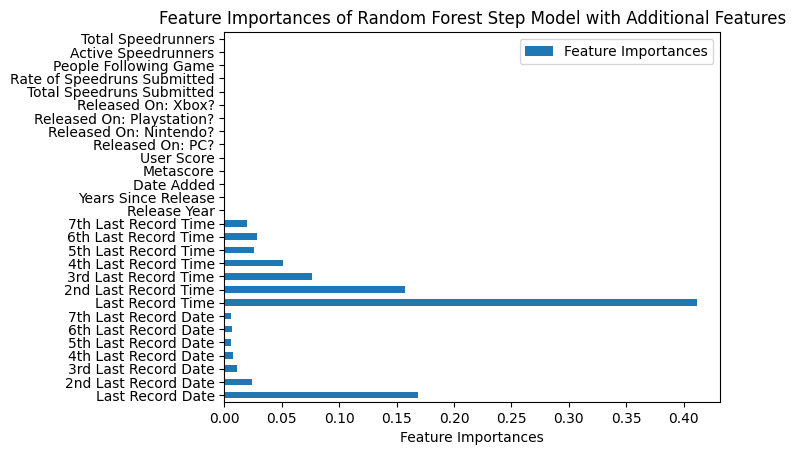

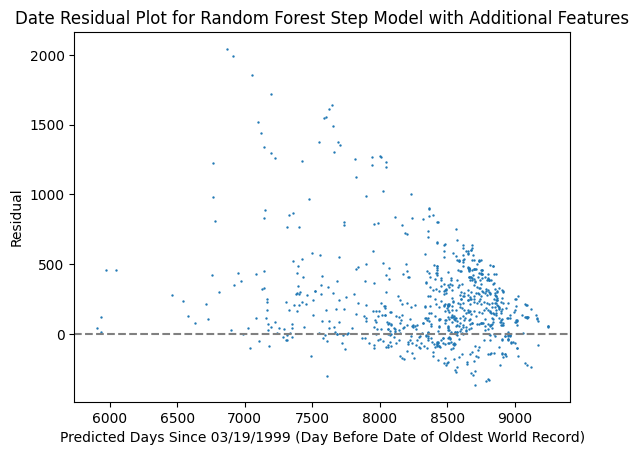

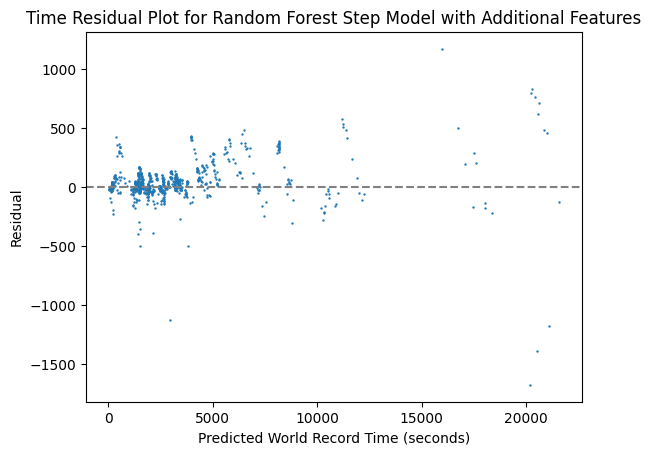

In [79]:
# Creates a random forest step model with additional features using the found tuned hyperparameters.

# 2982 is the total number of training records, but 7 is subtracted from the total
# number of samples for each game because there must be at least 7 games for the
# first training input point.
training_x = np.zeros((2982 - (7 * NUM_GAMES), 28))
training_y = np.zeros((2982 - (7 * NUM_GAMES), 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    num_training_records = len(training_history)
    for j in range(7, num_training_records):
        # Adds the world record data to the training input.
        for k in range(7):
            away_from_end = num_training_records - j + 1 + k
            training_x[index][k] = training_history[-away_from_end, 0]
            training_x[index][k + 7] = training_history[-away_from_end, 1]

        # Adds the additional feature to the training input.
        training_x[i][14] = numerical_training_data[i, 0]
        training_x[i][15] = numerical_training_data[i, 1]
        training_x[i][16] = numerical_training_data[i, 2]
        training_x[i][17] = numerical_training_data[i, 3]
        training_x[i][18] = numerical_training_data[i, 4]
        training_x[i][19] = numerical_training_data[i, 5]
        training_x[i][20] = numerical_training_data[i, 6]
        training_x[i][21] = numerical_training_data[i, 7]
        training_x[i][22] = numerical_training_data[i, 8]
        training_x[i][23] = numerical_training_data[i, 10]
        training_x[i][24] = numerical_training_data[i, 11]
        training_x[i][25] = numerical_training_data[i, 12]
        training_x[i][26] = numerical_training_data[i, 13]
        training_x[i][27] = numerical_training_data[i, 14]

        # Adds the world record data to the actual output.
        training_y[index][0] = training_history[j, 0]
        training_y[index][1] = training_history[j, 1]

        index += 1

# Trains the model.
random_forest_model = ensemble.RandomForestRegressor(criterion="absolute_error", n_estimators=110, max_depth=13, min_samples_split=2)
tuned_random_forest_step = random_forest_model.fit(training_x, training_y)
feature_labels = np.array(["Last Record Date", "2nd Last Record Date", "3rd Last Record Date", "4th Last Record Date", "5th Last Record Date", "6th Last Record Date", "7th Last Record Date", "Last Record Time", "2nd Last Record Time", "3rd Last Record Time", "4th Last Record Time", "5th Last Record Time", "6th Last Record Time", "7th Last Record Time", "Release Year", "Years Since Release", "Date Added", "Metascore", "User Score", "Released On: PC?", "Released On: Nintendo?", "Released On: Playstation?", "Released On: Xbox?", "Total Speedruns Submitted", "Rate of Speedruns Submitted", "People Following Game", "Active Speedrunners", "Total Speedrunners"])
tuned_random_forest_step_coefficients = pd.DataFrame((np.transpose(tuned_random_forest_step.feature_importances_)), columns=["Feature Importances"], index=feature_labels)
print(tuned_random_forest_step_coefficients)

# Maps the coefficients of the features.
tuned_random_forest_step_coefficients.plot.barh()
plt.title("Feature Importances of Random Forest Step Model with Additional Features")
plt.xlabel("Feature Importances")
plt.axvline(x=0, color="black", linewidth="0.3")


print()
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print()


# Creates the test input and actual output for all test records.
test_x = np.zeros((795, 28))
actual_y = np.zeros((795, 2))
index = 0
for i in range(NUM_GAMES):
    training_history = training_wr_array[i]
    test_history = test_wr_array[i]
    num_test_records = len(test_history)
    for j in range(num_test_records):
        # Adds the world record data to the test input.
        for k in range(7):
            away_from_end = num_test_records - j + 1 + k
            if (away_from_end) <= num_test_records:
                test_x[index][k] = test_history[-away_from_end, 0]
                test_x[index][k + 7] = test_history[-away_from_end, 1]
            else:
                test_x[index][k] = training_history[-(away_from_end - num_test_records), 0]
                test_x[index][k + 7] = training_history[-(away_from_end - num_test_records), 1]

        # Adds the additional feature to the test input.
        test_x[index][14] = numerical_test_data[i, 0]
        test_x[index][15] = numerical_test_data[i, 1]
        test_x[index][16] = numerical_test_data[i, 2]
        test_x[index][17] = numerical_test_data[i, 3]
        test_x[index][18] = numerical_test_data[i, 4]
        test_x[index][19] = numerical_test_data[i, 5]
        test_x[index][20] = numerical_test_data[i, 6]
        test_x[index][21] = numerical_test_data[i, 7]
        test_x[index][22] = numerical_test_data[i, 8]
        test_x[index][23] = numerical_test_data[i, 10]
        test_x[index][24] = numerical_test_data[i, 11]
        test_x[index][25] = numerical_test_data[i, 12]
        test_x[index][26] = numerical_test_data[i, 13]
        test_x[index][27] = numerical_test_data[i, 14]

        # Adds the world record data to the actual output.
        actual_y[index][0] = test_history[j, 0]
        actual_y[index][1] = test_history[j, 1]

        index += 1

# Tests the model on just the test world records.
predicted_y = tuned_random_forest_step.predict(test_x)
residuals = np.zeros((795, 2))
date_rmse = metrics.root_mean_squared_error(actual_y[:,0], predicted_y[:,0])
time_rmse = metrics.root_mean_squared_error(actual_y[:,1], predicted_y[:,1])
date_mae = metrics.mean_absolute_error(actual_y[:,0], predicted_y[:,0])
time_mae = metrics.mean_absolute_error(actual_y[:,1], predicted_y[:,1])
date_error_sum = 0
time_error_sum = 0
for i in range(795):
    date_error_sum += abs(actual_y[i][0] - predicted_y[i][0]) / actual_y[i][0]
    time_error_sum += abs(actual_y[i][1] - predicted_y[i][1]) / actual_y[i][1]

    residuals[i][0] = actual_y[i][0] - predicted_y[i][0]
    residuals[i][1] = actual_y[i][1] - predicted_y[i][1]
date_mre = date_error_sum / 795
time_mre = time_error_sum / 795

# Reports various errors.
print("The date root mean squared error is:\t" + str(date_rmse))
print("The time root mean squared error is:\t" + str(time_rmse))
print("The date mean absolute error is:\t" + str(date_mae))
print("The time mean absolute error is:\t" + str(time_mae))
print("The date mean relative error is:\t" + str(date_mre * 100) + "%")
print("The time mean relative error is:\t" + str(time_mre * 100) + "%")


# Plots the residual graphs.
date_residual_plot, date_residual_axes = plt.subplots()
date_residual_axes.set_xlabel("Predicted Days Since 03/19/1999 (Day Before Date of Oldest World Record)")
date_residual_axes.set_ylabel("Residual")
date_residual_axes.set_title("Date Residual Plot for Random Forest Step Model with Additional Features")
date_residual_axes.scatter(predicted_y[:,0], residuals[:,0], s=0.5)
date_residual_axes.hlines(0, 0, 1, transform=date_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
date_residual_plot.show()

time_residual_plot, time_residual_axes = plt.subplots()
time_residual_axes.set_xlabel("Predicted World Record Time (seconds)")
time_residual_axes.set_ylabel("Residual")
time_residual_axes.set_title("Time Residual Plot for Random Forest Step Model with Additional Features")
time_residual_axes.scatter(predicted_y[:,1], residuals[:,1], s=0.5)
time_residual_axes.hlines(0, 0, 1, transform=time_residual_axes.get_yaxis_transform(), colors="gray", linestyle="dashed")
time_residual_plot.show()